# Coherence functions, spectra and antibunching in molecular resonance fluorescence

In [83]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options, entropy_mutual
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import phonons as RC
from style import *
import optical as EM
import time


G= basis(2,0)
E = basis(2,1)

sigma = G*E.dag()

I_sys = qeye(2)
initial_sys = G*G.dag()#0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.
reload(RC)
reload(EM)


<module 'optical' from 'optical.pyc'>

In [84]:
def mutual_info(rho, selA=0, selB=1, base=2):
    return entropy_mutual(rho, selA, selB)

def current(rho, L, operator):
    return (qt.vector_to_operator(L*qt.operator_to_vector(rho))*operator).tr()


# Analytical Weak coupling phonons

In [92]:
reload(EM)



def DecayRate(omega, Gamma, omega_0, beta, J, alpha=0.):
    G = 0
    # Here I define the functions which "dress" the integrands so they have only 1 free parameter for Quad.
    F_p = (lambda x: (EM.cauchyIntegrands(x, Gamma, omega_0, beta, J, 1, alpha=alpha)))
    F_m = (lambda x: (EM.cauchyIntegrands(x, Gamma, omega_0, beta, J, -1, alpha=alpha)))
    F_0 = (lambda x: (EM.cauchyIntegrands(x, Gamma, omega_0, beta, J, 0, alpha=alpha)))
    #w = np.linspace(-600.,600., 1000)
    #plt.plot(w, F_0( w))
    plt.show()
    if omega>0.:
        # These bits do the Cauchy integrals too
        G = (np.pi/2)*(EM.coth(beta*omega/2.)-1)*J(omega, Gamma, omega_0, alpha=alpha)
        G += (1j/2.)*(EM.integral_converge(F_m, 0., omega) - EM.integral_converge(F_p, 0., -omega))
    elif omega==0.:
        # The limit as omega tends to zero is zero for superohmic case?
        G = -(1j)*EM.integral_converge(F_0, -1e-12, 1e10)
    elif omega<0.:
        G = (np.pi/2)*(EM.coth(beta*abs(omega)/2.)+1)*J(abs(omega), Gamma, omega_0, alpha=alpha)
        G += (1j/2.)*(EM.integral_converge(F_m, 0, -abs(omega)) - EM.integral_converge(F_p, 0, abs(omega)))
    return G


def weak_phonon(H_sub, alpha=0., w_0=0., Gamma=0., T=0.):
    A = sigma.dag()*sigma 
    
    return EM.L_non_rwa(H_sub, A, w_0, Gamma, T, J_underdamped, 
                     principal=True, silent=True, alpha=alpha) # need principal value parts

def exciton_states(detuning, Omega):
    eps = detuning
    eta = np.sqrt(eps**2 + (Omega**2))
    lam_m = (-detuning-eta)*0.5
    lam_p = (-detuning+eta)*0.5
    v_p = qt.Qobj(np.array([np.sqrt(eta+eps), np.sqrt(eta-eps)]))/np.sqrt(2*eta)
    v_m = qt.Qobj(np.array([np.sqrt(eta-eps), -np.sqrt(eta+eps)]))/np.sqrt(2*eta)

    return [lam_m, lam_p], [v_m, v_p]

def weak_phonon_analytic(detuning=0., Rabi=0, alpha=0., w0=0., Gamma=0., T_ph=0.):
    H_S = qt.Qobj([[0, Rabi/2.],[Rabi/2., -detuning]])
    evals, evecs = exciton_states(detuning, Rabi)
    eps = detuning
    eta= np.sqrt(eps**2 + Rabi**2)
    psi_m, psi_p = evecs[0], evecs[1]
    #print evals, psi_m, psi_p
    print evals
    #print detuning, Rabi, alpha, w0, Gamma, T_ph
    
    E_proj = ((eta-eps)*psi_p*psi_p.dag() + (eta+eps)*psi_m*psi_m.dag())/(2*eta)
    E_proj -= Rabi*(psi_m*psi_p.dag()+psi_p*psi_m.dag())/(2*eta)
    E_op = sigma.dag()*sigma
    assert E_proj == E_op
    print 0, Gamma, w0, beta_f(T_ph)
    G0 = DecayRate(0, Gamma, w0, beta_f(T_ph), J_underdamped, alpha=alpha)
    Gp = DecayRate(eta, Gamma, w0, beta_f(T_ph), J_underdamped, alpha=alpha)
    Gm = DecayRate(-eta, Gamma, w0, beta_f(T_ph), J_underdamped, alpha=alpha)
    print Gp, Gm
    Z = G0*((eta-eps)*psi_p*psi_p.dag() + (eta+eps)*psi_m*psi_m.dag())/(2*eta)
    Z -= Rabi*(Gp*psi_m*psi_p.dag()+Gm*psi_p*psi_m.dag())/(2*eta)
    #print Z
    
    L =  qt.spre(E_op*Z) - qt.sprepost(Z, E_op)
    L += qt.spost(Z.dag()*E_op) - qt.sprepost(E_op, Z.dag())
    
    return -L


#L_EM = EM.L_nonsecular(H, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
#WC_test(detuning=0.01, alpha=0.1, Rabi=0.01, w0=0.15, T_ph=77)
#L = weak_phonon_analytic(detuning=80., Rabi=40., alpha=4., w0=80., Gamma=40., T_ph=35)
#H_sub = (-80.)*sigma.dag()*sigma + (40./2)*(sigma.dag()+sigma)
#L = weak_phonon(H_sub, alpha=4., w_0=80., Gamma=40., T=35.)
#print L

In [93]:
reload(EM)
reload(RC)
def add_comparison(detuning=0., alpha=0.01, Rabi=0.01, w0=0.01, N=5, 
      T_ph=77., Gamma=30, overdamped=True):
    
    detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*epsilon
    if overdamped:
        Gamma = (w0**2)/100.
    Gamma_EM =  100*5.309e-3
    alpha_ph = alpha*ev_to_inv_cm
    
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print H_sub, "Laser "
    tf =  1 #0.025
    print w0, alpha_ph, Gamma
    timelist = np.linspace(0, tf, 1000)

    n_RC = EM.Occupation(w0, T_ph)

    #prop_of_eps = np.linspace(0.05, upper_alpha, 3)
    
    energies, states = H_sub.eigenstates()
    real_exciton = 0.5*(states[1]*states[0].dag() + states[0]*states[1].dag())
    imag_exciton = 0.5*1j*(states[1]*states[0].dag() - states[0]*states[1].dag())
    I = qeye(N)
    print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    
               
    #rho_0 = tensor(initial_sys, qt.fock_dm(N, n=N-1, offset=0))
    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))

    

    L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, Gamma, 
                                                                        w0, alpha_ph, N,
                                                                        silent=False, w_laser=w_laser)
    expects = [tensor(G*G.dag(), I), tensor(E*E.dag(), I), tensor(E*G.dag()+G*E.dag(), I), #0, 1, 2
               Rabi*(1j*tensor(G*E.dag()-E*G.dag(), I)), # 3, TLS current
               tensor(real_exciton, I), tensor(imag_exciton, I), # 4, 5
               tensor(qeye(2), destroy(N).dag()*destroy(N)), #6 
               tensor(qeye(2), destroy(N).dag()+destroy(N)), # 7
               kappa*1j*tensor(E*E.dag(), destroy(N).dag()-destroy(N))] # 8
    eps_rot = epsilon #+((kappa**2)/wRC)
    J = J_multipolar
    L_EM = EM.L_nonsecular(H, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    L_add = EM.L_nonsecular(tensor(H_sub, I), A_EM, eps_rot, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    ss, ss_add = steadystate(H, [L_RC+L_EM]), steadystate(H, [L_RC+L_add])
    print "Full:\n", ss.ptrace(0).full(), '\n Add.:\n', ss_add.ptrace(0).full()
    options = Options(nsteps=1500, store_states=True)
    #mesolve(H, rho0, tlist, c_ops=[], e_ops=[], args={}, options=None, progress_bar=None, _safe_mode=True)
    data = mesolve(H, rho_0, timelist, c_ops=[L_RC+L_EM], e_ops=expects, options=options)
    data_add = mesolve(H, rho_0, timelist, c_ops=[L_RC+L_add], e_ops=expects, options=options)
    print("Dynamics complete")
    return timelist, data, data_add, L_RC, H, A_ph, A_EM, [ss, ss_add], [Rabi, kappa]

In [94]:
reload(EM)
reload(RC)
def WC_comparison(detuning=0., alpha=0.01, Rabi=0.01, w0=0.01, N=5, 
      T_ph=77., Gamma=30, overdamped=True, tf=1.):
    
    detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*epsilon
    if overdamped:
        Gamma = (w0**2)/100.
    Gamma_EM =  100*5.309e-3
    alpha_ph = alpha*ev_to_inv_cm
    
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print H_sub, "Laser "
    print w0, alpha_ph, Gamma
    timelist = np.linspace(0, tf, int(tf)*1000)
    energies, states = H_sub.eigenstates()
    real_exciton = 0.5*(states[1]*states[0].dag() + states[0]*states[1].dag())
    imag_exciton = 0.5*1j*(states[1]*states[0].dag() - states[0]*states[1].dag())
    J = J_multipolar
    L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, Gamma, 
                                                                        w0, alpha_ph, N,
                                                                        silent=False, w_laser=w_laser)
    L, L_wc = 0,0
    ss, data = [], []
    options = Options(nsteps=1500, store_states=True)
    for i, l in enumerate(['full', 'WC']):
        if l =='full':
            n_RC = EM.Occupation(w0, T_ph)
            I = qeye(N)
            rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
            expects = [tensor(G*G.dag(), I), tensor(E*E.dag(), I), tensor(E*G.dag()+G*E.dag(), I), #0, 1, 2
                       Rabi*(1j*tensor(G*E.dag()-E*G.dag(), I)), # 3, TLS current
                        tensor(real_exciton, I), tensor(imag_exciton, I), #4,5
                       tensor(qeye(2), destroy(N).dag()*destroy(N)), # 6
                       tensor(qeye(2), destroy(N).dag()+destroy(N)), # 7
                       kappa*1j*tensor(E*E.dag(), destroy(N).dag()-destroy(N))] # 8
            L = L_RC + EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
            ss.append(steadystate(H, [L]))
            data.append(mesolve(H, rho_0, timelist, c_ops=[L], e_ops=expects, options=options))
        else:
            expects = [G*G.dag(), E*E.dag(), E*G.dag()+G*E.dag(), #0, 1, 2
                       1j*Rabi*(G*E.dag()-E*G.dag()), # 3, TLS current
                       real_exciton, imag_exciton] # 4, 5
            
            shift = 0.5*pi*alpha_ph
            H_sub = H_sub +shift*E*E.dag()
            #print "WC Hamiltonian", H_sub
            #L_wc = weak_phonon_analytic(detuning=detuning, Rabi=Rabi, 
            #                            alpha=alpha_ph, w0=w0, Gamma=Gamma, T_ph=T_ph)
            L_wc = weak_phonon(H_sub, alpha=alpha_ph, 
                               w_0=w0, Gamma=Gamma, T=T_ph)
            #print L_wc, L_wc2
            L_wc+= EM.L_nonsecular(H_sub, sigma, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
            ss.append(steadystate(H_sub, [L_wc]))
            rho_0 = initial_sys
            data.append(mesolve(H_sub, rho_0, timelist, c_ops=[L_wc], e_ops=expects, options=options))  
            
    print "Full:\n", ss[0].ptrace(0).full(), '\n Add.:\n', ss[1].ptrace(0).full()
    print("Dynamics complete")
    return timelist, data[0], data[1], L_RC, H, A_ph, A_EM, ss, [Rabi, kappa]



In [95]:
"""[tensor(G*G.dag(), I), tensor(E*E.dag(), I), tensor(E*G.dag()+G*E.dag(), I), #0, 1, 2
               Rabi*(1j*tensor(G*E.dag()-E*G.dag(), I)), # 3, TLS current
                tensor(real_exciton, I), tensor(imag_exciton, I), #4,5
               tensor(qeye(2), destroy(N).dag()*destroy(N)), # 6
               tensor(qeye(2), destroy(N).dag()+destroy(N)), # 7
               kappa*1j*tensor(E*E.dag(), destroy(N).dag()-destroy(N))] # 8"""

def plot_thermo_and_info(timelist, data_1, data_2, L, H_S, O, ss, timelength=1):
    labels = ['full', 'add.']
    data_list = [data_1, data_2]
    if type(H_S) == list:
        H_S = H_S[1]
    f, ((ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(5, 1, figsize=(12,12), sharex=True,tight_layout=True)
    for i, data in enumerate(data_list):
        l, c = labels[i], colourWheel[i]
        energy = np.array([current(rho, L, H_S).real for rho in data.states])
        n_R_dot = np.array([current(rho, L, O).real for rho in data.states])
        mutual = np.array([mutual_info(rho).real for rho in data.states])
        
        #ax1.plot(timelist, energy, label=l, color=c)
        #ax1.axhline(current(ss[i], L, H_S).real, color=c, ls='dotted')
        n_S_dot = -data.expect[8]
        number = data.expect[6].real
        d1 = n_R_dot + n_S_dot
        d2 = np.gradient(number)
        ratio =max(abs(d2))/max(abs(d1)) # check what the scaling is between analytical and numerical diff.
        n_dot = d1*ratio
        n_S_dot*=ratio # scale the analytical models to match the numerical
        n_R_dot*=ratio
        ax1.plot(timelist, n_dot, label=l, color=c) #  TLS-RC current
        ax1.axhline(n_dot[-1], color=c, ls='dotted') 
        
        ax2.plot(timelist, n_S_dot, label=l, color=c) # TD of b.dag()*b
        ax2.axhline(n_S_dot[-1], color=c, ls='dotted')
        ax3.plot(timelist, n_R_dot, label=l, color=c) # residual phonon current
        ax3.axhline(current(ss[i], L, O).real*ratio, color=c, ls='dotted')

        ax4.plot(timelist, number, label=l, color=c) # number operator
        ax4.axhline(number[-1], color=c, ls='dotted')
        ax5.plot(timelist, mutual, label=l, color=c) # mutual info
        ax5.axhline(mutual_info(rho).real, color=c, ls='dotted')
    #ax1.set_ylabel(r'$\langle\dot{H_S}\rangle$')
    ax1.set_ylabel(r'$\langle{\dot{n}}\rangle$')
    ax2.set_ylabel(r'$\langle{\dot{n}_S}\rangle$')
    #ax3.set_ylabel(r'$\langle{\dot{n}}\rangle$')
    ax3.set_ylabel(r'$\langle{\dot{n_R}}\rangle$')
    ax4.set_ylabel(r'$\langle{n}\rangle$')
    ax5.set_ylabel(r'$I(\rho_M, \rho_{RC})$')
    ax5.set_xlabel('Time')
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        #ax.legend(loc='best')
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
    plt.show()
    #return n_dot, n_S_dot, n_R_dot

def plot_dynamics(timelist, data_1, data_2, A_EM, A_ph, ss, timelength=1, labels = ['full', 'add.']):
    linestyles = ['solid', 'solid']
    data_list = [data_1, data_2]
    alphas = [1, 0.5]
    f, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(12,12), sharex=True)
    for i, data in enumerate(data_list):
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        if l =='WC':
            A_EM, A_ph = sigma, 0.
        ax1.plot(timelist, data.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax1.axhline((ss[i]*A_EM.dag()*A_EM).tr().real, color=c, ls='dotted')
        ax2.plot(timelist, data.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax2.axhline((ss[i]*(A_EM.dag()+A_EM)).tr().real, color=c, ls='dotted')
        ax3.plot(timelist, data.expect[4].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        ax3.axhline(data.expect[4].real.real[-1], color=c, ls='dotted')
        ax4.plot(timelist, data.expect[3].real, label=l, color=c, ls=linestyle, alpha=a) # TLS current
        ax4.axhline(data.expect[3].real[-1], color=c, ls='dotted')
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax3.set_ylabel(r'$2\Re\langle |+\rangle\!\langle -|\rangle$')
    ax4.set_ylabel(r'$\langle I_{g \to e} \rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax4.set_xlabel('Time')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()

In [96]:
def fourier(timelist, signal, absval=False):
    spec = sp.fftpack.fft(signal)
    dt = timelist[1]-timelist[0]
    freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
    spec = 2 * dt* np.real(spec)
    if absval:
        spec = 2 * dt* np.abs(spec)
    return freq, spec

def plot_fourier(tlist, signal, vline=None, absval=False, x_lim = None):
    plt.figure()
    freq, spec = fourier(tlist, signal-signal[-1], absval=absval)
    freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))
    plt.plot(freq, spec)
    if vline is not None:
        plt.axvline(vline, ls='dotted')
    if x_lim is not None:
        plt.xlim(-x_lim, x_lim)
    else:
        plt.xlim(freq[0], freq[-1])
    plt.show()


# Comparison to Weak coupling theory

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.       4.03275]
 [ 4.03275 -8.0655 ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.586388498965 with step size of 200.0
Integral converged to 3.36644440405 with step size of 10
Integral converged to 0.284330708064 with step size of 10
Integral converged to 2.60146332046 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.65149412+0.j          0.14712748+0.02308377j]
 [ 0.14712748-0.02308377j  0.34850588+0.j        ]] 
 Add.:
[[ 0.65160955+0.j          0.14715632+0.02305566j]
 [ 0.14715632-0.02305566j  0.34839045+0.j        ]]
Dynamics complete


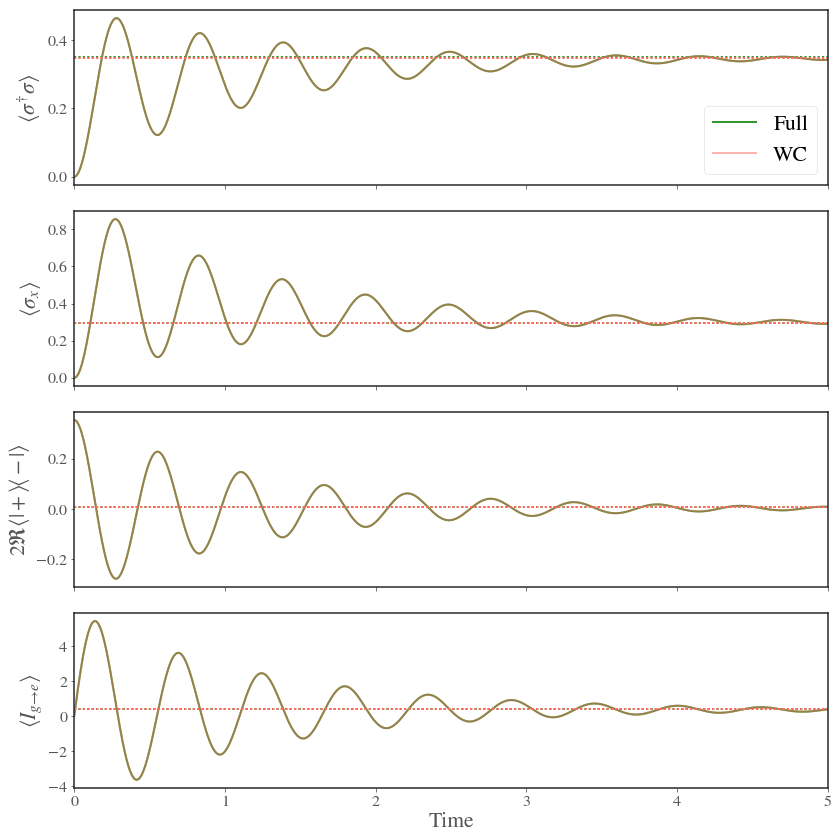

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.        4.03275]
 [  4.03275 -80.655  ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.1699561881 with step size of 200.0
Integral converged to -1.32274587357 with step size of 50.0
Integral converged to -0.466631502796 with step size of 50.0
Integral converged to 1.19443250124 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.97002625+0.j          0.04820182+0.00208974j]
 [ 0.04820182-0.00208974j  0.02997375+0.j        ]] 
 Add.:
[[ 0.96884023+0.j          0.04808634+0.00217072j]
 [ 0.04808634-0.00217072j  0.03115977+0.j        ]]
Dynamics complete


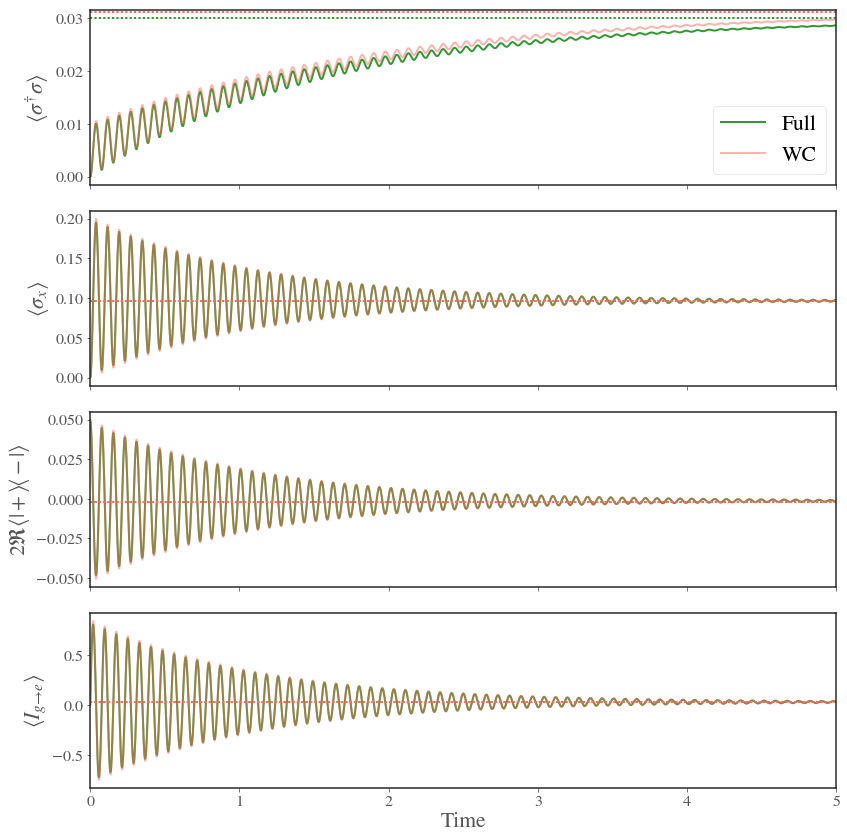

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.       4.03275]
 [ 4.03275 -8.0655 ]] Laser 
80.655 8.0655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=31.97 | Gamma_RC=65.05 | alpha_ph=8.07 | N=9 |
Integral converged to 12.6692577734 with step size of 200.0
Integral converged to 6.22261871911 with step size of 100.0
Integral converged to 33.7165865474 with step size of 5.0
Integral converged to 3.38680652878 with step size of 5.0
Integral converged to 26.7998428817 with step size of 100.0
Integral converged to 12.6692577734 with step size of 200.0
Full:
[[ 0.49550338+0.j         -0.03291042+0.03358233j]
 [-0.03291042-0.03358233j  0.50449662+0.j        ]] 
 Add.:
[[ 0.48700848+0.j         -0.03768150+0.03393937j]
 [-0.03768150-0.03393937j  0.51299152+0.j        ]]
Dynamics complete


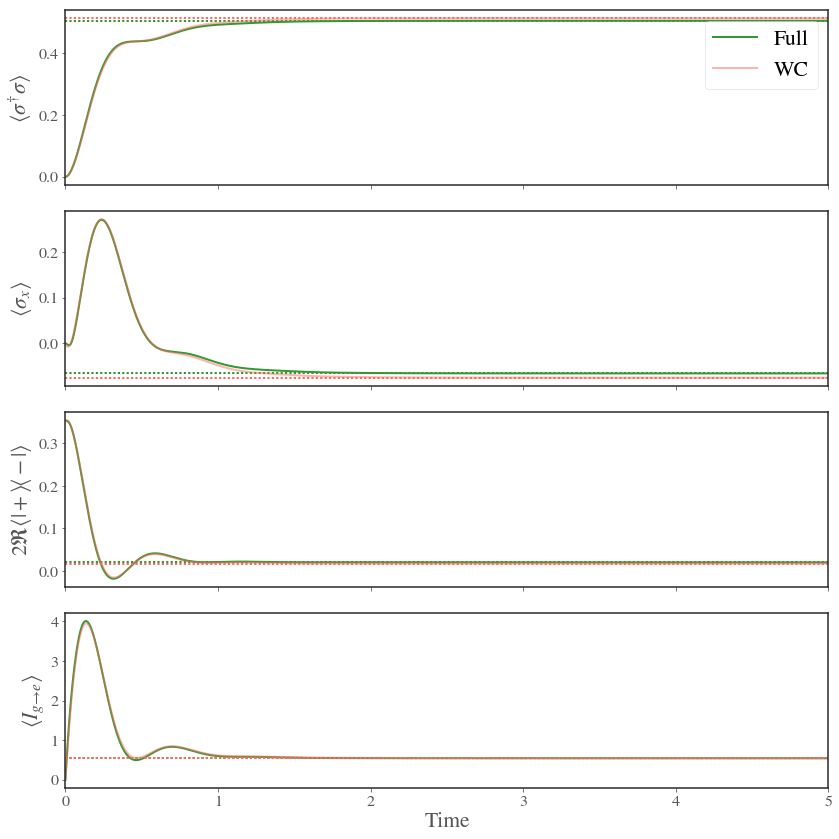

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275  -8.0655]] Laser 
80.655 8.0655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=31.97 | Gamma_RC=65.05 | alpha_ph=8.07 | N=9 |
Integral converged to 12.6692577734 with step size of 200.0
Integral converged to 1.68376893867 with step size of 200.0
Integral converged to -15.0751188648 with step size of 50.0
Integral converged to -4.64464110654 with step size of 50.0
Integral converged to 11.8612637891 with step size of 200.0
Integral converged to 12.6692577734 with step size of 200.0
Full:
[[ 0.45381747+0.j         -0.43484887+0.00367655j]
 [-0.43484887-0.00367655j  0.54618253+0.j        ]] 
 Add.:
[[ 0.46328156+0.j         -0.45750681+0.00359477j]
 [-0.45750681-0.00359477j  0.53671844+0.j        ]]
Dynamics complete


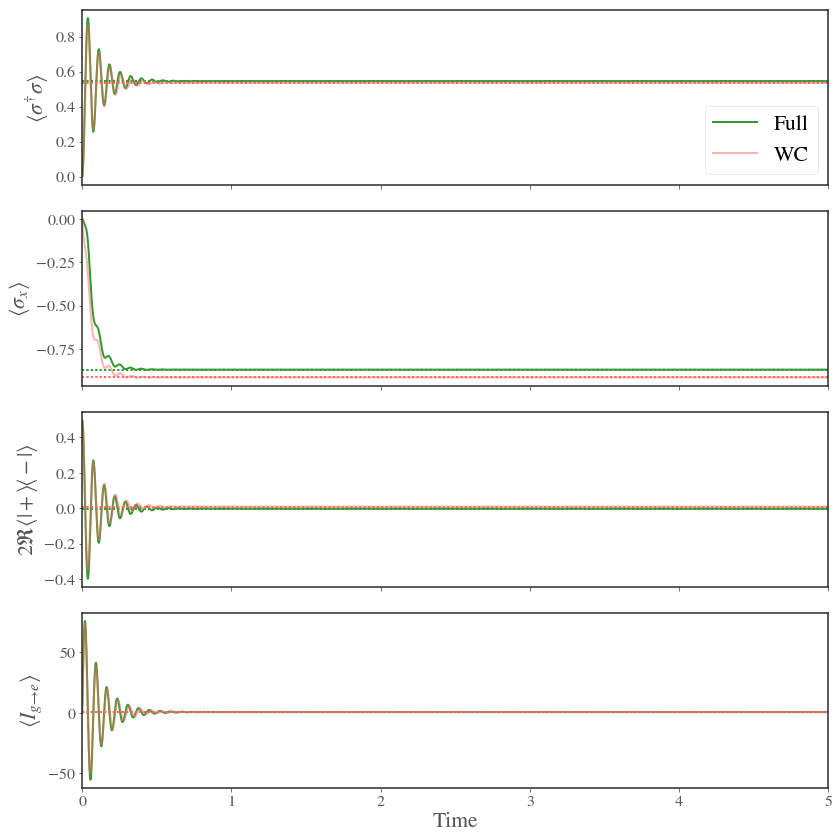

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 8.0655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=31.97 | Gamma_RC=65.05 | alpha_ph=8.07 | N=9 |
Integral converged to 12.6692577734 with step size of 200.0
Integral converged to 1.36847986624 with step size of 200.0
Integral converged to -34.2915781737 with step size of 100.0
Integral converged to -3.27667357481 with step size of 100.0
Integral converged to 10.1234541124 with step size of 200.0
Integral converged to 12.6692577734 with step size of 200.0
Full:
[[ 0.21230078+0.j         -0.26287334+0.00555288j]
 [-0.26287334-0.00555288j  0.78769922+0.j        ]] 
 Add.:
[[ 0.18278076+0.j         -0.29895148+0.00571623j]
 [-0.29895148-0.00571623j  0.81721924+0.j        ]]
Dynamics complete


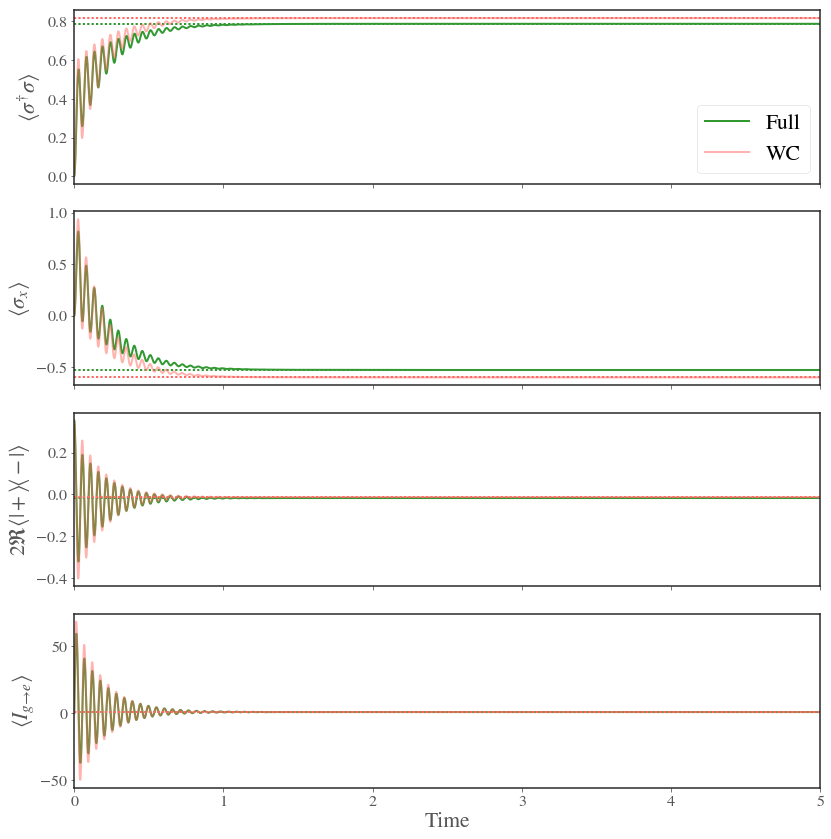

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 80.655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=101.09 | Gamma_RC=65.05 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 15.1269423837 with step size of 200.0
Integral converged to -305.273840534 with step size of 50.0
Integral converged to -40.5600919373 with step size of 50.0
Integral converged to 109.381620966 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.12297912+0.j         -0.22437358+0.00641446j]
 [-0.22437358-0.00641446j  0.87702088+0.j        ]] 
 Add.:
[[ 0.49240658+0.j         -0.47389279+0.00349264j]
 [-0.47389279-0.00349264j  0.50759342+0.j        ]]
Dynamics complete


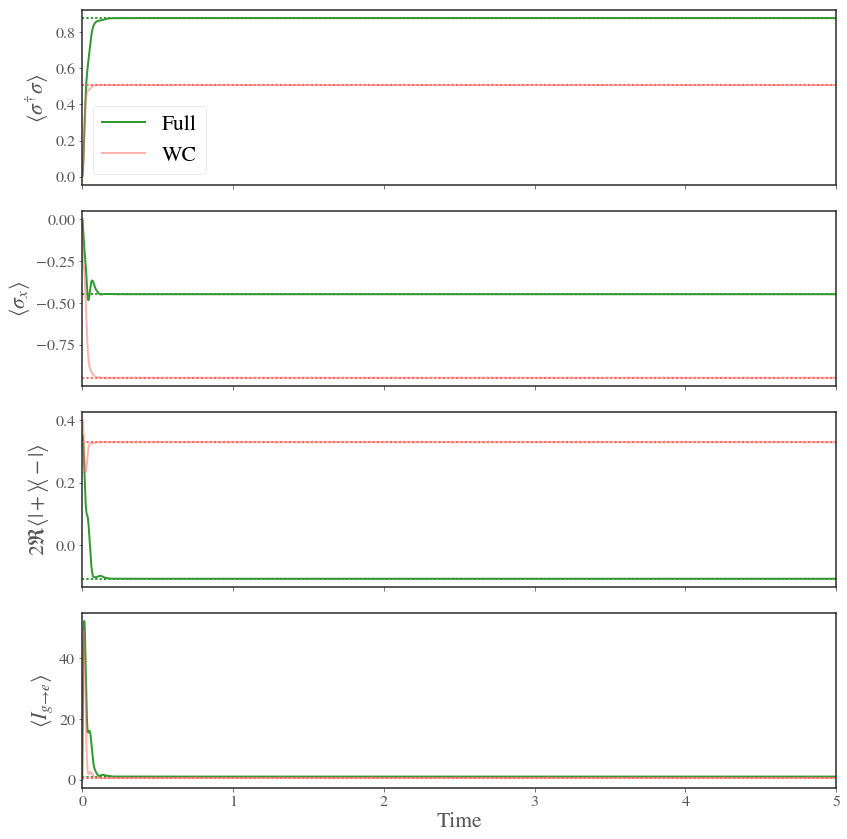

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       40.3275 ]
 [ 40.3275   -0.80655]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 7.75511497139 with step size of 200.0
Integral converged to 35.2954605464 with step size of 100.0
Integral converged to -12.273507357 with step size of 100.0
Integral converged to 114.669066039 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.49968702+0.j         -0.42138209+0.00350261j]
 [-0.42138209-0.00350261j  0.50031298+0.j        ]] 
 Add.:
[[ 0.71167044+0.j        -0.26495688+0.0019679j]
 [-0.26495688-0.0019679j  0.28832956+0.j       ]]
Dynamics complete


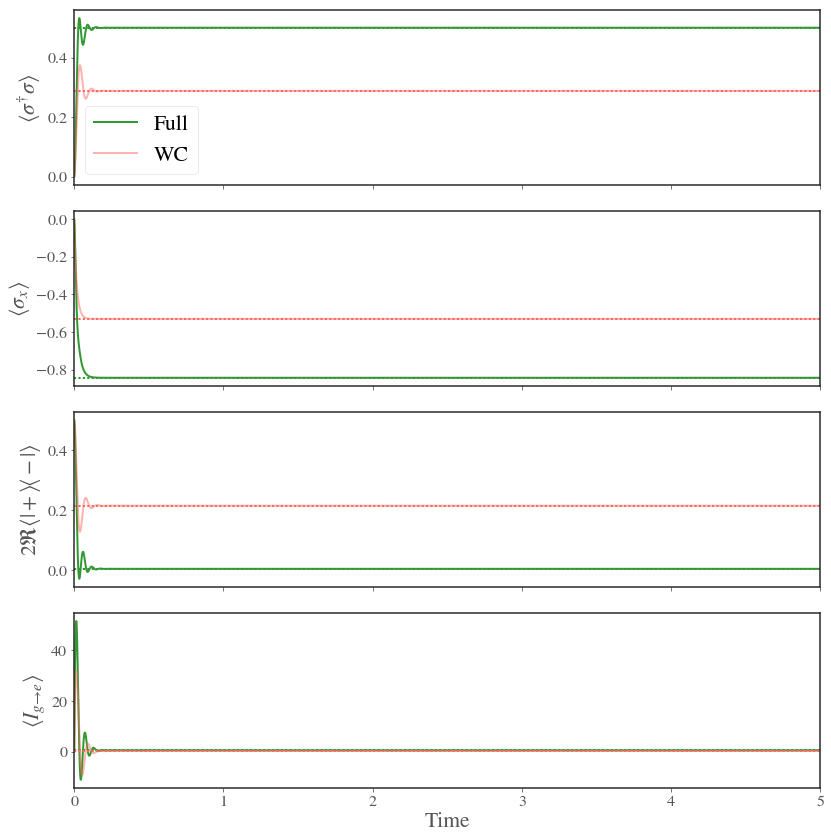

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       40.3275 ]
 [ 40.3275   -0.80655]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 7.75511497139 with step size of 200.0
Integral converged to 35.2954605464 with step size of 100.0
Integral converged to -12.273507357 with step size of 100.0
Integral converged to 114.669066039 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.49968702+0.j         -0.42138209+0.00350261j]
 [-0.42138209-0.00350261j  0.50031298+0.j        ]] 
 Add.:
[[ 0.71167044+0.j        -0.26495688+0.0019679j]
 [-0.26495688-0.0019679j  0.28832956+0.j       ]]
Dynamics complete


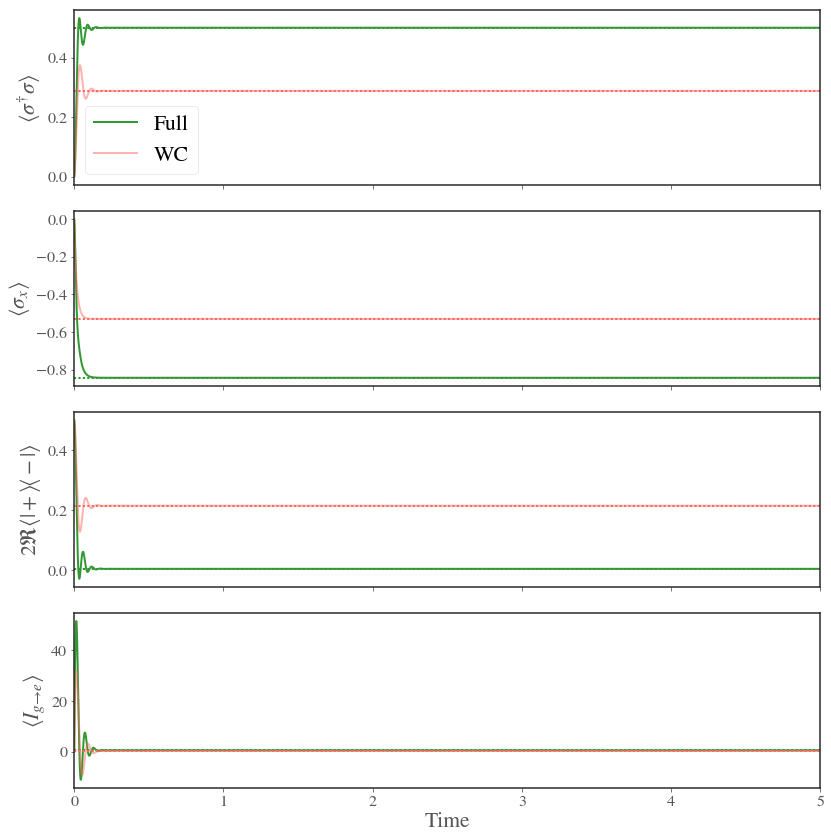

In [101]:
reload(EM)

timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.001, alpha=0.0001, 
                                                           Rabi=0.001, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.001, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.001, alpha=0.001, 
                                                           Rabi=0.001, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.001, alpha=0.001, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.001, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 80.655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=101.09 | Gamma_RC=65.05 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 15.1269423837 with step size of 200.0
Integral converged to -305.273840534 with step size of 50.0
Integral converged to -40.5600919373 with step size of 50.0
Integral converged to 109.381620966 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.12297912+0.j         -0.22437358+0.00641446j]
 [-0.22437358-0.00641446j  0.87702088+0.j        ]] 
 Add.:
[[ 0.49240658+0.j         -0.47389279+0.00349264j]
 [-0.47389279-0.00349264j  0.50759342+0.j        ]]
Dynamics complete


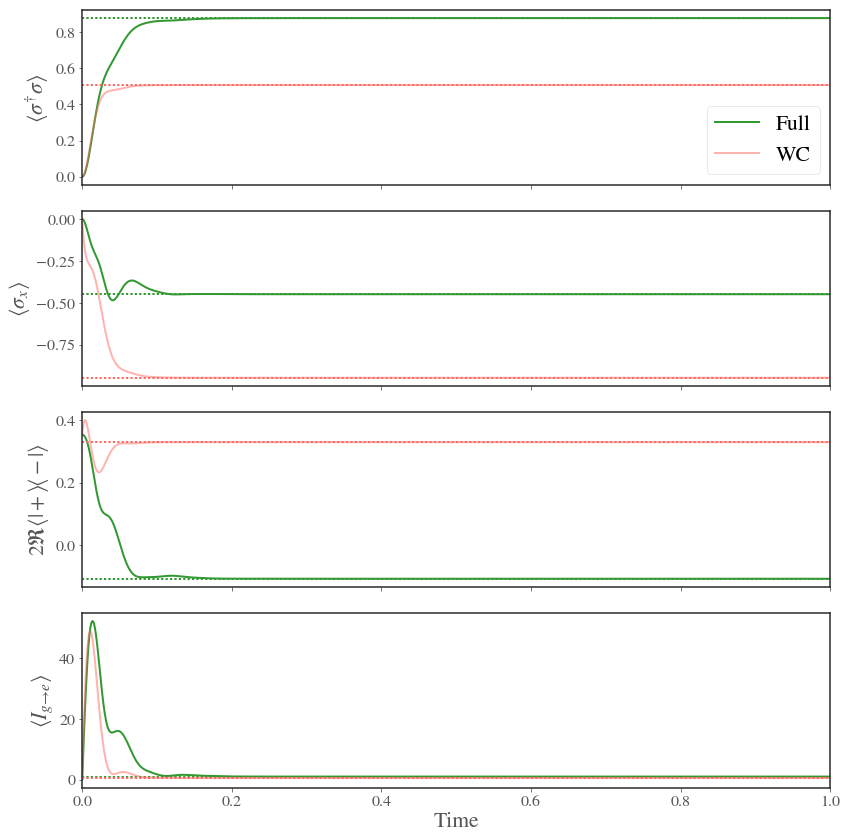

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       40.3275 ]
 [ 40.3275   -0.80655]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 7.75511497139 with step size of 200.0
Integral converged to 35.2954605464 with step size of 100.0
Integral converged to -12.273507357 with step size of 100.0
Integral converged to 114.669066039 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.49968702+0.j         -0.42138209+0.00350261j]
 [-0.42138209-0.00350261j  0.50031298+0.j        ]] 
 Add.:
[[ 0.71167044+0.j        -0.26495688+0.0019679j]
 [-0.26495688-0.0019679j  0.28832956+0.j       ]]
Dynamics complete


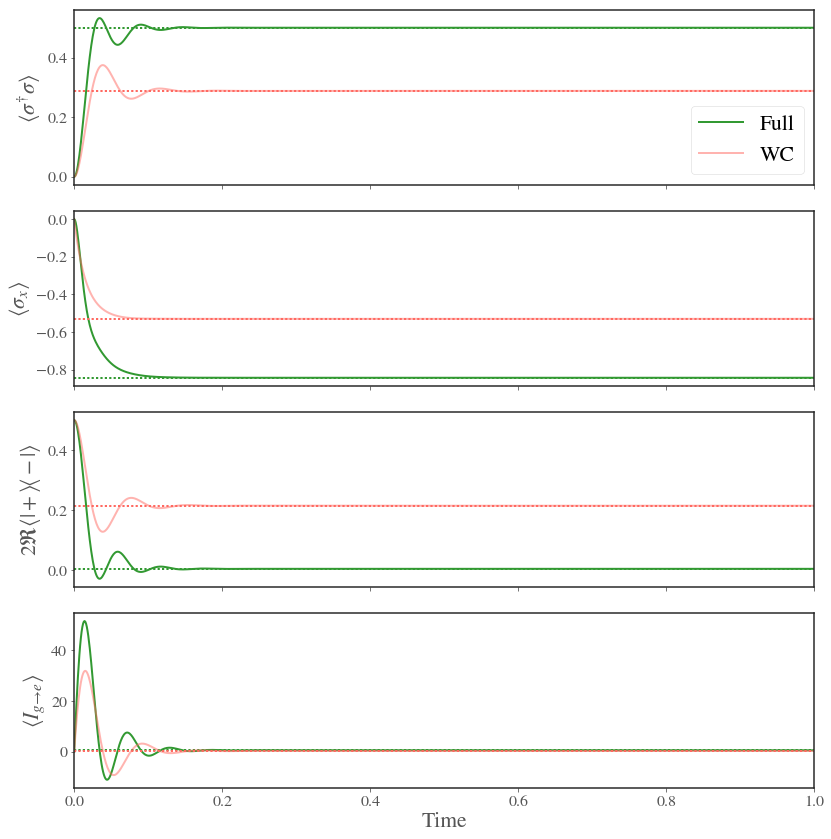

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       40.3275 ]
 [ 40.3275   -0.80655]] Laser 
806.55 161.31 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=452.07 | Gamma_RC=6505.23 | alpha_ph=161.31 | N=12 |
Integral converged to 253.385155475 with step size of 200.0
Integral converged to 9.31477674013 with step size of 200.0
Integral converged to -59.7583763175 with step size of 200.0
Integral converged to -11.7609921736 with step size of 200.0
Integral converged to 172.830677784 with step size of 200.0
Integral converged to 253.385155475 with step size of 200.0
Full:
[[ 0.50494191+0.j         -0.38627561+0.00362871j]
 [-0.38627561-0.00362871j  0.49505809+0.j        ]] 
 Add.:
[[ 0.82584085+0.j         -0.13816230+0.00124472j]
 [-0.13816230-0.00124472j  0.17415915+0.j        ]]
Dynamics complete


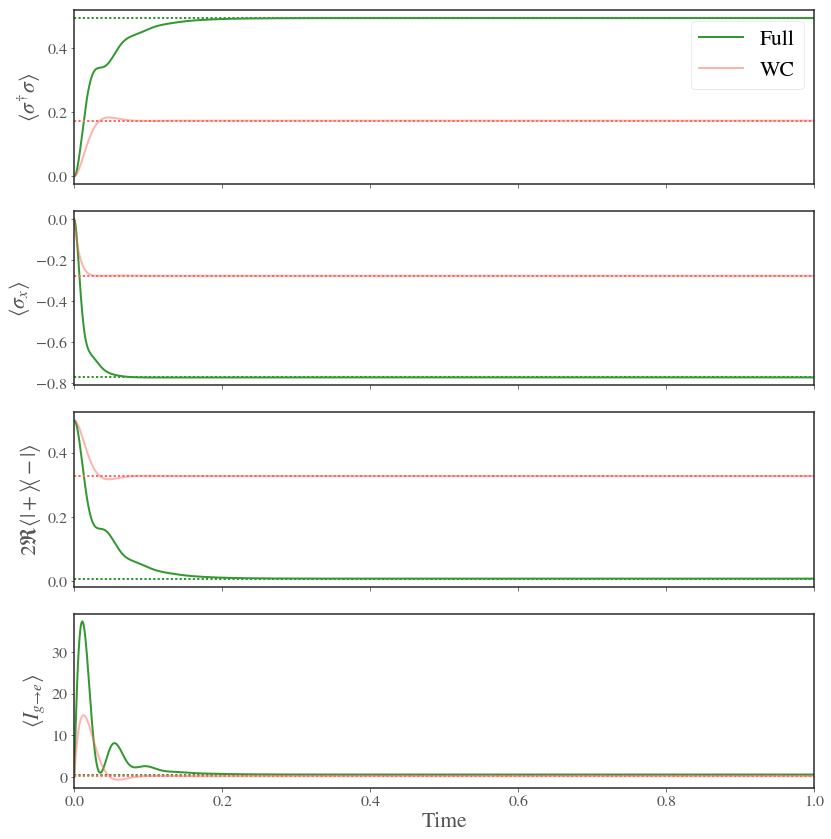

In [112]:
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.01, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.0001, alpha=0.01, 
                                                           Rabi=0.01, w0=0.1, N=9, T_ph=35, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.0001, alpha=0.02, 
                                                           Rabi=0.01, w0=0.1, N=12, T_ph=35, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       20.16375]
 [ 20.16375 -40.3275 ]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 11.328174917 with step size of 200.0
Integral converged to 115.522899731 with step size of 50.0
Integral converged to -22.3662416653 with step size of 50.0
Integral converged to 139.121913407 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.22797368+0.j       -0.24743778+0.011036j]
 [-0.24743778-0.011036j  0.77202632+0.j      ]] 
 Add.:
[[ 0.57435525+0.j         -0.21006748+0.00585361j]
 [-0.21006748-0.00585361j  0.42564475+0.j        ]]
Dynamics complete


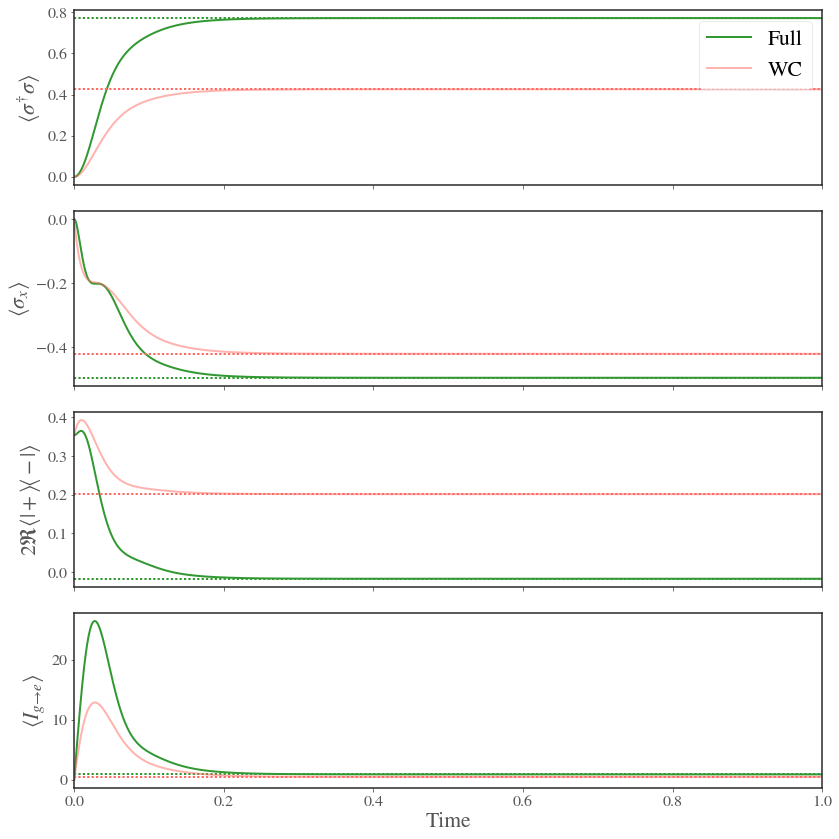

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       20.16375]
 [ 20.16375 -40.3275 ]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 38.5793027535 with step size of 200.0
Integral converged to 62.1055968117 with step size of 50.0
Integral converged to -75.7835445848 with step size of 50.0
Integral converged to 166.373041118 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.35181481+0.j         -0.14631092+0.00926311j]
 [-0.14631092-0.00926311j  0.64818519+0.j        ]] 
 Add.:
[[ 0.61614065+0.j         -0.12047864+0.00528527j]
 [-0.12047864-0.00528527j  0.38385935+0.j        ]]
Dynamics complete


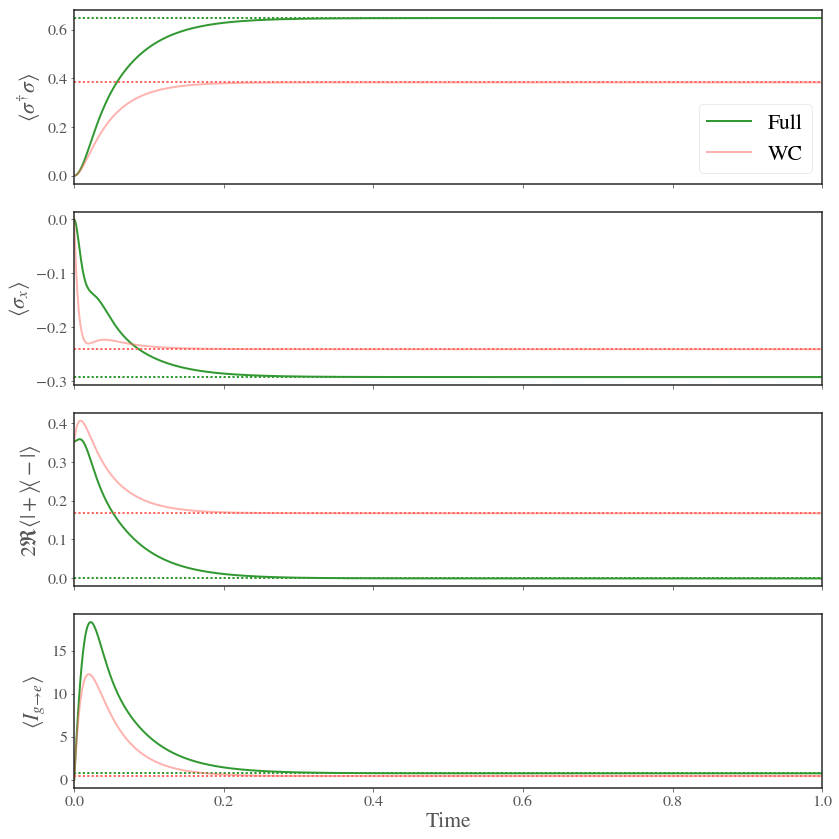

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       20.16375]
 [ 20.16375 -40.3275 ]] Laser 
806.55 80.655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=319.66 | Gamma_RC=6505.23 | alpha_ph=80.66 | N=9 |
Integral converged to 126.692577737 with step size of 200.0
Integral converged to 225.450401816 with step size of 200.0
Integral converged to -159.800239046 with step size of 50.0
Integral converged to -297.689380442 with step size of 50.0
Integral converged to 353.244140181 with step size of 200.0
Integral converged to 126.692577737 with step size of 200.0
Full:
[[ 0.48690915+0.j         -0.04271096+0.00734173j]
 [-0.04271096-0.00734173j  0.51309085+0.j        ]] 
 Add.:
[[ 0.58389442+0.j         -0.04359978+0.00573721j]
 [-0.04359978-0.00573721j  0.41610558+0.j        ]]
Dynamics complete


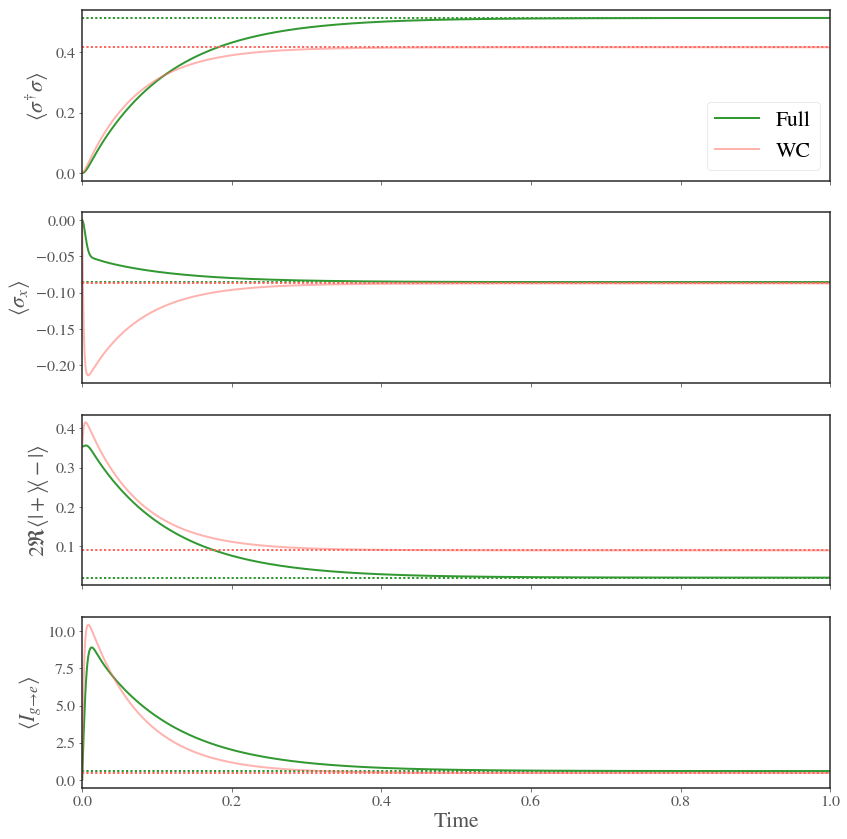

In [102]:
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.005, alpha=0.01, 
                                                           Rabi=0.005, w0=0.1, N=9, T_ph=35, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.005, alpha=0.01, 
                                                           Rabi=0.005, w0=0.1, N=9, T_ph=77, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.005, alpha=0.01, 
                                                           Rabi=0.005, w0=0.1, N=9, T_ph=300, tf=1.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.       4.03275]
 [ 4.03275 -8.0655 ]] Laser 
403.275 0.80655 1626.30725625
w_RC=403.275 | RC-res. coupling=0.6418 | TLS-RC coupling=22.60 | Gamma_RC=1626.31 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.498451777059 with step size of 200.0
Integral converged to 3.01492101142 with step size of 10
Integral converged to 0.119034573026 with step size of 10
Integral converged to 2.61785514568 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.65378793+0.j          0.15220888+0.02293082j]
 [ 0.15220888-0.02293082j  0.34621207+0.j        ]] 
 Add.:
[[ 0.65371149+0.j          0.15153259+0.02291622j]
 [ 0.15153259-0.02291622j  0.34628851+0.j        ]]
Dynamics complete


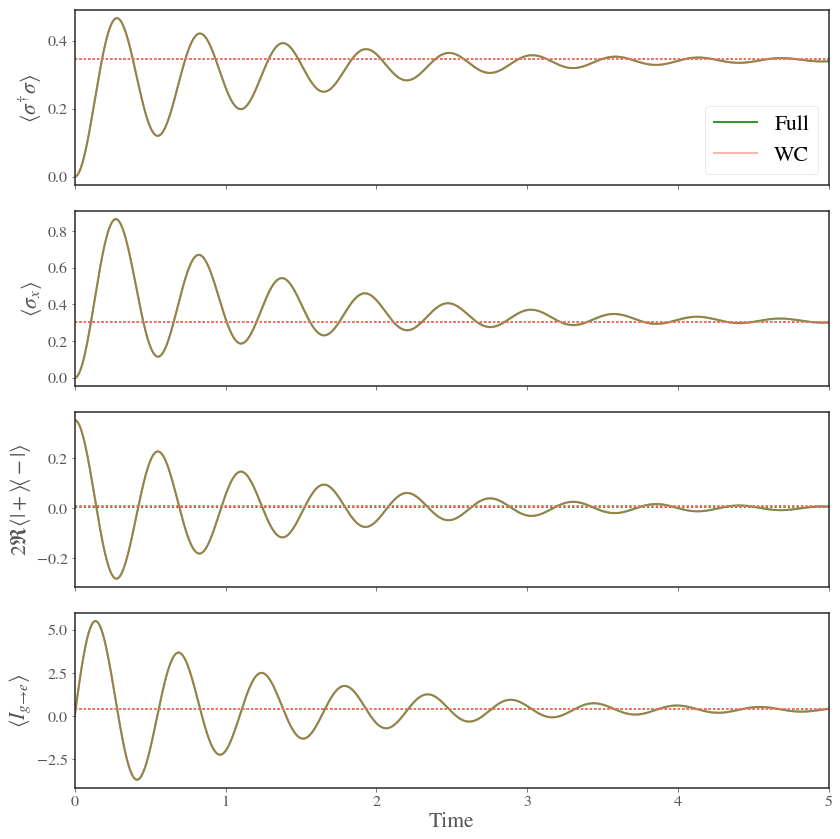

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.129366232352 with step size of 200.0
Integral converged to -3.33921194716 with step size of 100.0
Integral converged to -0.287706289793 with step size of 100.0
Integral converged to 0.968680486634 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.53478567+0.j          0.04066690+0.00325374j]
 [ 0.04066690-0.00325374j  0.46521433+0.j        ]] 
 Add.:
[[ 0.53255282+0.j          0.03849597+0.00326733j]
 [ 0.03849597-0.00326733j  0.46744718+0.j        ]]
Dynamics complete


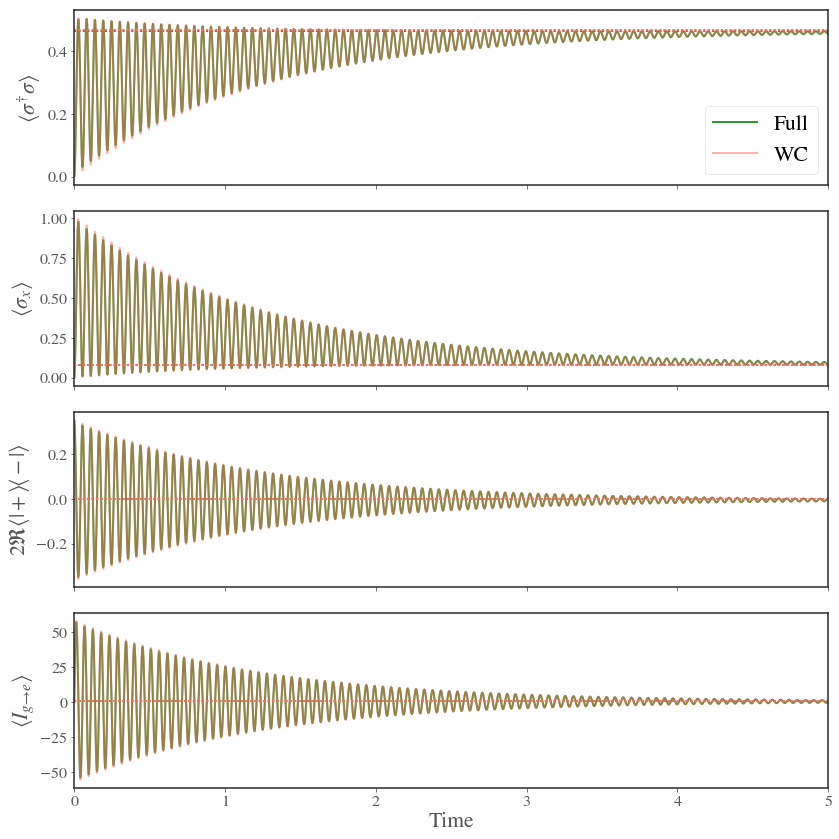

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       20.16375]
 [ 20.16375 -80.655  ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.156282375151 with step size of 200.0
Integral converged to -2.71275524818 with step size of 50.0
Integral converged to -0.42869145595 with step size of 50.0
Integral converged to 1.12134601723 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.63819652+0.j          0.07378651+0.00505085j]
 [ 0.07378651-0.00505085j  0.36180348+0.j        ]] 
 Add.:
[[ 0.62920478+0.j          0.06933265+0.00517266j]
 [ 0.06933265-0.00517266j  0.37079522+0.j        ]]
Dynamics complete


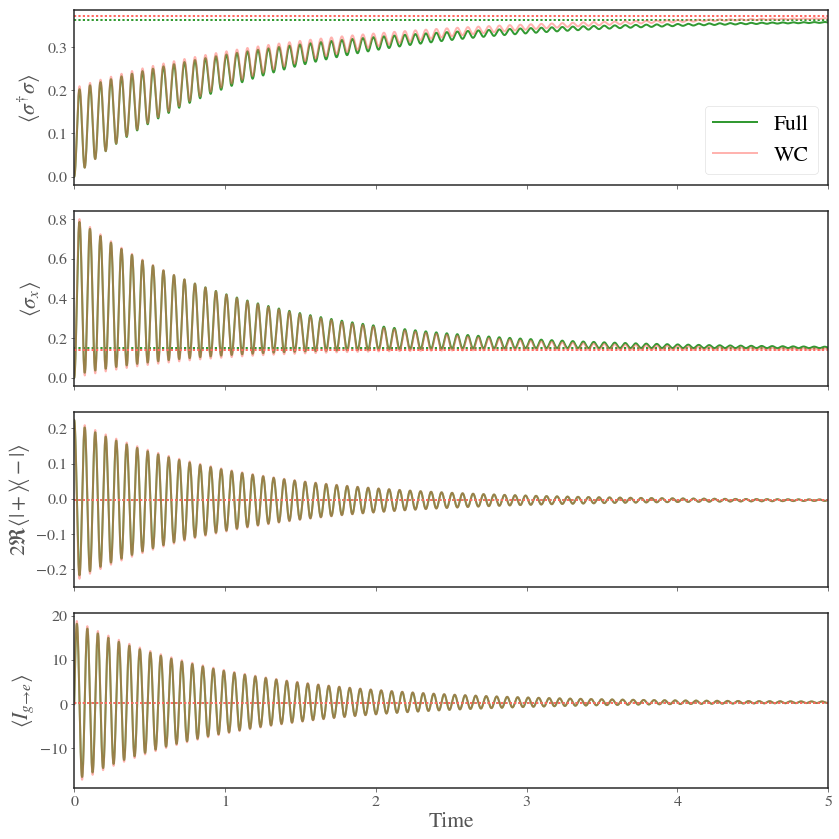

In [103]:
reload(EM)
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.001, alpha=0.0001, 
                                                           Rabi=0.001, w0=0.05, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.005, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 0.080655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=3.20 | Gamma_RC=65.05 | alpha_ph=0.08 | N=9 |
Integral converged to 0.126692577403 with step size of 200.0
Integral converged to 0.0128632913475 with step size of 200.0
Integral converged to -0.332306194615 with step size of 100.0
Integral converged to -0.0283958279321 with step size of 100.0
Integral converged to 0.0964345988441 with step size of 200.0
Integral converged to 0.126692577403 with step size of 200.0
Full:
[[ 0.78521040+0.j          0.28606132+0.00148253j]
 [ 0.28606132-0.00148253j  0.21478960+0.j        ]] 
 Add.:
[[ 0.78551403+0.j          0.28636554+0.00148035j]
 [ 0.28636554-0.00148035j  0.21448597+0.j        ]]
Dynamics complete


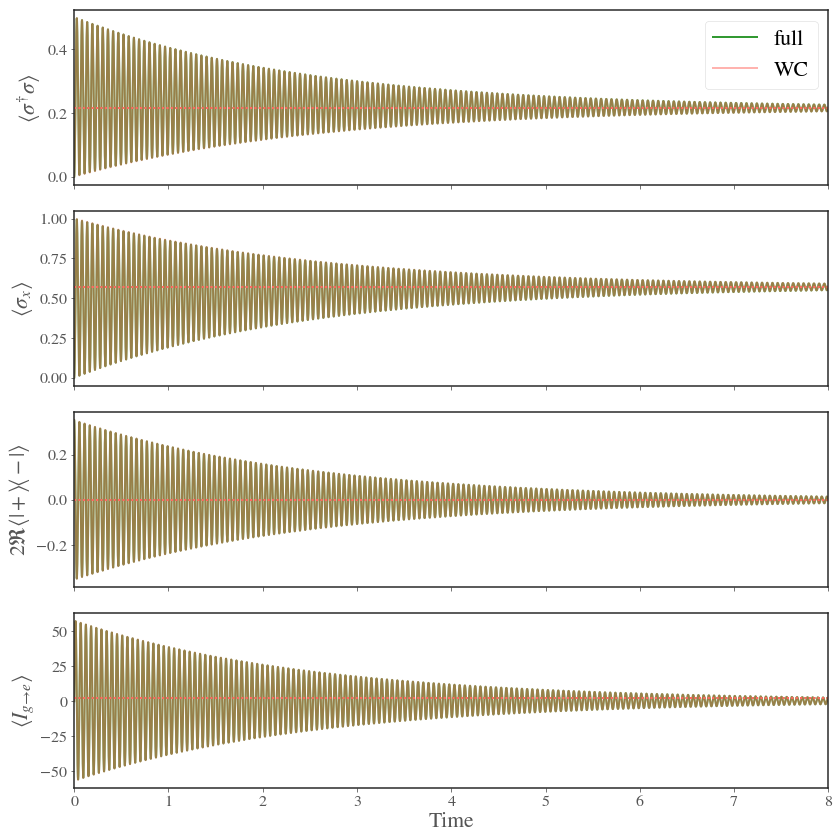

In [104]:

timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.00001, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=8.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.129366232352 with step size of 200.0
Integral converged to -3.33921194716 with step size of 100.0
Integral converged to -0.287706289793 with step size of 100.0
Integral converged to 0.968680486634 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.53478567+0.j          0.04066690+0.00325374j]
 [ 0.04066690-0.00325374j  0.46521433+0.j        ]] 
 Add.:
[[ 0.53255282+0.j          0.03849597+0.00326733j]
 [ 0.03849597-0.00326733j  0.46744718+0.j        ]]
Dynamics complete


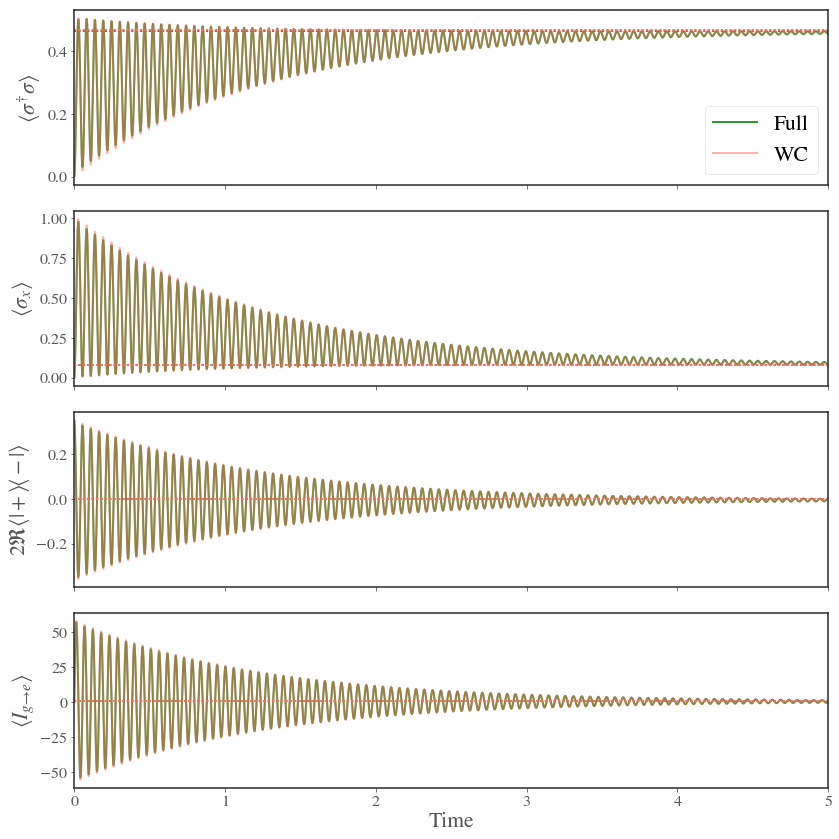

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.       20.16375]
 [ 20.16375 -80.655  ]] Laser 
80.655 0.80655 65.05229025
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=10.11 | Gamma_RC=65.05 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.156282375151 with step size of 200.0
Integral converged to -2.71275524818 with step size of 50.0
Integral converged to -0.42869145595 with step size of 50.0
Integral converged to 1.12134601723 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.63819652+0.j          0.07378651+0.00505085j]
 [ 0.07378651-0.00505085j  0.36180348+0.j        ]] 
 Add.:
[[ 0.62920478+0.j          0.06933265+0.00517266j]
 [ 0.06933265-0.00517266j  0.37079522+0.j        ]]
Dynamics complete


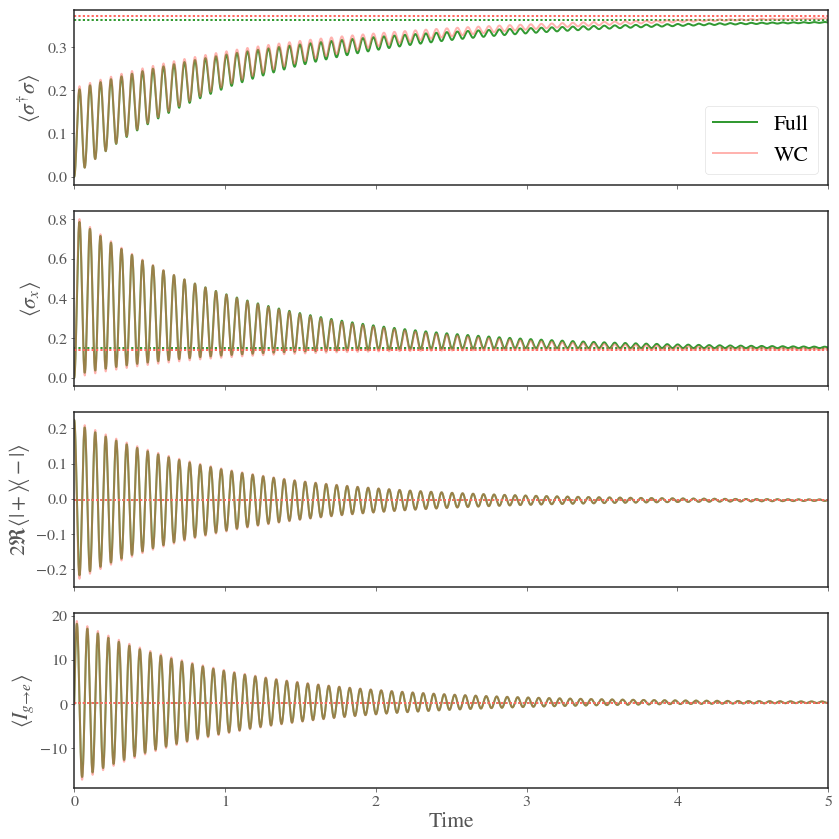

In [105]:

timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.005, w0=0.01, N=9, T_ph=35, tf=5.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
403.275 0.80655 1626.30725625
w_RC=403.275 | RC-res. coupling=0.6418 | TLS-RC coupling=22.60 | Gamma_RC=1626.31 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.0990603255121 with step size of 200.0
Integral converged to 0.841673974517 with step size of 100.0
Integral converged to -0.182787852035 with step size of 100.0
Integral converged to 1.26698240889 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.53024544+0.j          0.03254291+0.00328674j]
 [ 0.03254291-0.00328674j  0.46975456+0.j        ]] 
 Add.:
[[ 0.52786913+0.j          0.03010238+0.00330069j]
 [ 0.03010238-0.00330069j  0.47213087+0.j        ]]
Dynamics complete


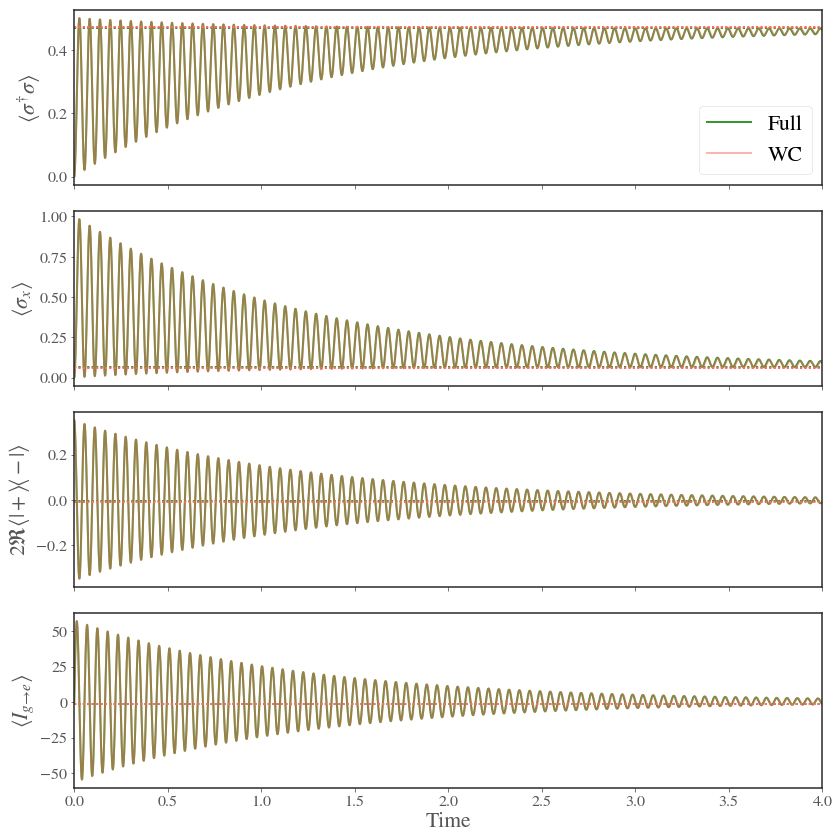

In [106]:
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.01, w0=0.05, N=9, T_ph=35, tf=4.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['Full', 'WC'])

for such a low frequency bath, the coupling has to be incredibly small for weak coupling theory to agree

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
806.55 0.80655 6505.229025
w_RC=806.55 | RC-res. coupling=1.2837 | TLS-RC coupling=31.97 | Gamma_RC=6505.23 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.0982872394613 with step size of 200.0
Integral converged to 0.837945105696 with step size of 100.0
Integral converged to -0.18024201594 with step size of 100.0
Integral converged to 1.29616387047 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.53892690+0.j          0.04127651+0.00322541j]
 [ 0.04127651-0.00322541j  0.46107310+0.j        ]] 
 Add.:
[[ 0.53651169+0.j          0.03874389+0.00323961j]
 [ 0.03874389-0.00323961j  0.46348831+0.j        ]]
Dynamics complete


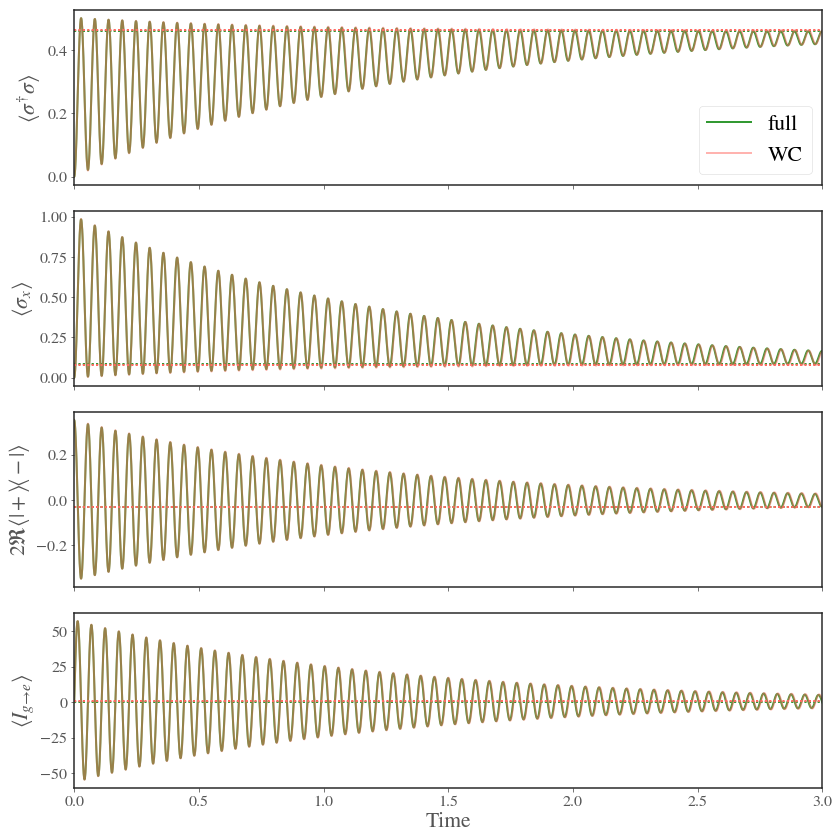

In [107]:
reload(EM)
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.01, alpha=0.0001, 
                                                           Rabi=0.01, w0=0.1, N=9, T_ph=35, tf=3.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275   0.    ]] Laser 
403.275 0.80655 1626.30725625
w_RC=403.275 | RC-res. coupling=0.6418 | TLS-RC coupling=22.60 | Gamma_RC=1626.31 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.130585746626 with step size of 200.0
Integral converged to 1.49464883966 with step size of 50.0
Integral converged to -0.269464563483 with step size of 50.0
Integral converged to 1.46070049948 with step size of 200.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.50005165+0.j         -0.33150991+0.00334207j]
 [-0.33150991-0.00334207j  0.49994835+0.j        ]] 
 Add.:
[[ 0.50008787+0.j         -0.33423673+0.00333995j]
 [-0.33423673-0.00333995j  0.49991213+0.j        ]]
Dynamics complete


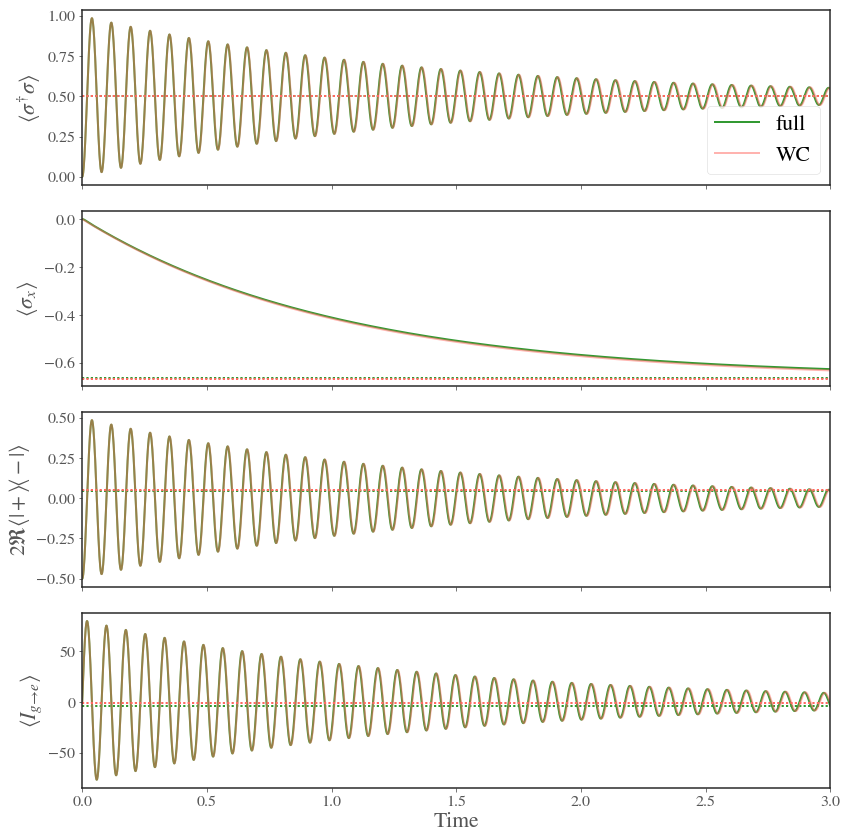

In [108]:
reload(EM)
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.0, alpha=0.0001, 
                                                           Rabi=0.01, w0=0.05, N=9, T_ph=35, tf=3.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['full', 'WC'])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.       4.03275]
 [ 4.03275  0.     ]] Laser 
403.275 0.80655 1626.30725625
w_RC=403.275 | RC-res. coupling=0.6418 | TLS-RC coupling=22.60 | Gamma_RC=1626.31 | alpha_ph=0.81 | N=9 |
Integral converged to 1.26692577704 with step size of 200.0
Integral converged to 0.566939492844 with step size of 100.0
Integral converged to 3.09219350111 with step size of 5.0
Integral converged to 0.238888211237 with step size of 5.0
Integral converged to 2.74981784083 with step size of 100.0
Integral converged to 1.26692577704 with step size of 200.0
Full:
[[ 0.50358875+0.j         -0.05680891+0.03274057j]
 [-0.05680891-0.03274057j  0.49641125+0.j        ]] 
 Add.:
[[ 0.50366250+0.j         -0.05748193+0.03272068j]
 [-0.05748193-0.03272068j  0.49633750+0.j        ]]
Dynamics complete


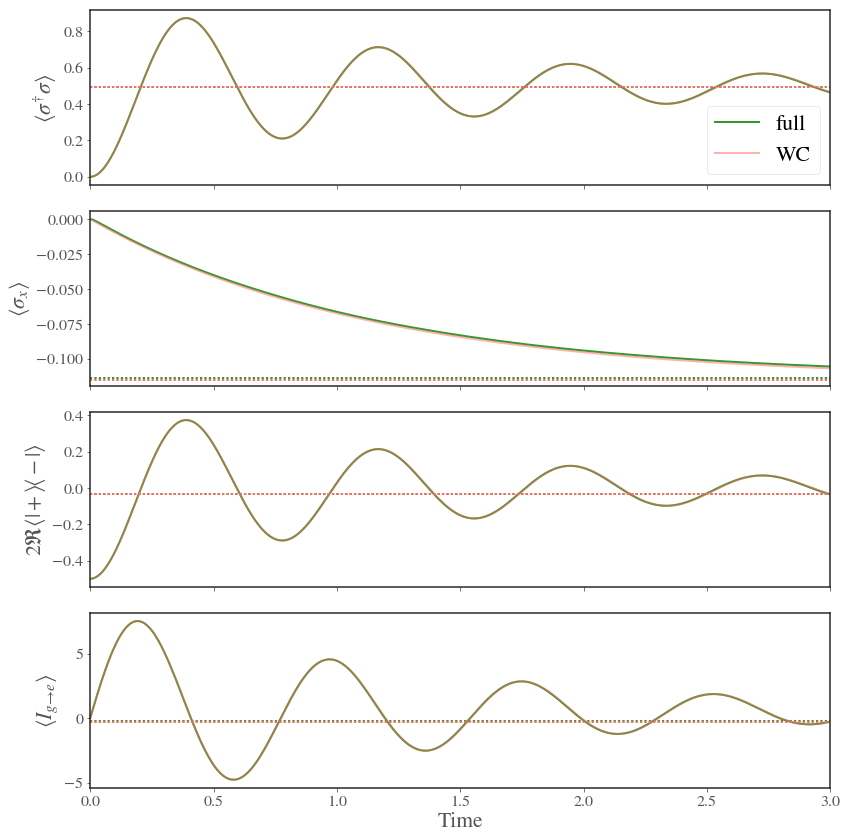

In [109]:
reload(EM)
timelist, data_full, data_wc, L_RC, H, A_ph, A_EM, ss, pars = WC_comparison(detuning=0.0, alpha=0.0001, 
                                                           Rabi=0.001, w0=0.05, N=9, T_ph=35, tf=3.)
plot_dynamics(timelist, data_full, data_wc, A_EM, A_ph, ss, timelength=1, labels = ['full', 'WC'])

# Comparison to Additive theory

## Effect of temperature on small $\omega_0$

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 24.1965 65.05229025
T_ph=35
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=55.37 | Gamma_RC=65.05 | alpha_ph=24.20 | N=9 |
Full:
[[ 0.15651276+0.j         -0.28560277+0.00599476j]
 [-0.28560277-0.00599476j  0.84348724+0.j        ]] 
 Add.:
[[ 0.15619423+0.j       -0.28589813+0.005926j]
 [-0.28589813-0.005926j  0.84380577+0.j      ]]
Dynamics complete


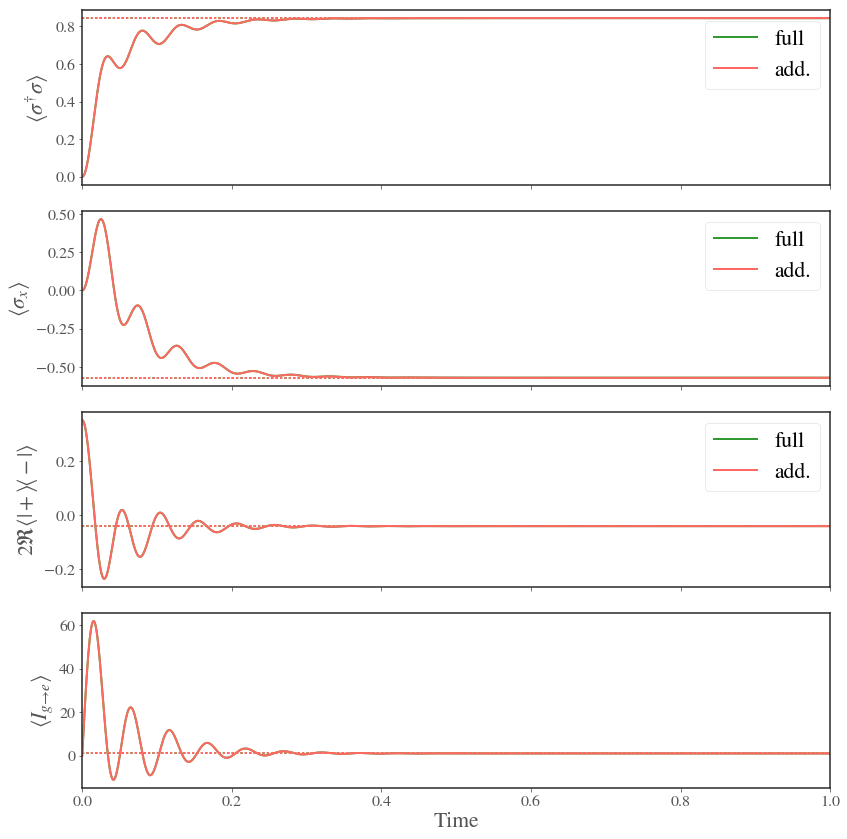

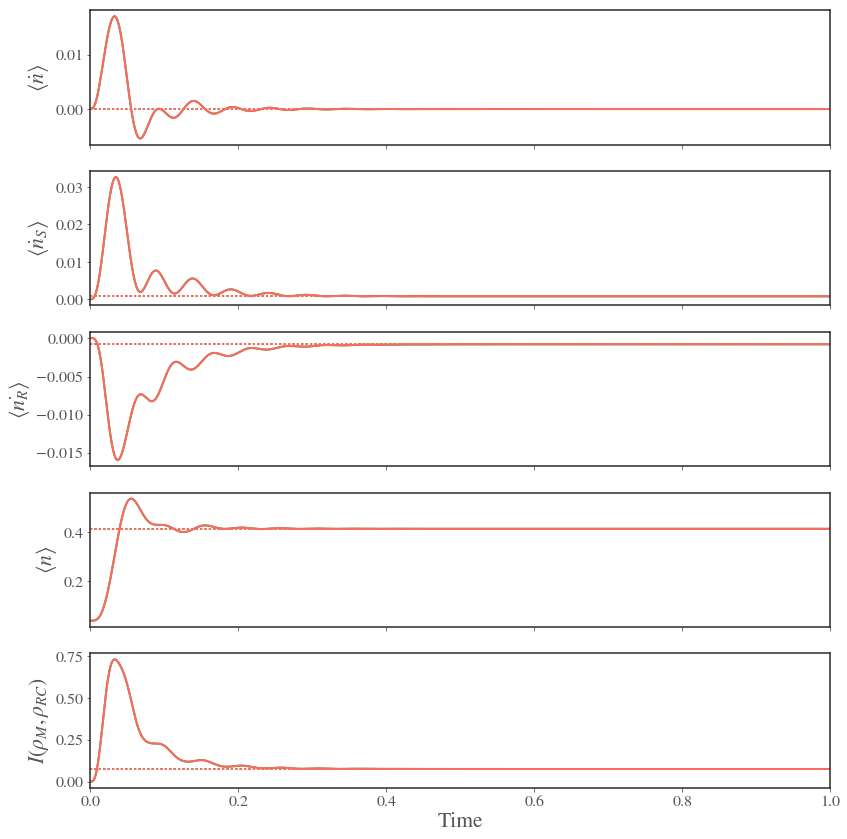

In [349]:
# T = 35K 
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                           Rabi=0.01, w0=0.01, N=9, T_ph=35)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=1)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=1)

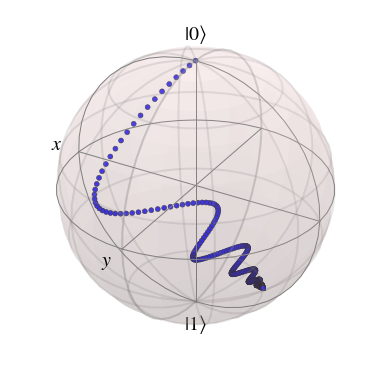

In [320]:
def bloch_plot(data, pars):
    
    sigx = data.expect[1]
    sigy = data.expect[2]/pars[0]
    sigz = data.expect[0]-data.expect[3]
    
    b = qt.Bloch(view=[30, 30])
    b.add_points([sigx, sigy, sigz])
    b.show()
    b.view
bloch_plot(data_full, pars)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
120.9825 24.1965 146.367653063
T_ph=77
w_RC=120.9825 | RC-res. coupling=0.1925 | TLS-RC coupling=67.81 | Gamma_RC=146.37 | alpha_ph=24.20 | N=9 |
Full:
[[ 0.23245059+0.j         -0.24120125+0.00546279j]
 [-0.24120125-0.00546279j  0.76754941+0.j        ]] 
 Add.:
[[ 0.23217665+0.j         -0.24142884+0.00539103j]
 [-0.24142884-0.00539103j  0.76782335+0.j        ]]
Dynamics complete


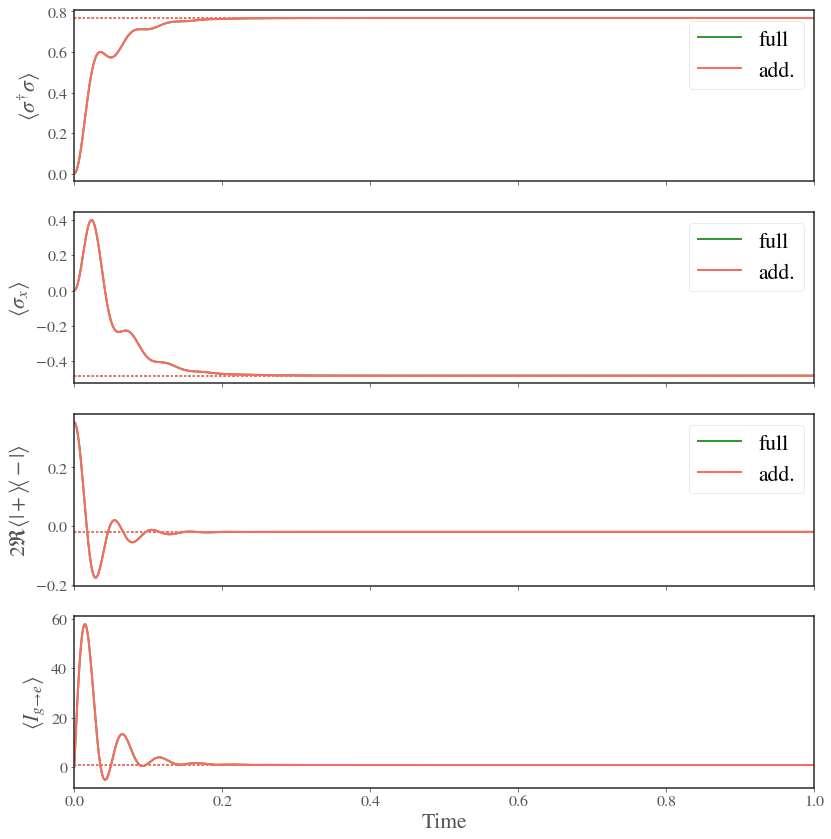

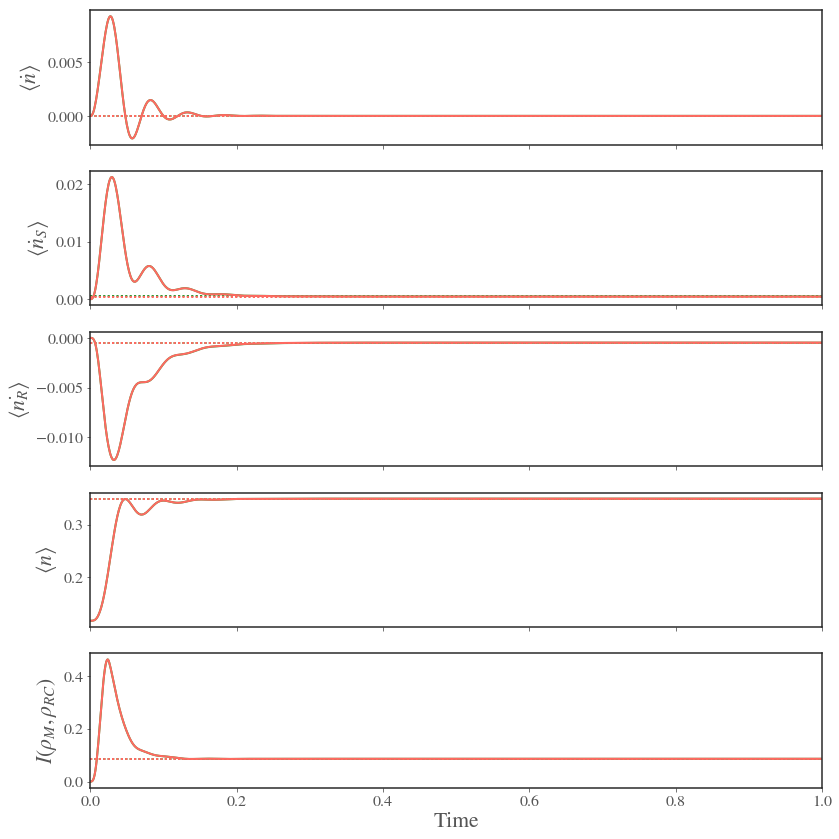

In [350]:
# T = 77K 
reload(EM)
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                                       Rabi=0.01, w0=0.015, N=9, T_ph=77)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=1)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=1)

 I don't know why the phonon currents have the oscillatory behaviour that they do. Nor do I know what the relative scaling factor is. I just need to focus on getting some of this written up now.

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
80.655 24.1965 65.05229025
T_ph=300
w_RC=80.655 | RC-res. coupling=0.1284 | TLS-RC coupling=55.37 | Gamma_RC=65.05 | alpha_ph=24.20 | N=8 |
Full:
[[ 0.42328623+0.j         -0.08646199+0.00411296j]
 [-0.08646199-0.00411296j  0.57671377+0.j        ]] 
 Add.:
[[ 0.42303050+0.j         -0.08660696+0.00404416j]
 [-0.08660696-0.00404416j  0.57696950+0.j        ]]
Dynamics complete


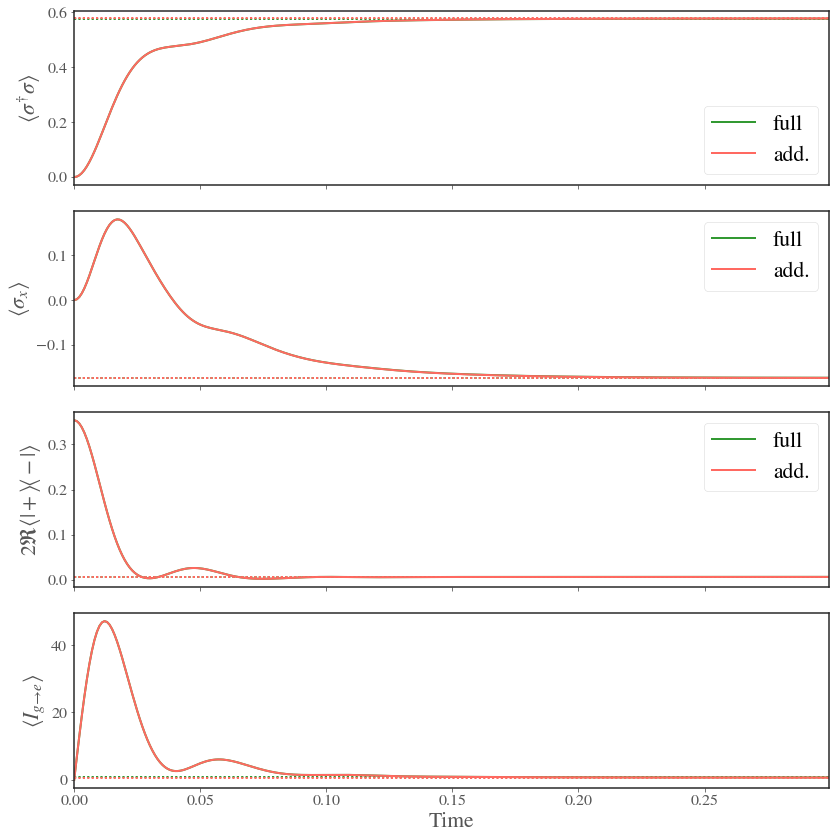

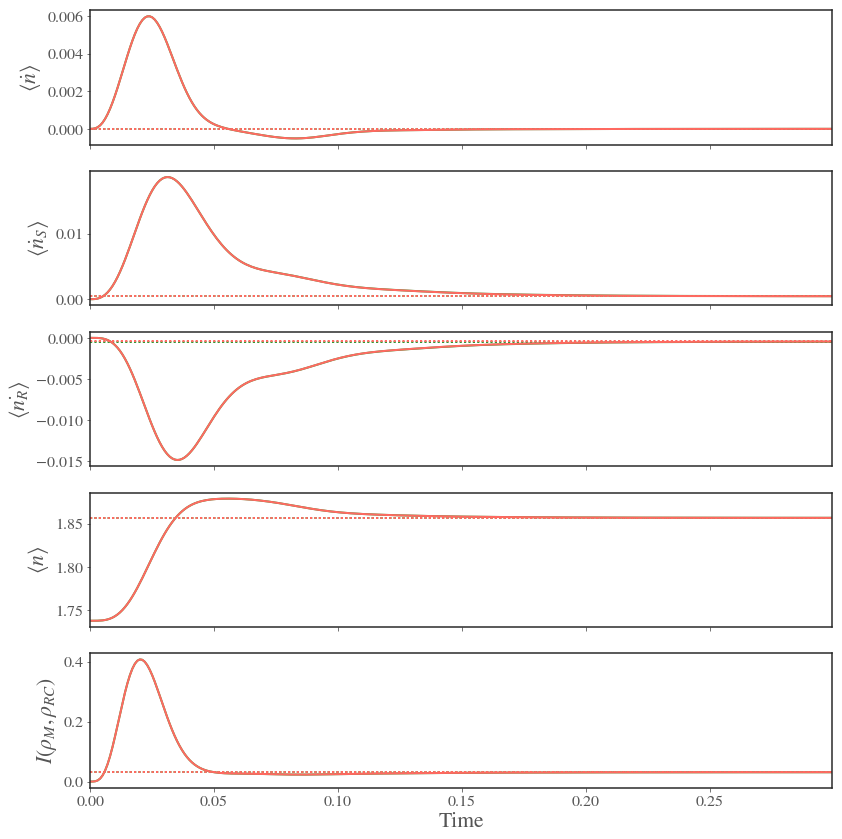

In [351]:
# T = 300K 
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                           Rabi=0.01, w0=0.01, N=8, T_ph=300)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=0.3)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=0.3)

## Temperature on higher $\omega_0$

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
241.965 24.1965 585.47061225
T_ph=77
w_RC=241.965 | RC-res. coupling=0.3851 | TLS-RC coupling=95.90 | Gamma_RC=585.47 | alpha_ph=24.20 | N=8 |
Full:
[[ 0.23737391+0.j        -0.24064155+0.0054265j]
 [-0.24064155-0.0054265j  0.76262609+0.j       ]] 
 Add.:
[[ 0.23696311+0.j        -0.24098665+0.0053575j]
 [-0.24098665-0.0053575j  0.76303689+0.j       ]]
Dynamics complete


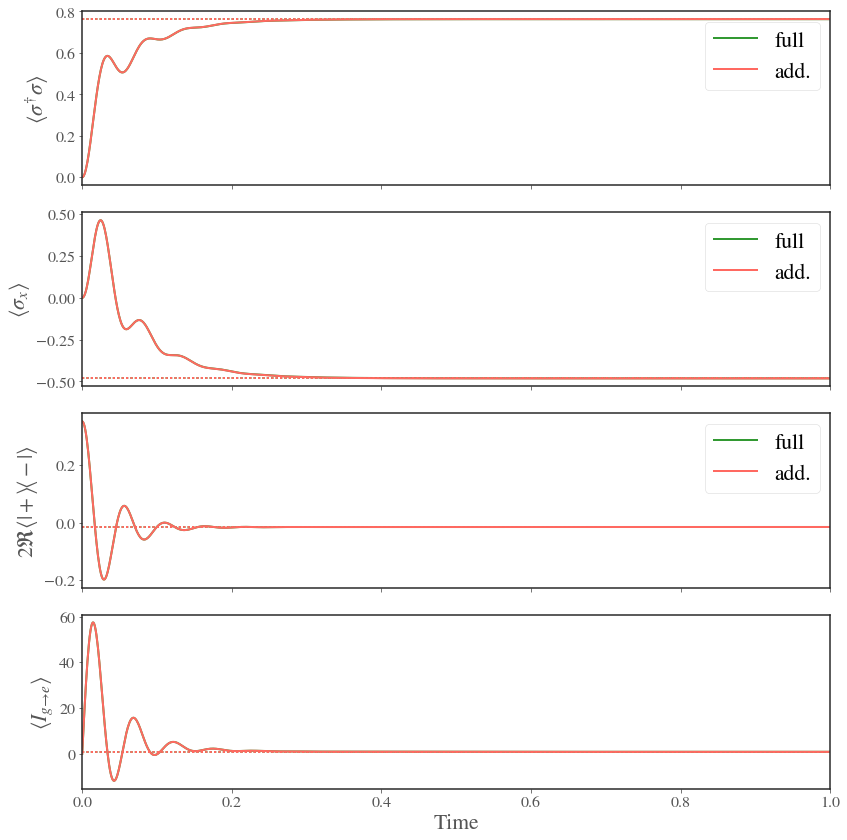

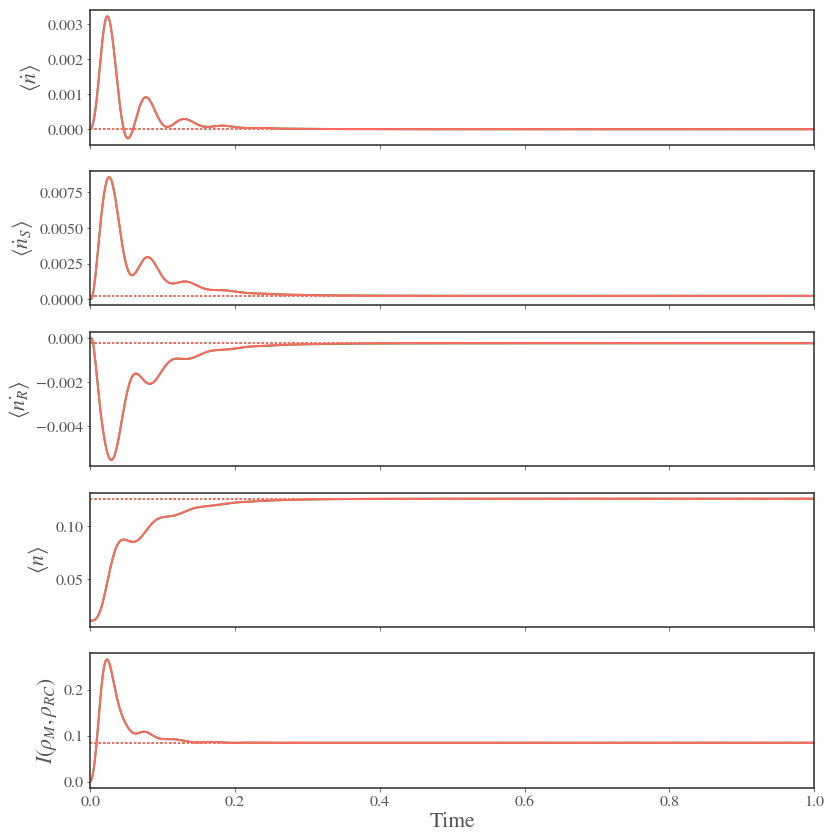

In [352]:
# T = 77K 
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                           Rabi=0.01,w0=0.03, N=8, T_ph=77)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=1)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
241.965 24.1965 585.47061225
T_ph=35
w_RC=241.965 | RC-res. coupling=0.3851 | TLS-RC coupling=95.90 | Gamma_RC=585.47 | alpha_ph=24.20 | N=8 |
Full:
[[ 0.16958498+0.j         -0.29528870+0.00590863j]
 [-0.29528870-0.00590863j  0.83041502+0.j        ]] 
 Add.:
[[ 0.16904448+0.j         -0.29575864+0.00583678j]
 [-0.29575864-0.00583678j  0.83095552+0.j        ]]
Dynamics complete


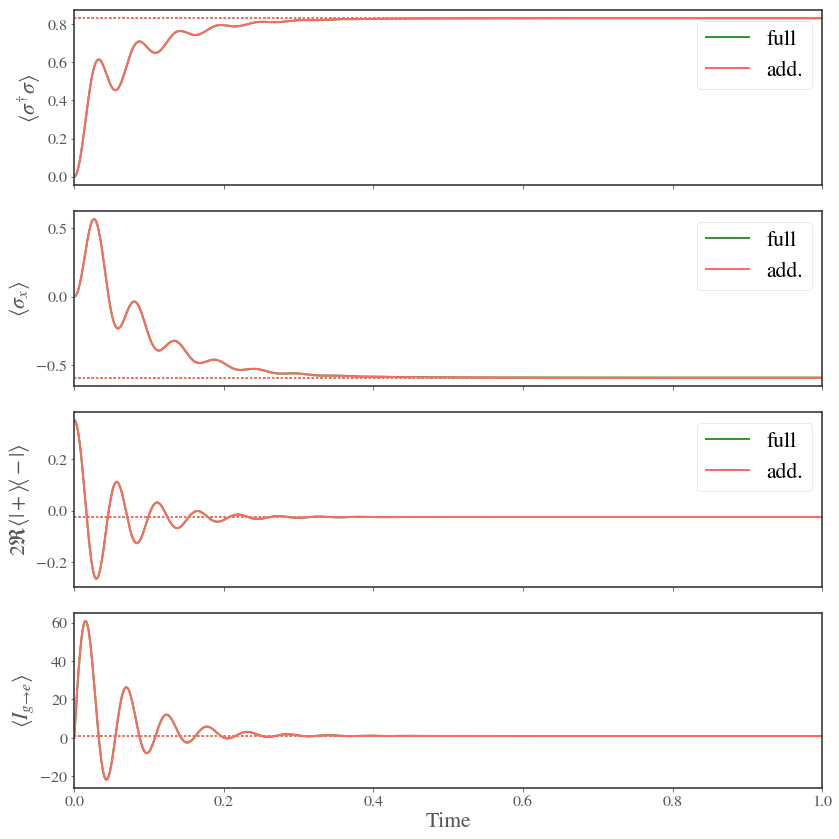

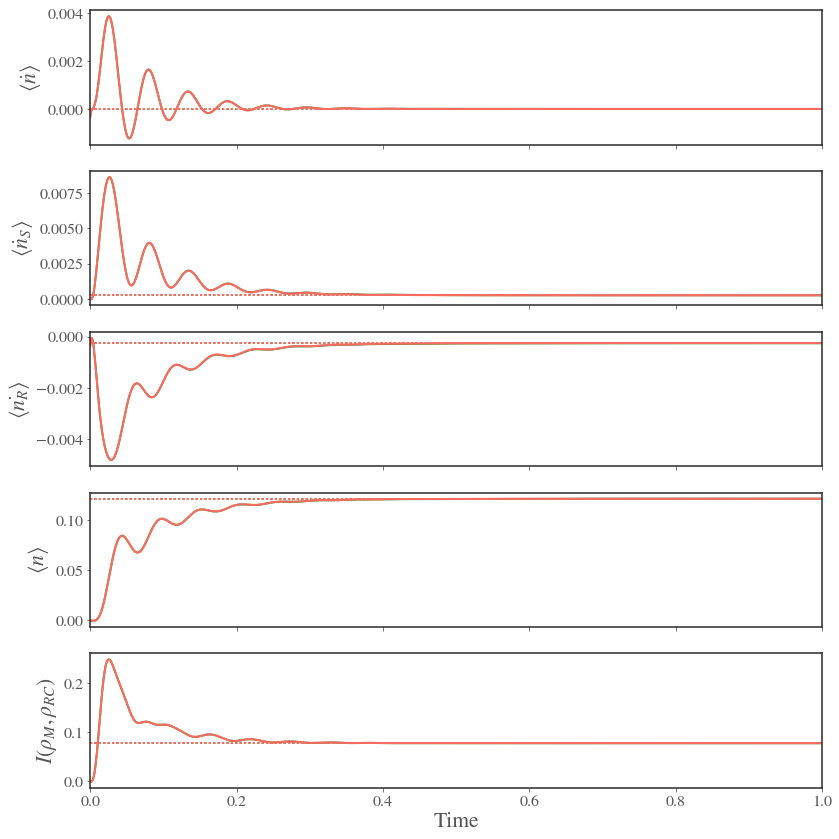

In [353]:
# T = 35K 
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                           Rabi=0.01, w0=0.03, N=8, T_ph=35)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=1)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.      40.3275]
 [ 40.3275 -80.655 ]] Laser 
241.965 24.1965 585.47061225
T_ph=300
w_RC=241.965 | RC-res. coupling=0.3851 | TLS-RC coupling=95.90 | Gamma_RC=585.47 | alpha_ph=24.20 | N=8 |
Full:
[[ 0.41416677+0.j         -0.08672876+0.00419342j]
 [-0.08672876-0.00419342j  0.58583323+0.j        ]] 
 Add.:
[[ 0.41392407+0.j         -0.08686988+0.00410791j]
 [-0.08686988-0.00410791j  0.58607593+0.j        ]]
Dynamics complete


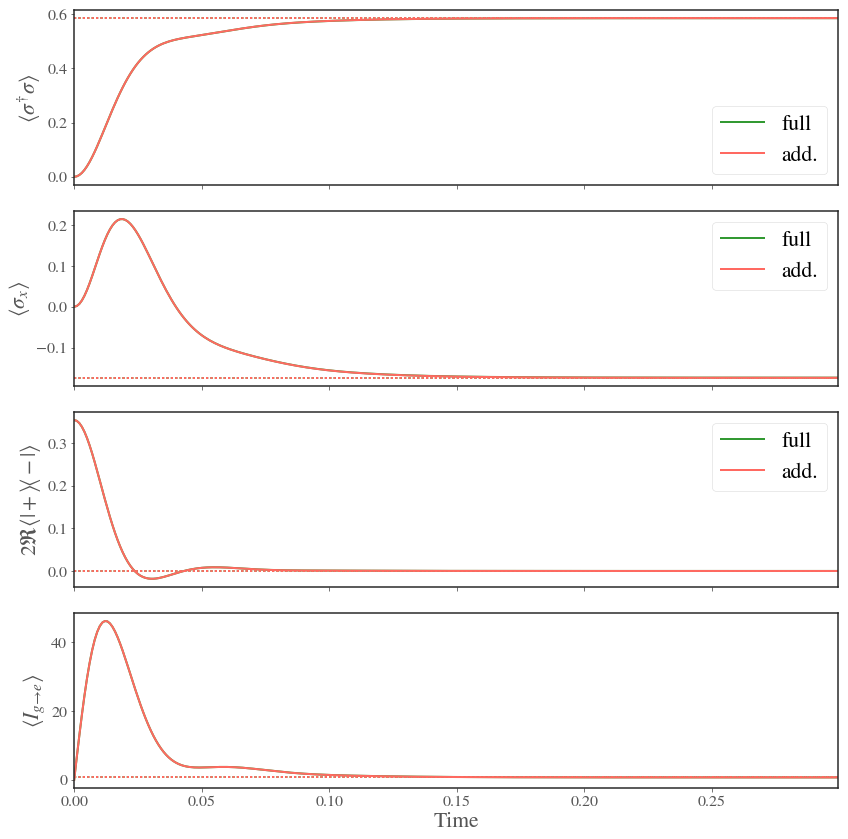

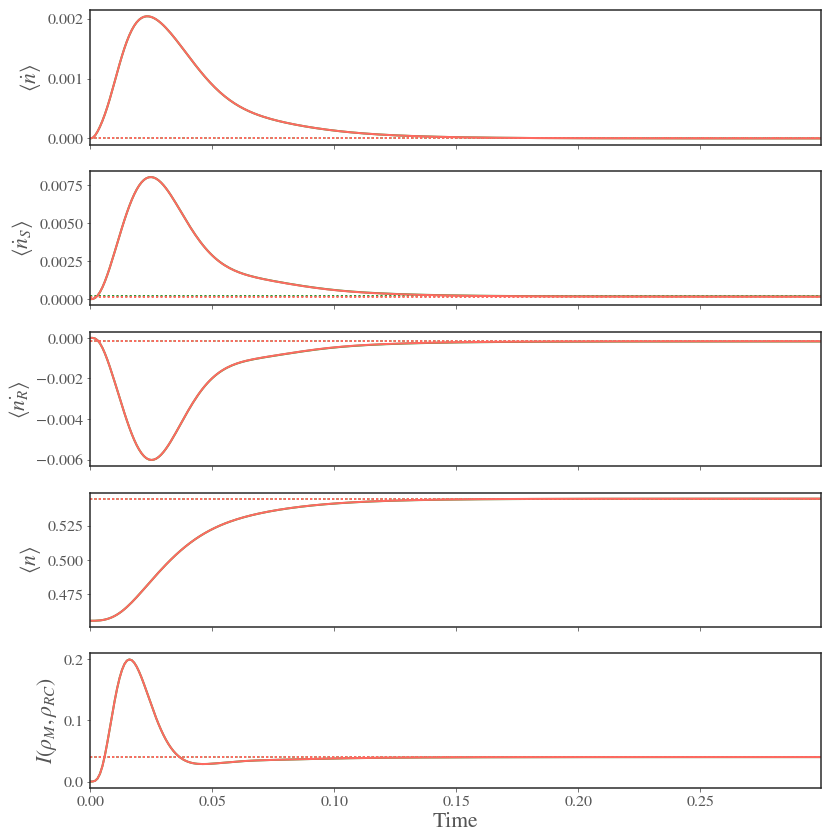

In [354]:
# T = 300K 
timelist, data_full, data_add, L_RC, H, A_ph, A_EM, ss, pars = add_comparison(detuning=0.01, alpha=0.003, 
                                                           Rabi=0.01, w0=0.03, N=8, T_ph=300)
plot_dynamics(timelist, data_full, data_add, A_EM, A_ph, ss, timelength=0.3)
plot_thermo_and_info(timelist, data_full, data_add, L_RC, H, A_ph.dag()*A_ph, ss, timelength=0.3)

In [15]:
def plot_spectra(timelist, pops, taulist, g1s, specs, freqs, g2s,
                freq_window=1000., tau_window=2., dyn_window_div = 7.):
    plt.close('all')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(14,12))
    #f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    #f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    label = ['Full', 'Naive']
    ls = ['dashed', 'solid']
    for i, spec in enumerate(specs):
        g_1  = g1s[i]
        freq = freqs[i]
        ax1.plot(timelist, pops[i],
                label=label[i], linestyle=ls[i])
        ax3.plot(taulist[0:int(len(taulist)/tau_window)],
                 g_1.real[0:int(len(taulist)/tau_window)], 
                 label=label[i], linestyle=ls[i])
        #ax4.plot(taulist[0:int(len(taulist)/tau_window)],
        #         g_1.imag[0:int(len(taulist)/tau_window)], 
        #         label=label[i], linestyle=ls[i])
        ax4.plot(timelist, g2s[i], label=label[i], linestyle=ls[i])
        ax2.plot(freq, spec, label=label[i], linestyle=ls[i])
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax3.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    ax4.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    if freq_window is not None:
        ax2.set_xlim(-freq_window,freq_window)

    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g^{(1)}(\tau)]$") # coherence
    #ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$g^{(2)}_{ss}(\tau)$") # coherence
    ax3.set_xlabel(r"$\tau$")
    #ax4.set_xlabel(r"$\tau$") # if lower right is imag part of g1
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

# First order coherence function and emission spectra

In [113]:
method = 'adams'
order = 12
reload(EM)

def RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC, 
                steps_per_tau=500.,nsteps=4000, tau_f=2., label='Full'):
    options = qt.Options(nsteps=nsteps, store_states=True)
    E_op = sigma_RC.dag()*sigma_RC
    ti = time.time()
    dat = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[E_op], options=options)
    pop = dat.expect[0]
    P = dat.states
    
    print "Completed initial dynamics calculations for {} in {}  seconds.".format(label, time.time()-ti)
    ti = time.time()
    Lambda_0 = sigma_RC*sum(P)
    del P, dat
    Lambda_t = mesolve(H, Lambda_0, taulist, [L], options=options, progress_bar=None)

    g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
    g_1/=abs(g_1[0])

    spec = sp.fftpack.fft(g_1)
    dt = taulist[1]-taulist[0]
    freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
    spec = 2 * dt* np.real(spec)
    #freq, spec = qt.spectrum_correlation_fft(taulist, g_1) # old method
    spec-= min(spec)
    spec = spec/sum(spec)
    freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))
    print "Completed correlation function calculations for {} in {} seconds.".format(label, time.time()-ti)
    return pop, g_1, spec, freq

# Second order coherence functions

In [222]:
def coherence_2nd_order_ss(H, tlist, c_ops, sigma, rho0=None):
    """
    Calculate the correlation function <sigma_dag(0)sigma_dag(tau)sigma(tau)sigma(0)>

    (ss_gtt = steadystate general two-time)
    
    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental. 
    """
    ti = time.time()
    if rho0 == None:
        rho0 = steadystate(H, c_ops)
    dat = mesolve(H, sigma * rho0 * sigma.dag(), tlist, c_ops, [sigma.dag() * sigma]).expect[0]
    print "G2 took {:0.3f} seconds".format(time.time()-ti)
    return dat

In [269]:
reload(EM)
        

def RF_data(detuning=0., alpha=0.001, Rabi=1., w0=0.01, Gamma=20., T_ph=77.,
            t_f=4., steps_per_tau=500., steps_per_t=900, tau_f=2., overdamped=True, nsteps=3000):
    Gamma_EM =  1 #1*5.309e-3
    detuning = detuning*Gamma_EM #detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1000. #1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*Gamma_EM #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*Gamma_EM
    Gamma = 10.
    #if overdamped:
    #    Gamma = (w0**2)/100.
    alpha_ph = alpha*Gamma_EM
    print "Alpha: {}, Rabi: {}, w_laser: {}, detuning: {}, Gamma: {}, w0: {}, Gamma_EM: {}".format(alpha_ph, Rabi, w_laser, 
                                                                                detuning, Gamma, w0, Gamma_EM)
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    
    
    J = J_multipolar
    
    kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    shift = ((kappa**2)/w0)
    #w_laser += shift
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print "Driven Hamiltonian: \n", H_sub.full()
    n_RC = Occupation(w0, T_ph)
    
    
    #print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    
    if abs(alpha)>0:
        N = 7
        I = qeye(N)
        L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T_ph, Gamma, w0, 
                                                                          alpha_ph, N, 
                                                                          silent=True, w_laser=w_laser)
        H_add = tensor(H_sub, I)
        E_op = tensor(E*E.dag(), I) # population operator
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        sigma_RC = tensor(sigma, I)
        
    else:
        L_RC, H, A_EM = 0, H_sub, sigma
        H_add = H_sub
        E_op = E*E.dag() # population operator
        rho_0 = initial_sys
        sigma_RC = sigma
    
    labels = ['Full', 'Naive']
    L_full = EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    L_add =  EM.L_nonsecular(H_add, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
    L_EM_list = [L_full, L_add]
    #final_t = end_T_mult/Gamma_EM
    #print "final t: ", final_t
    #timelist = np.linspace(0, final_t, int(T_increments*final_t))
    timelist = np.linspace(0, t_f, t_f*steps_per_t)
    taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
    pop_list = []
    g1_data = []
    spectrum_data = []
    freq_data = []
    g2_data = []
    for i, L_EM in enumerate(L_EM_list):
        L = L_RC + L_EM
        ss = steadystate(H, [L])
        print "Steadystate: \n", ss.ptrace(0).full()
        pop, g1, spec, freq = RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC,
                                      nsteps=nsteps, tau_f=tau_f, label=labels[i])
        g2 = coherence_2nd_order_ss(H, timelist, [L], sigma_RC, rho0=ss)
        pop_list.append(pop)
        g1_data.append(g1)
        spectrum_data.append(spec)
        freq_data.append(freq)
        norm_den = ((ss*sigma_RC.dag()*sigma_RC).tr()**2).real
        g2_data.append(g2/norm_den)
    
    expects = [G*G.dag(), E*E.dag(), E*G.dag()+G*E.dag(), #0, 1, 2
                      1j*Rabi*(G*E.dag()-E*G.dag()), # 3, TLS current
                      real_exciton, imag_exciton] # 4, 5
        
    shift = 0.5*pi*alpha_ph
    H_sub = H_sub + shift*E*E.dag()

    L_wc = weak_phonon(H_sub, alpha=alpha_ph, 
                       w_0=w0, Gamma=Gamma, T=T_ph)
    L_wc += EM.L_nonsecular(H_sub, sigma, epsilon, Gamma_EM, T_EM, J, 
                            silent=True, w_laser=w_laser)
    rho_0 = initial_sys
    data.append(mesolve(H_sub, rho_0, timelist, c_ops=[L_wc], e_ops=expects, options=options))  
    
    
    print "All spectra calculated."
    return timelist, pop_list, taulist, g1_data, spectrum_data, freq_data, g2_data



# No phonons

Alpha: 0, Rabi: 1.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
Steadystate: 
[[ 0.66683342+0.j          0.00000000+0.33366683j]
 [ 0.00000000-0.33366683j  0.33316658+0.j        ]]
Completed initial dynamics calculations for Full in 2.81365990639  seconds.
Completed correlation function calculations for Full in 3.1758711338 seconds.
G2 took 0.162 seconds
Steadystate: 
[[ 0.66683342+0.j          0.00000000+0.33366683j]
 [ 0.00000000-0.33366683j  0.33316658+0.j        ]]
Completed initial dynamics calculations for Naive in 2.33737301826  seconds.
Completed correlation function calculations for Naive in 3.26712679863 seconds.
G2 took 0.161 seconds
All spectra calculated.


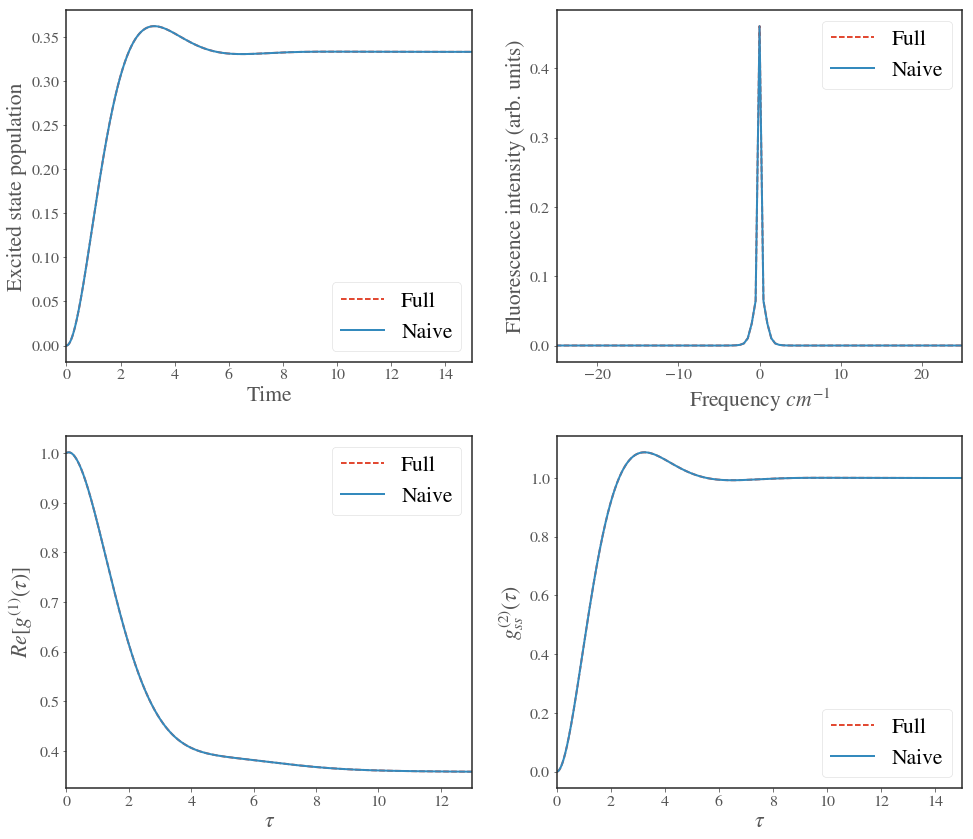

Alpha: 0, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.50252506+0.j          0.00000000+0.05050119j]
 [ 0.00000000-0.05050119j  0.49747494+0.j        ]]
Completed initial dynamics calculations for Full in 2.38681507111  seconds.
Completed correlation function calculations for Full in 2.83924198151 seconds.
G2 took 0.169 seconds
Steadystate: 
[[ 0.50252506+0.j          0.00000000+0.05050119j]
 [ 0.00000000-0.05050119j  0.49747494+0.j        ]]
Completed initial dynamics calculations for Naive in 2.41909694672  seconds.
Completed correlation function calculations for Naive in 3.51594114304 seconds.
G2 took 0.242 seconds
All spectra calculated.


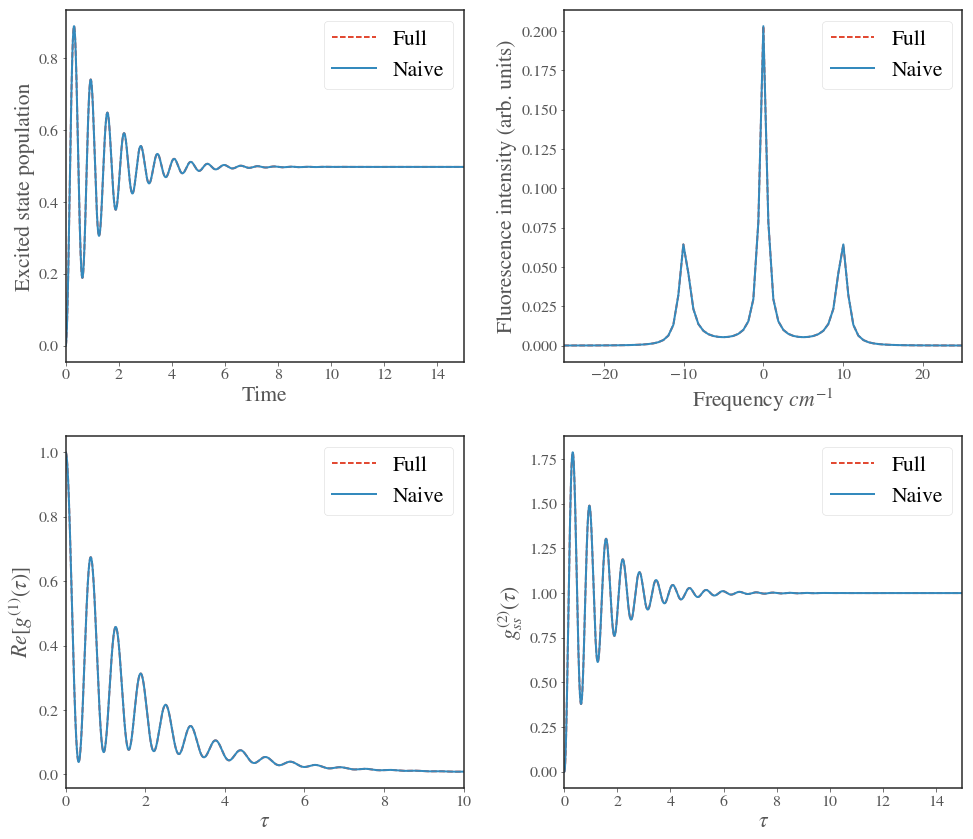

Alpha: 0, Rabi: 1.0, w_laser: 1010.0, detuning: 10.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
[[  0.0+0.j   0.5+0.j]
 [  0.5+0.j -10.0+0.j]]
Steadystate: 
[[ 0.99751938+0.j          0.04961633+0.00255616j]
 [ 0.04961633-0.00255616j  0.00248062+0.j        ]]
Completed initial dynamics calculations for Full in 3.35367512703  seconds.
Completed correlation function calculations for Full in 4.47634792328 seconds.
G2 took 0.219 seconds
Steadystate: 
[[ 0.99751938+0.j          0.04961633+0.00255616j]
 [ 0.04961633-0.00255616j  0.00248062+0.j        ]]
Completed initial dynamics calculations for Naive in 3.06594586372  seconds.
Completed correlation function calculations for Naive in 3.25688195229 seconds.
G2 took 0.189 seconds
All spectra calculated.


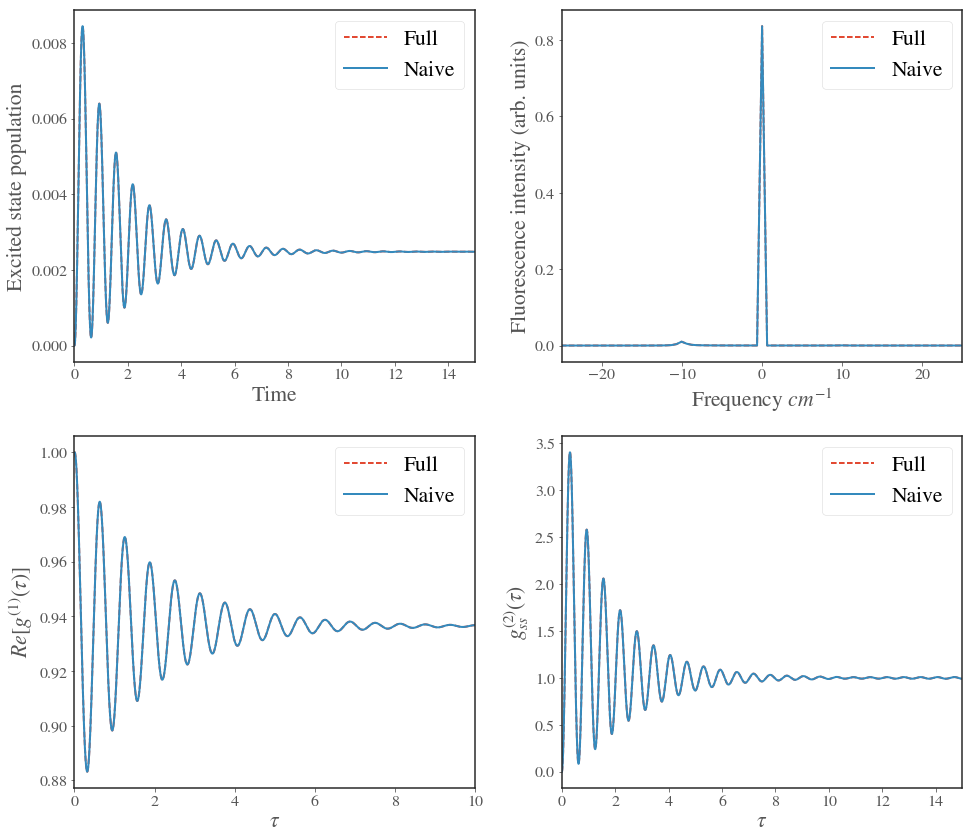

Alpha: 0, Rabi: 10.0, w_laser: 1010.0, detuning: 10.0, Gamma: 10.0, w0: 0.01, Gamma_EM: 1
Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -10.+0.j]]
Steadystate: 
[[ 0.83364333+0.j          0.33273196+0.01732225j]
 [ 0.33273196-0.01732225j  0.16635667+0.j        ]]
Completed initial dynamics calculations for Full in 3.17945098877  seconds.
Completed correlation function calculations for Full in 3.59736394882 seconds.
G2 took 0.198 seconds
Steadystate: 
[[ 0.83364333+0.j          0.33273196+0.01732225j]
 [ 0.33273196-0.01732225j  0.16635667+0.j        ]]
Completed initial dynamics calculations for Naive in 3.33321094513  seconds.
Completed correlation function calculations for Naive in 3.92162704468 seconds.
G2 took 0.240 seconds
All spectra calculated.


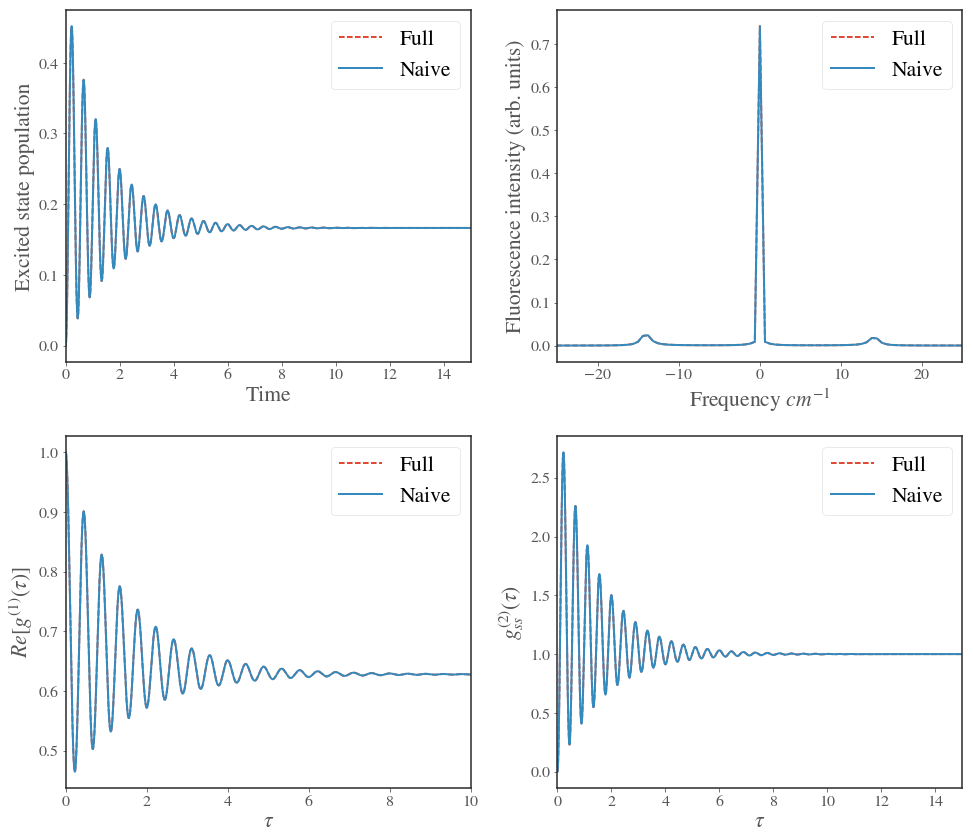

In [270]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=13.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=10., 
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=10.,
                                                                             t_f=15, steps_per_tau=500,
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

Alpha: 5.0, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 15, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.60513629+0.j         -0.04306876+0.04178621j]
 [-0.04306876-0.04178621j  0.39486371+0.j        ]]
Completed initial dynamics calculations for Full in 4.21217894554  seconds.
Completed correlation function calculations for Full in 2.72055006027 seconds.
G2 took 1.516 seconds
Steadystate: 
[[ 0.60146925+0.j         -0.04316373+0.04045687j]
 [-0.04316373-0.04045687j  0.39853075+0.j        ]]
Completed initial dynamics calculations for Naive in 4.36045217514  seconds.
Completed correlation function calculations for Naive in 2.59586215019 seconds.
G2 took 1.271 seconds
All spectra calculated.


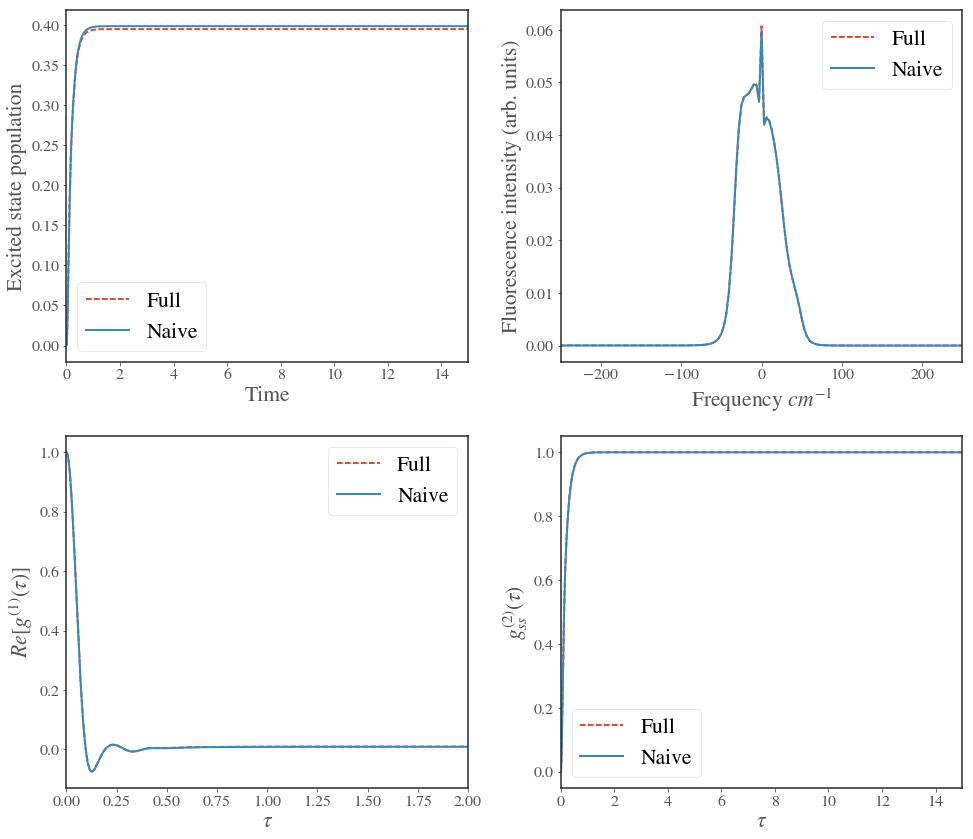

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 20, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.60187157+0.j         -0.04478994+0.04232969j]
 [-0.04478994-0.04232969j  0.39812843+0.j        ]]
Completed initial dynamics calculations for Full in 4.64680099487  seconds.
Completed correlation function calculations for Full in 2.72209310532 seconds.
G2 took 1.031 seconds
Steadystate: 
[[ 0.59805303+0.j         -0.04484988+0.04080367j]
 [-0.04484988-0.04080367j  0.40194697+0.j        ]]
Completed initial dynamics calculations for Naive in 4.05975079536  seconds.
Completed correlation function calculations for Naive in 2.54902410507 seconds.
G2 took 0.913 seconds
All spectra calculated.


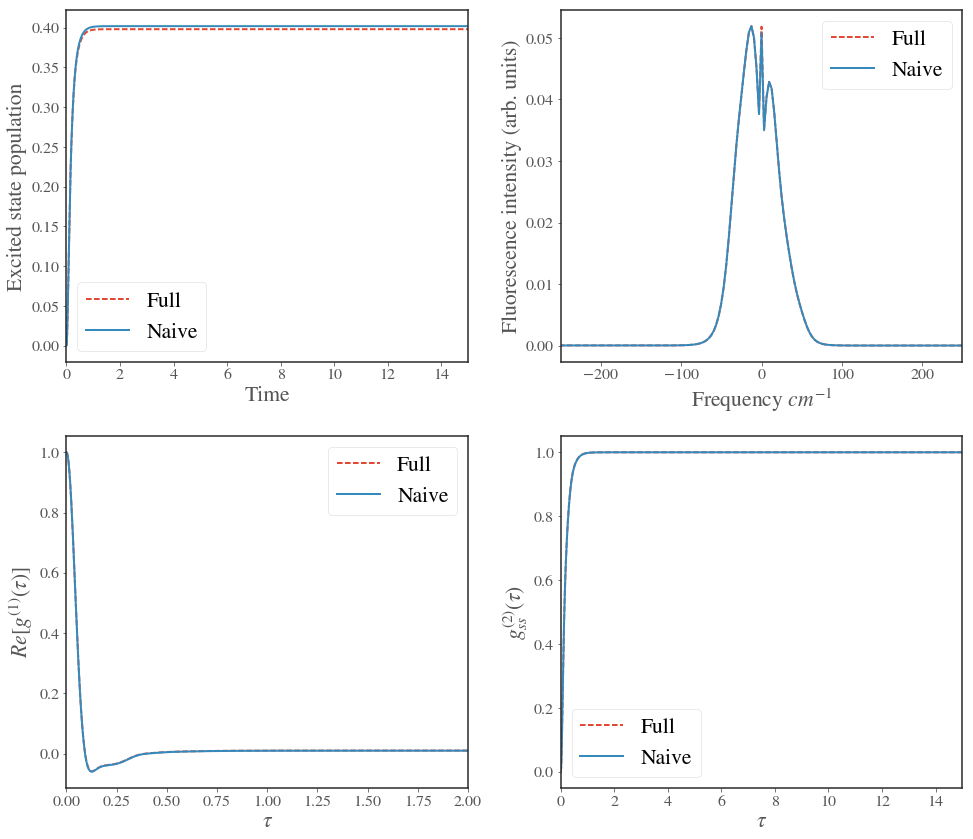

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 25, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.59588741+0.j         -0.04404057+0.04304118j]
 [-0.04404057-0.04304118j  0.40411259+0.j        ]]
Completed initial dynamics calculations for Full in 4.03971886635  seconds.
Completed correlation function calculations for Full in 2.46122503281 seconds.
G2 took 0.928 seconds
Steadystate: 
[[ 0.59207185+0.j         -0.04410148+0.04141085j]
 [-0.04410148-0.04141085j  0.40792815+0.j        ]]
Completed initial dynamics calculations for Naive in 3.21066403389  seconds.
Completed correlation function calculations for Naive in 2.19584298134 seconds.
G2 took 0.804 seconds
All spectra calculated.


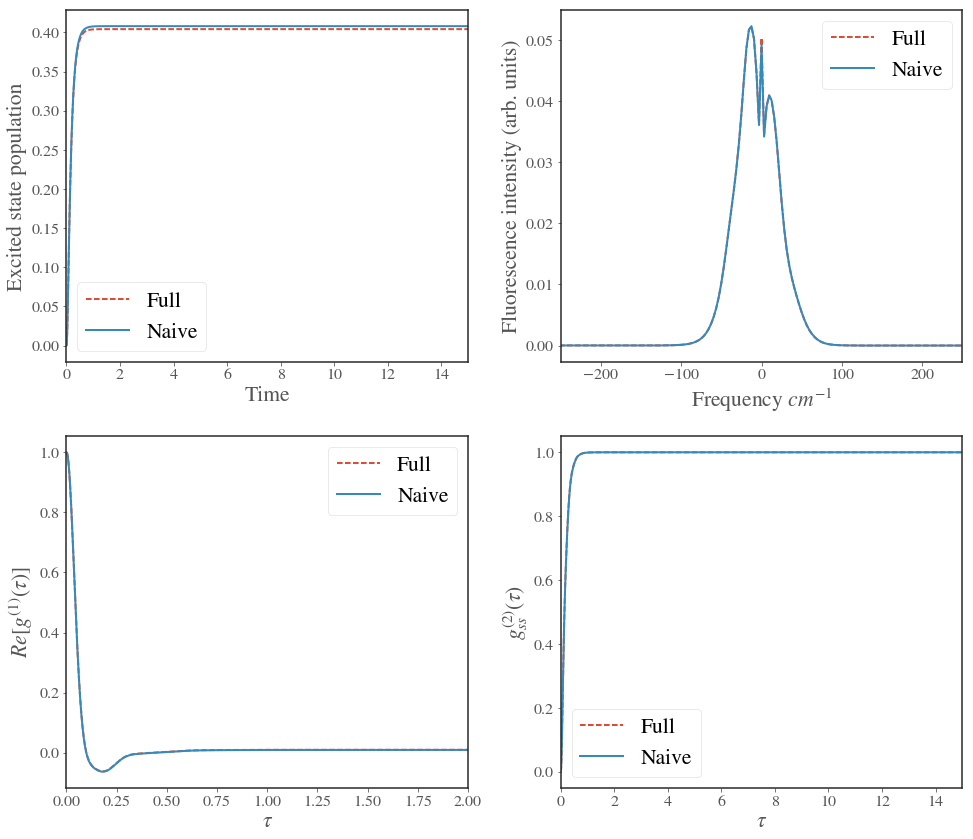

Alpha: 5, Rabi: 10.0, w_laser: 1000.0, detuning: 0.0, Gamma: 10.0, w0: 30, Gamma_EM: 1
Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
Steadystate: 
[[ 0.58072435+0.j        -0.04413903+0.0446596j]
 [-0.04413903-0.0446596j  0.41927565+0.j       ]]
Completed initial dynamics calculations for Full in 3.10691094398  seconds.
Completed correlation function calculations for Full in 2.99224901199 seconds.
G2 took 1.217 seconds
Steadystate: 
[[ 0.57726540+0.j         -0.04416321+0.04291392j]
 [-0.04416321-0.04291392j  0.42273460+0.j        ]]
Completed initial dynamics calculations for Naive in 4.09523582458  seconds.
Completed correlation function calculations for Naive in 3.01611709595 seconds.
G2 took 0.739 seconds
All spectra calculated.


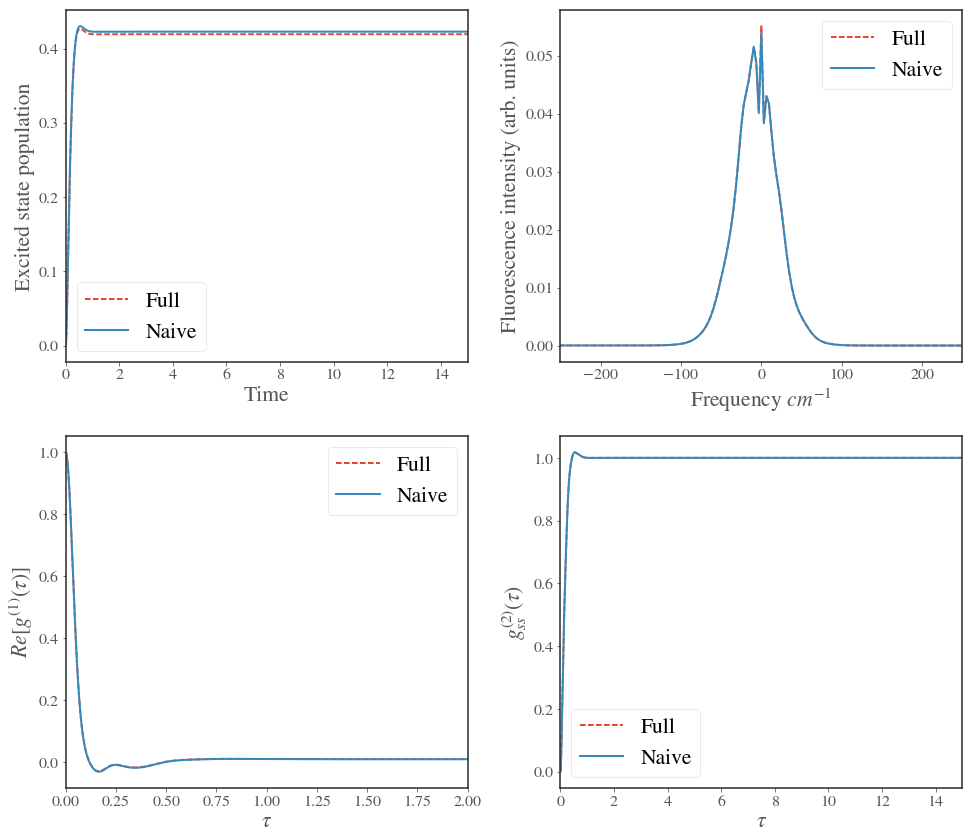

In [272]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5., Rabi=10., w0=15,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
             freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=20,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=25,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=5, Rabi=10., w0=30,
                                                                             t_f=15, tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

# Mollow regime

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.297214984894  seconds to build the Non-secular RWA Liouvillian
It took  0.110357999802  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.52933857+0.j         -0.08660900+0.02135692j]
 [-0.08660900-0.02135692j  0.47066143+0.j        ]]
Completed initial dynamics calculations for Full in 1.04757094383  seconds.
Completed correlation function calculations for Full in 1.40378785133 seconds.
G2 took 0.345 seconds
All spectra calculated.


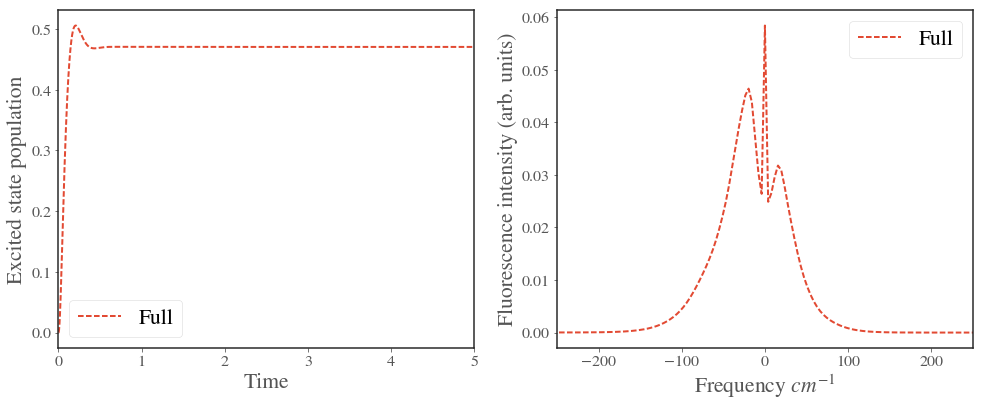

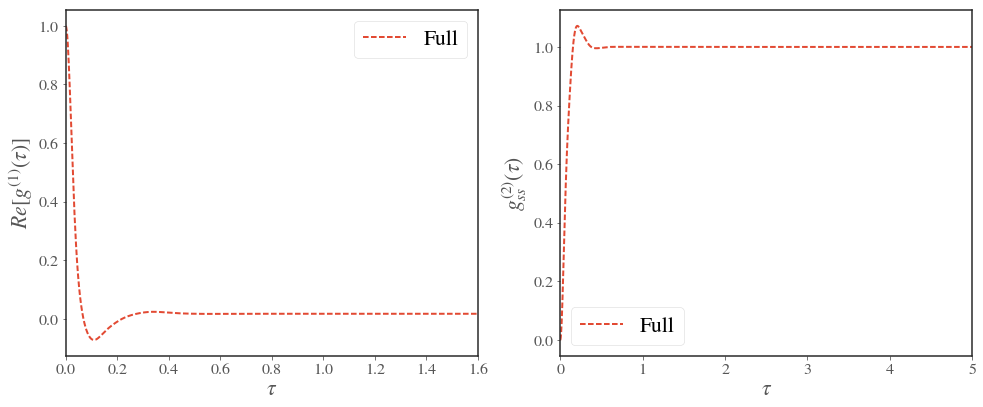

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.275485038757  seconds to build the Non-secular RWA Liouvillian
It took  0.108073949814  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63472803+0.j         -0.07346119+0.01420677j]
 [-0.07346119-0.01420677j  0.36527197+0.j        ]]
Completed initial dynamics calculations for Full in 1.28875184059  seconds.
Completed correlation function calculations for Full in 0.905956983566 seconds.
G2 took 0.184 seconds
All spectra calculated.


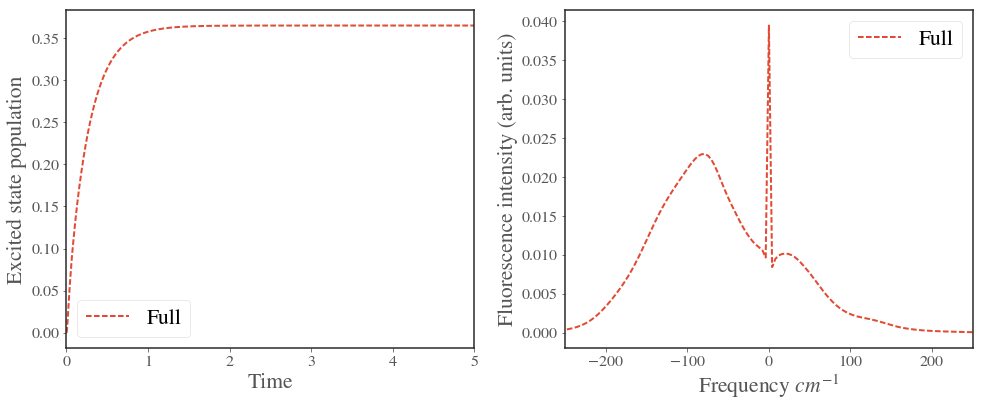

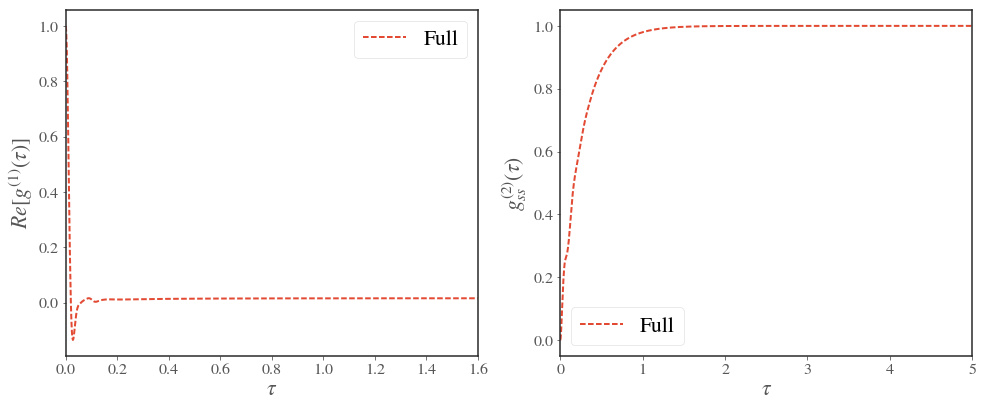

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.243406057358  seconds to build the Non-secular RWA Liouvillian
It took  0.112782001495  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.55218586+0.j         -0.08371705+0.02042897j]
 [-0.08371705-0.02042897j  0.44781414+0.j        ]]
Completed initial dynamics calculations for Full in 1.07741498947  seconds.
Completed correlation function calculations for Full in 0.840218067169 seconds.
G2 took 0.345 seconds
All spectra calculated.


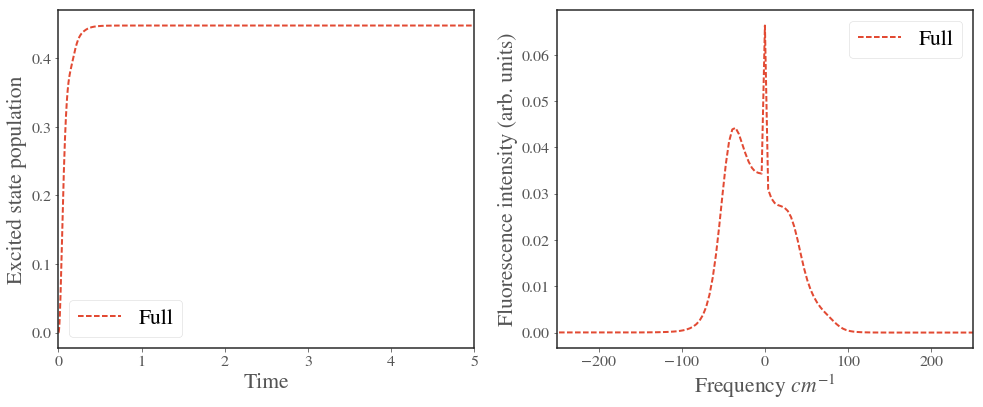

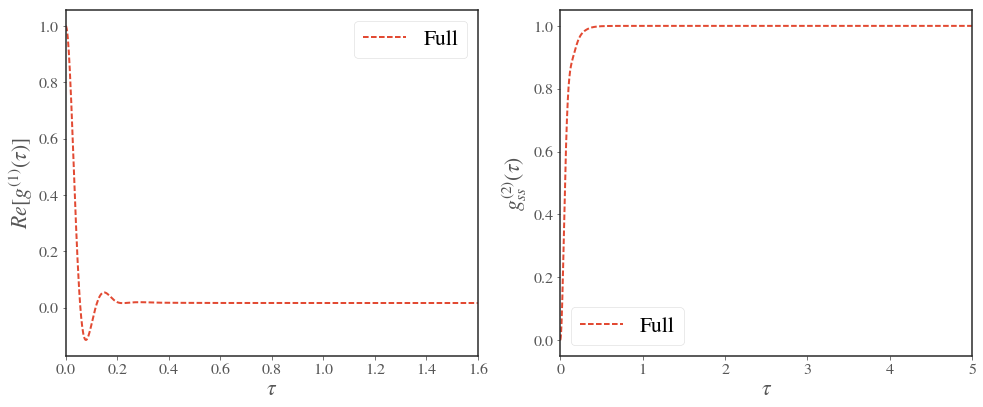

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.394037008286  seconds to build the Non-secular RWA Liouvillian
It took  0.136216878891  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.70664933+0.j         -0.07569085+0.01246527j]
 [-0.07569085-0.01246527j  0.29335067+0.j        ]]
Completed initial dynamics calculations for Full in 1.21641302109  seconds.
Completed correlation function calculations for Full in 0.901777029037 seconds.
G2 took 0.351 seconds
All spectra calculated.


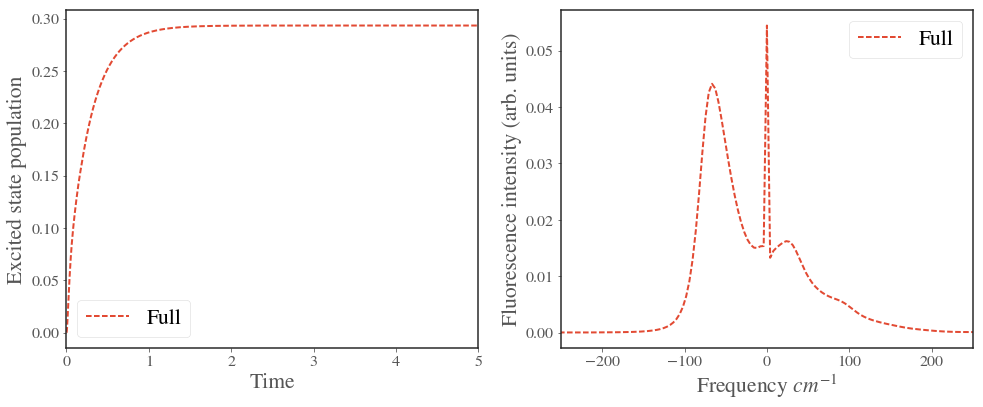

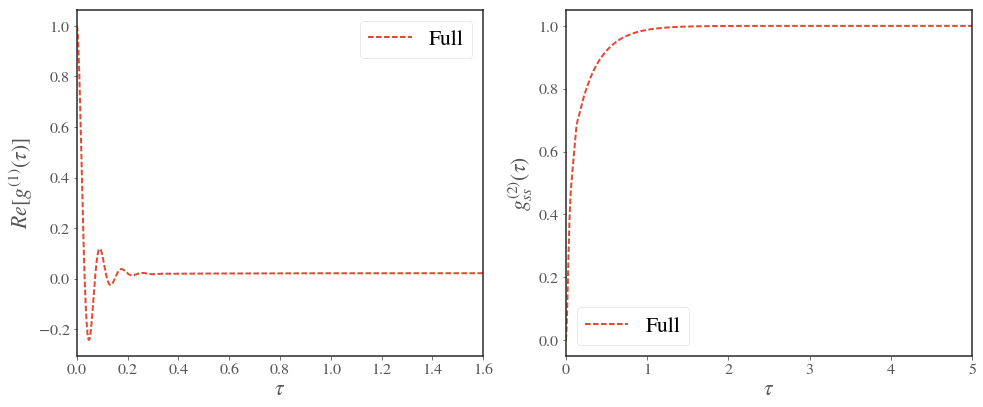

In [86]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)


timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

## Mollow and detuning $\Delta \approx \alpha$

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.256452083588  seconds to build the Non-secular RWA Liouvillian
It took  0.106600046158  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.40143675+0.j         -0.04040244+0.02860469j]
 [-0.04040244-0.02860469j  0.59856325+0.j        ]]
Completed initial dynamics calculations for Full in 0.999963998795  seconds.
Completed correlation function calculations for Full in 0.936197042465 seconds.
G2 took 0.225 seconds
All spectra calculated.


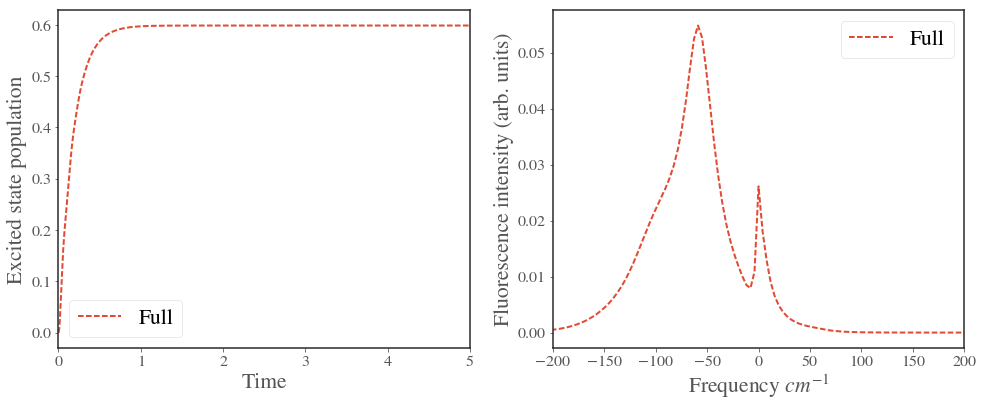

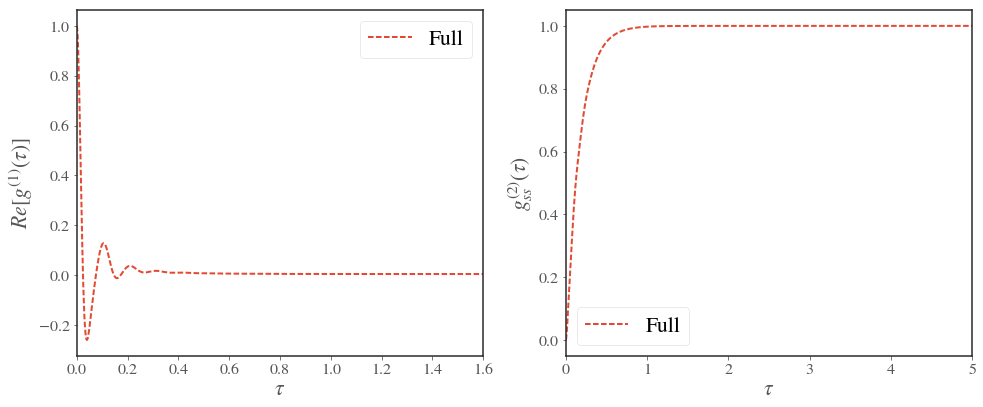

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.430556058884  seconds to build the Non-secular RWA Liouvillian
It took  0.195210933685  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.44763848+0.j        -0.06049992+0.0226746j]
 [-0.06049992-0.0226746j  0.55236152+0.j       ]]
Completed initial dynamics calculations for Full in 1.47141098976  seconds.
Completed correlation function calculations for Full in 0.998790979385 seconds.
G2 took 0.320 seconds
All spectra calculated.


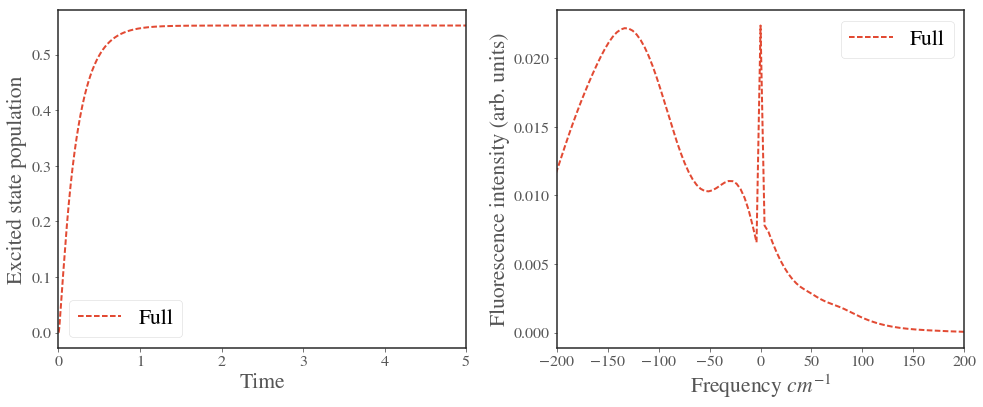

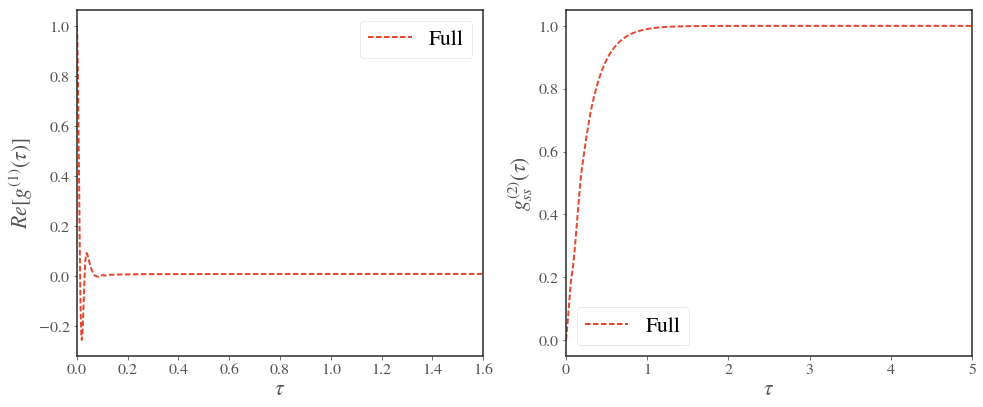

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.235013008118  seconds to build the Non-secular RWA Liouvillian
It took  0.105239152908  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.45408069+0.j         -0.02021569+0.02678793j]
 [-0.02021569-0.02678793j  0.54591931+0.j        ]]
Completed initial dynamics calculations for Full in 1.3853700161  seconds.
Completed correlation function calculations for Full in 0.984528064728 seconds.
G2 took 0.331 seconds
All spectra calculated.


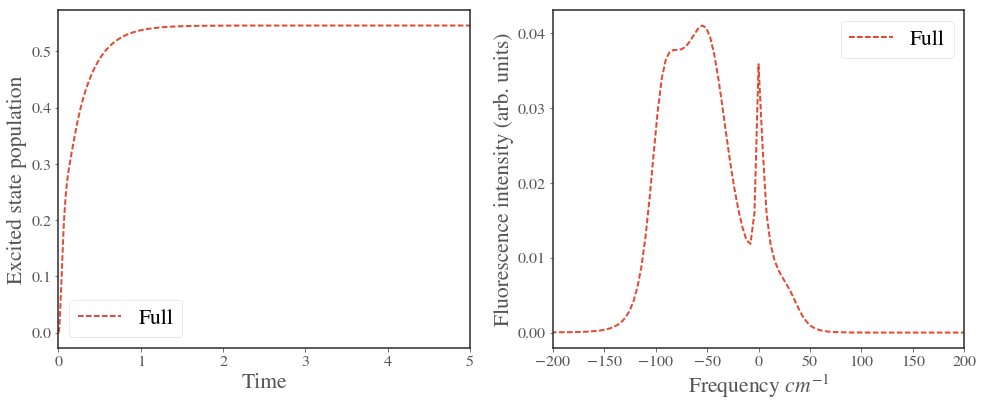

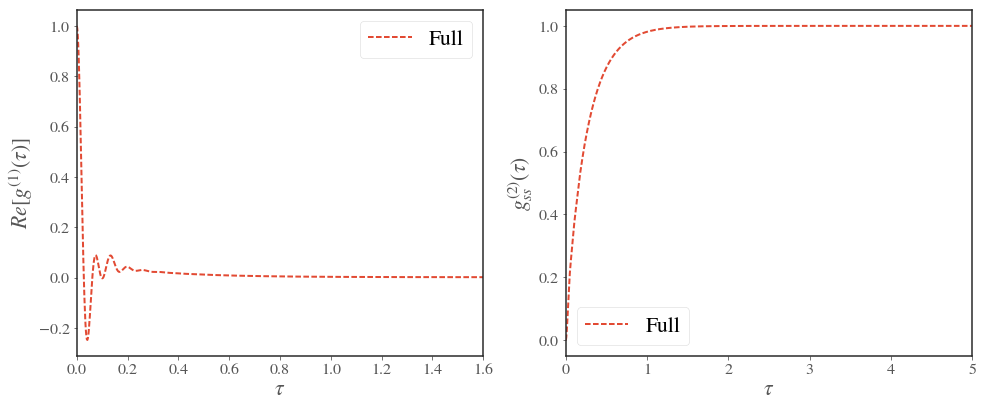

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.251060009003  seconds to build the Non-secular RWA Liouvillian
It took  0.111477136612  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.54646886+0.j         -0.06106285+0.02091363j]
 [-0.06106285-0.02091363j  0.45353114+0.j        ]]
Completed initial dynamics calculations for Full in 1.19408082962  seconds.
Completed correlation function calculations for Full in 0.923207998276 seconds.
G2 took 0.385 seconds
All spectra calculated.


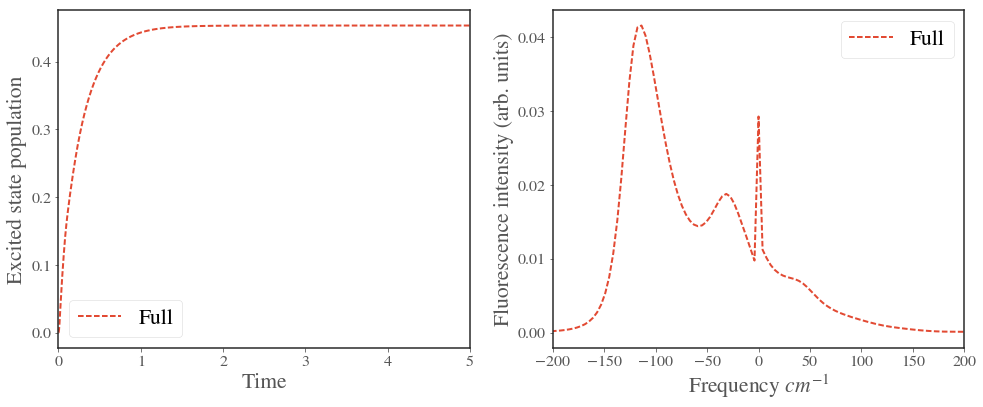

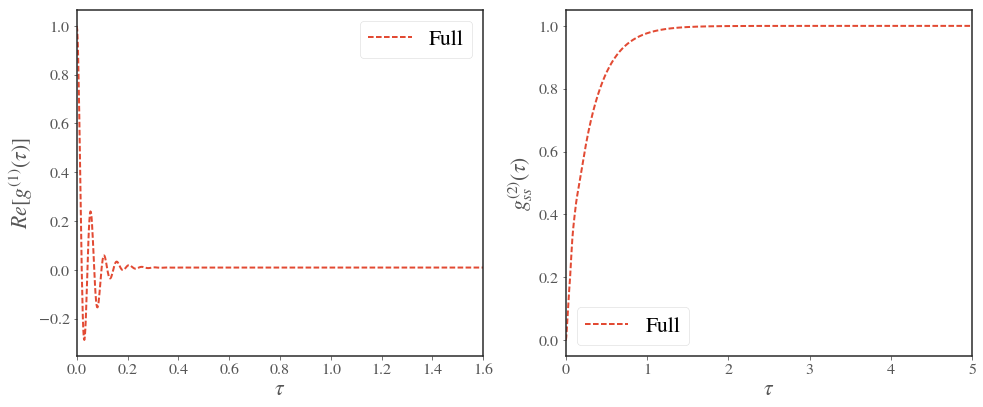

In [87]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.286993026733  seconds to build the Non-secular RWA Liouvillian
It took  0.122004985809  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.82304565+0.j          0.02605197+0.03397906j]
 [ 0.02605197-0.03397906j  0.17695435+0.j        ]]
Completed initial dynamics calculations for Full in 1.04502606392  seconds.
Completed correlation function calculations for Full in 1.02417778969 seconds.
G2 took 0.215 seconds
All spectra calculated.


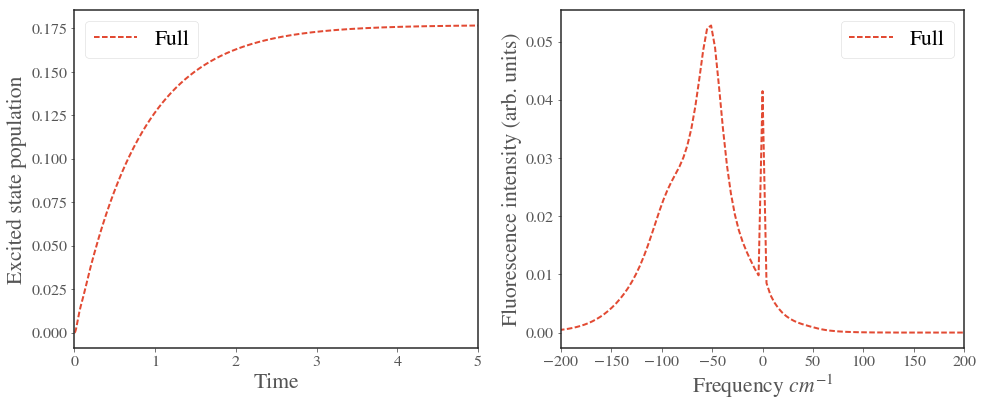

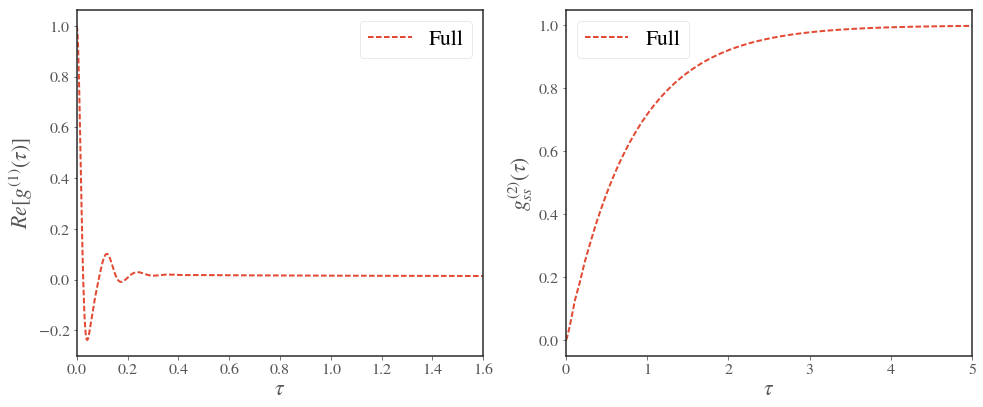

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.434901952744  seconds to build the Non-secular RWA Liouvillian
It took  0.216999053955  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.84270170+0.j         -0.00874687+0.02587545j]
 [-0.00874687-0.02587545j  0.15729830+0.j        ]]
Completed initial dynamics calculations for Full in 1.15030813217  seconds.
Completed correlation function calculations for Full in 1.27779388428 seconds.
G2 took 0.249 seconds
All spectra calculated.


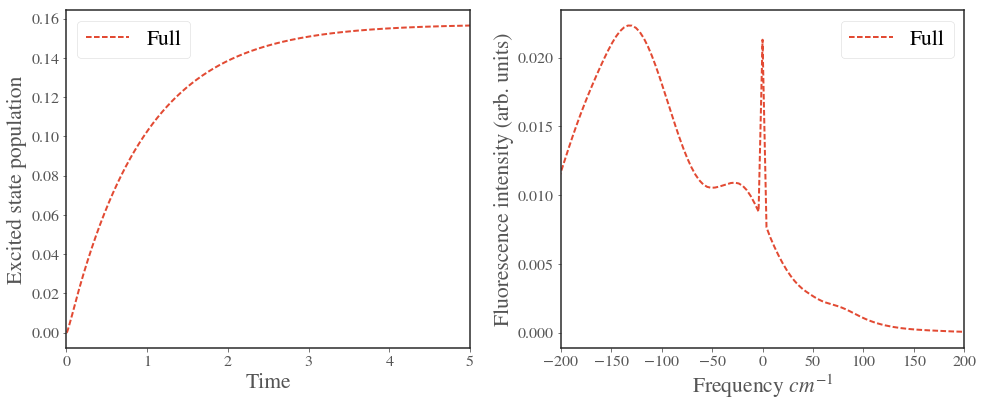

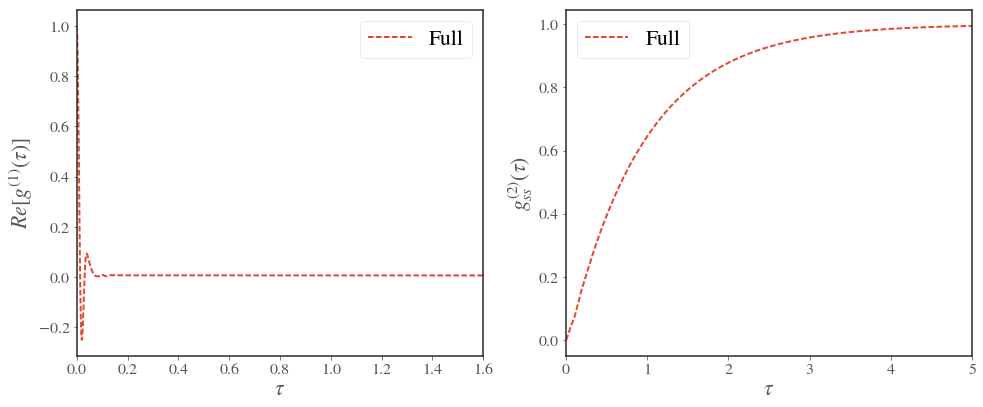

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.248783111572  seconds to build the Non-secular RWA Liouvillian
It took  0.112131118774  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.81409066+0.j          0.02750335+0.03662224j]
 [ 0.02750335-0.03662224j  0.18590934+0.j        ]]
Completed initial dynamics calculations for Full in 1.26788902283  seconds.
Completed correlation function calculations for Full in 1.05401015282 seconds.
G2 took 0.417 seconds
All spectra calculated.


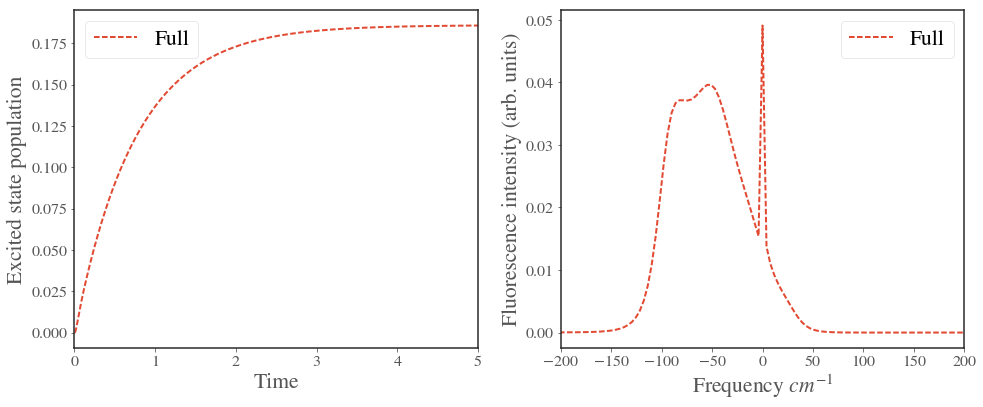

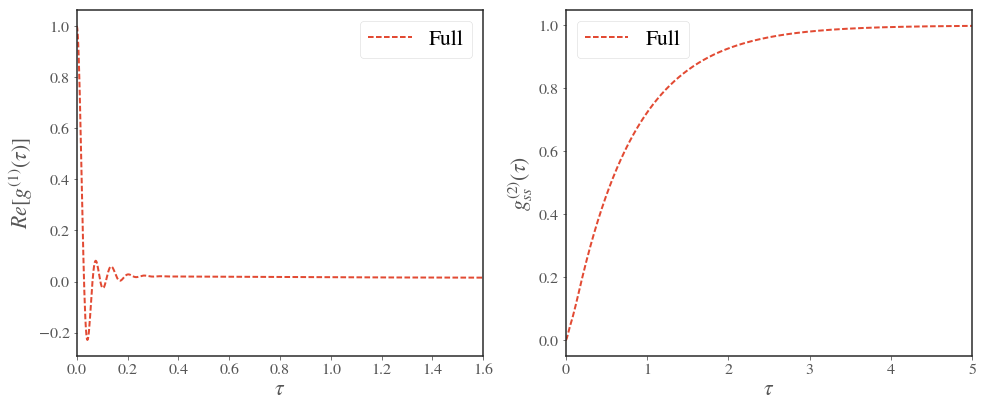

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.268938064575  seconds to build the Non-secular RWA Liouvillian
It took  0.110217809677  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.88266501+0.j         -0.00850074+0.02173076j]
 [-0.00850074-0.02173076j  0.11733499+0.j        ]]
Completed initial dynamics calculations for Full in 1.26002717018  seconds.
Completed correlation function calculations for Full in 1.53465509415 seconds.
G2 took 0.363 seconds
All spectra calculated.


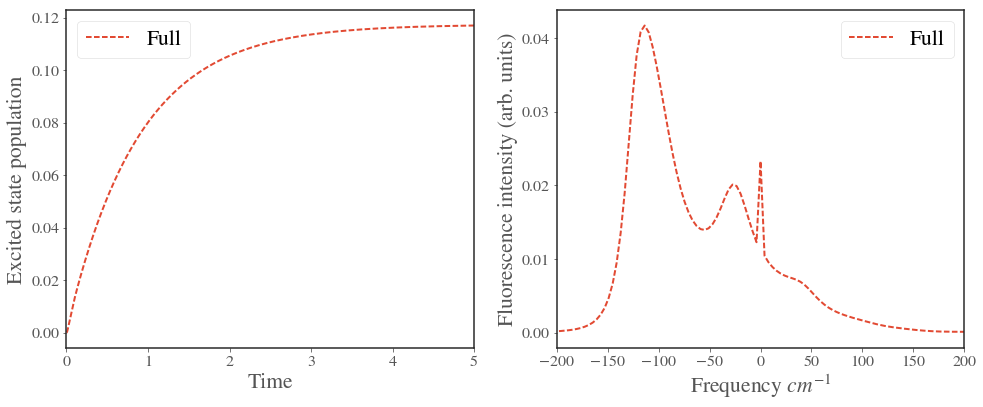

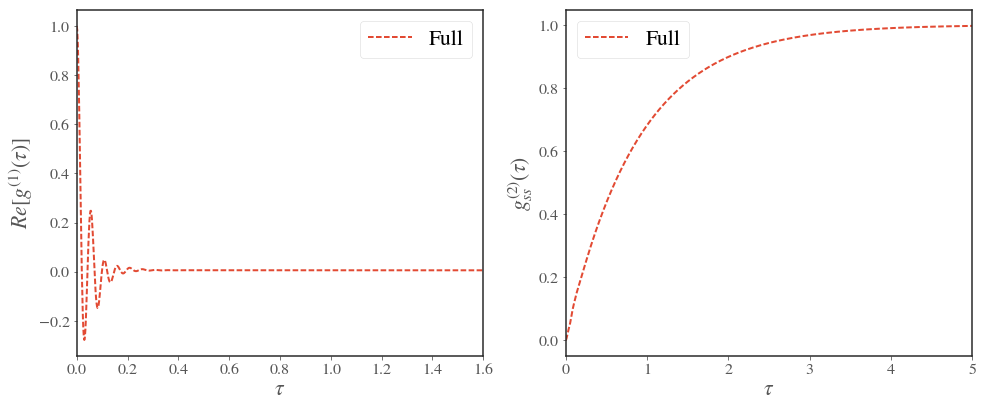

In [11]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.367541790009  seconds to build the Non-secular RWA Liouvillian
It took  0.157804012299  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.57466709+0.j         -0.00737967+0.03893123j]
 [-0.00737967-0.03893123j  0.42533291+0.j        ]]
Completed initial dynamics calculations for Full in 1.07669496536  seconds.
Completed correlation function calculations for Full in 0.993422031403 seconds.
G2 took 0.261 seconds
All spectra calculated.


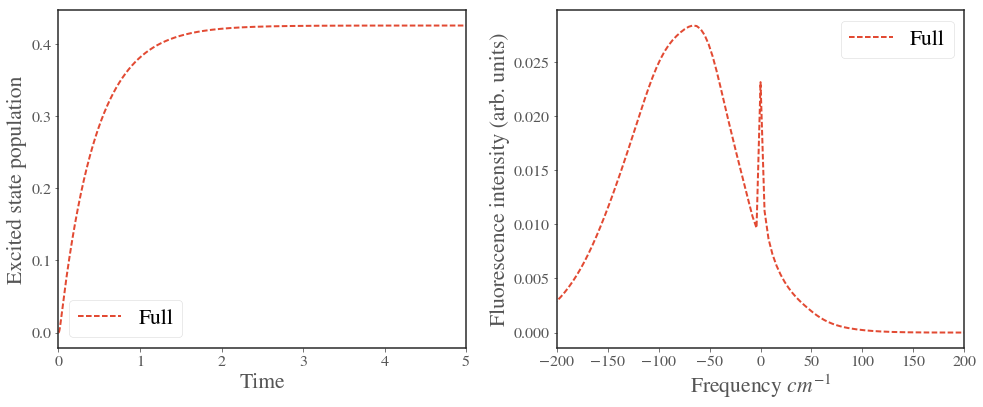

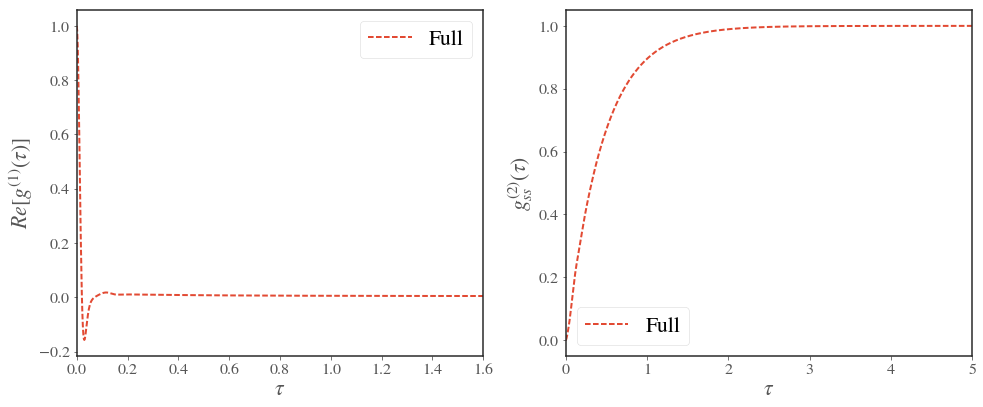

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.760421037674  seconds to build the Non-secular RWA Liouvillian
It took  0.163596868515  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58746992+0.j        -0.02731942+0.0368351j]
 [-0.02731942-0.0368351j  0.41253008+0.j       ]]
Completed initial dynamics calculations for Full in 1.4600110054  seconds.
Completed correlation function calculations for Full in 0.97552895546 seconds.
G2 took 0.306 seconds
All spectra calculated.


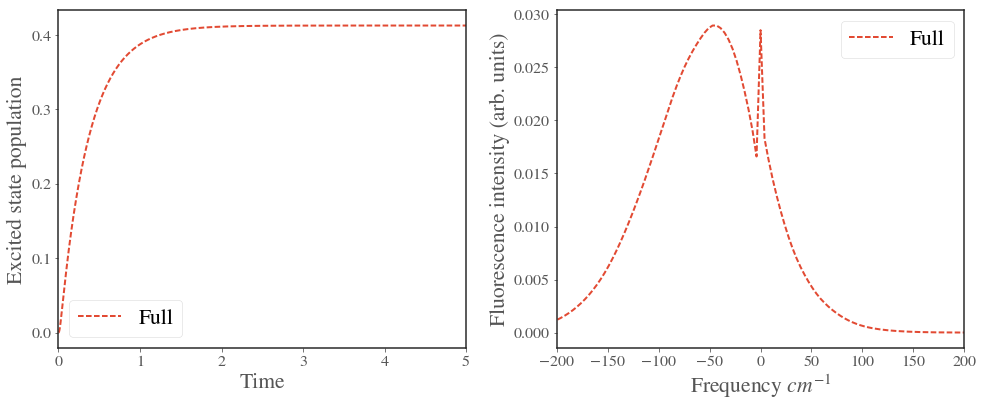

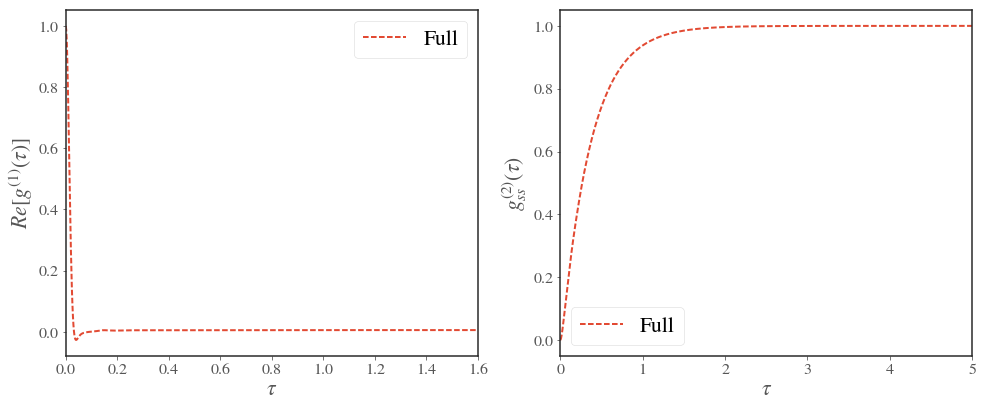

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.316792011261  seconds to build the Non-secular RWA Liouvillian
It took  0.1518471241  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58594808+0.j         -0.01026351+0.03925943j]
 [-0.01026351-0.03925943j  0.41405192+0.j        ]]
Completed initial dynamics calculations for Full in 1.84336709976  seconds.
Completed correlation function calculations for Full in 0.991064071655 seconds.
G2 took 0.585 seconds
All spectra calculated.


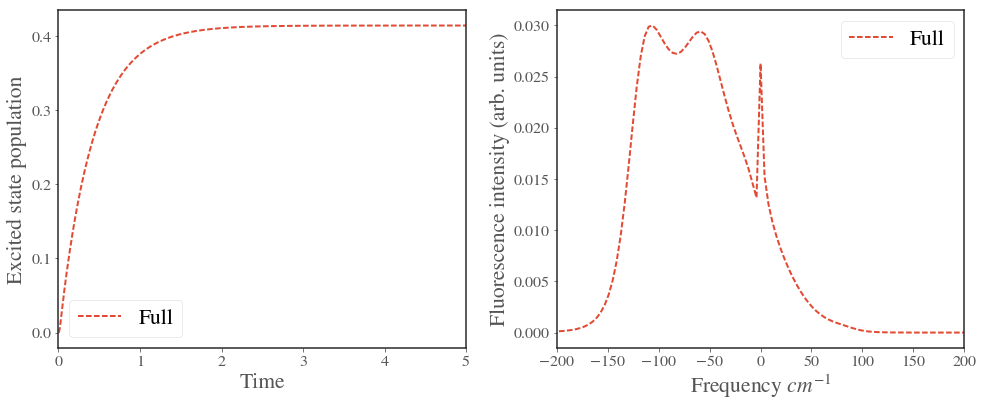

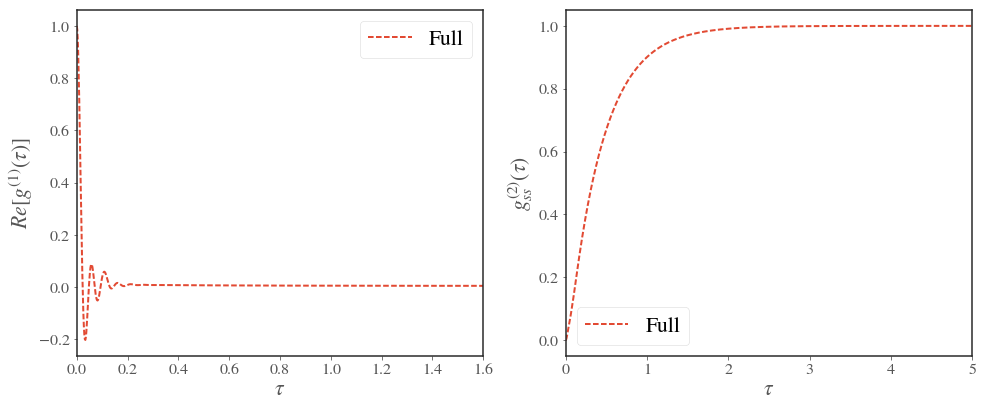

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.392028093338  seconds to build the Non-secular RWA Liouvillian
It took  0.159779071808  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.61467314+0.j         -0.02868934+0.03563651j]
 [-0.02868934-0.03563651j  0.38532686+0.j        ]]
Completed initial dynamics calculations for Full in 1.97718501091  seconds.
Completed correlation function calculations for Full in 1.45442509651 seconds.
G2 took 0.639 seconds
All spectra calculated.


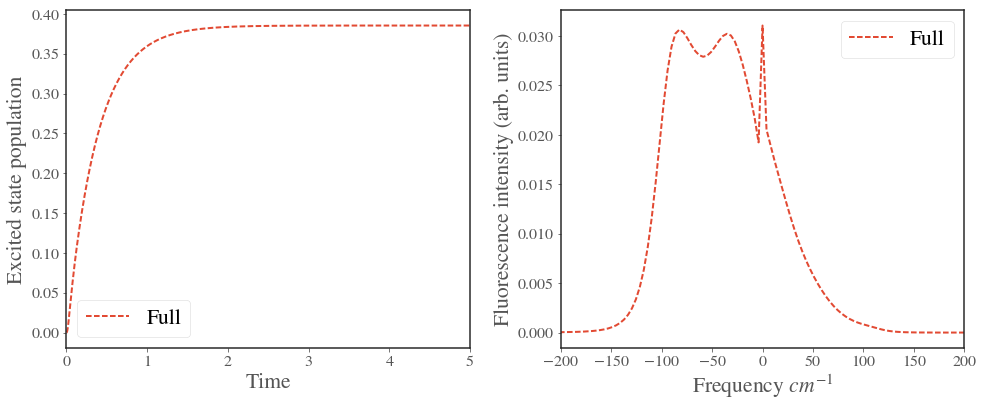

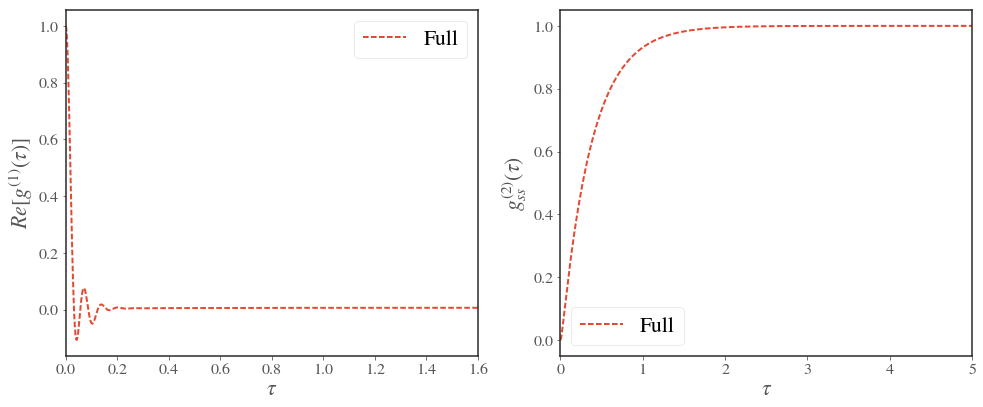

In [17]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=88.62 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.342031002045  seconds to build the Non-secular RWA Liouvillian
It took  0.14689707756  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.69953268+0.j         -0.02400550+0.02219957j]
 [-0.02400550-0.02219957j  0.30046732+0.j        ]]
Completed initial dynamics calculations for Full in 1.3548989296  seconds.
Completed correlation function calculations for Full in 1.02855300903 seconds.
G2 took 0.435 seconds
Steadystate: 
[[ 0.74837658+0.j         -0.02308875+0.02512973j]
 [-0.02308875-0.02512973j  0.25162342+0.j        ]]
Completed initial dynamics calculations for Naive in 1.24825501442  seconds.
Completed correlation function calculations for Naive in 0.997797966003 seconds.
G2 took 0.402 seconds
All spectra calculated.


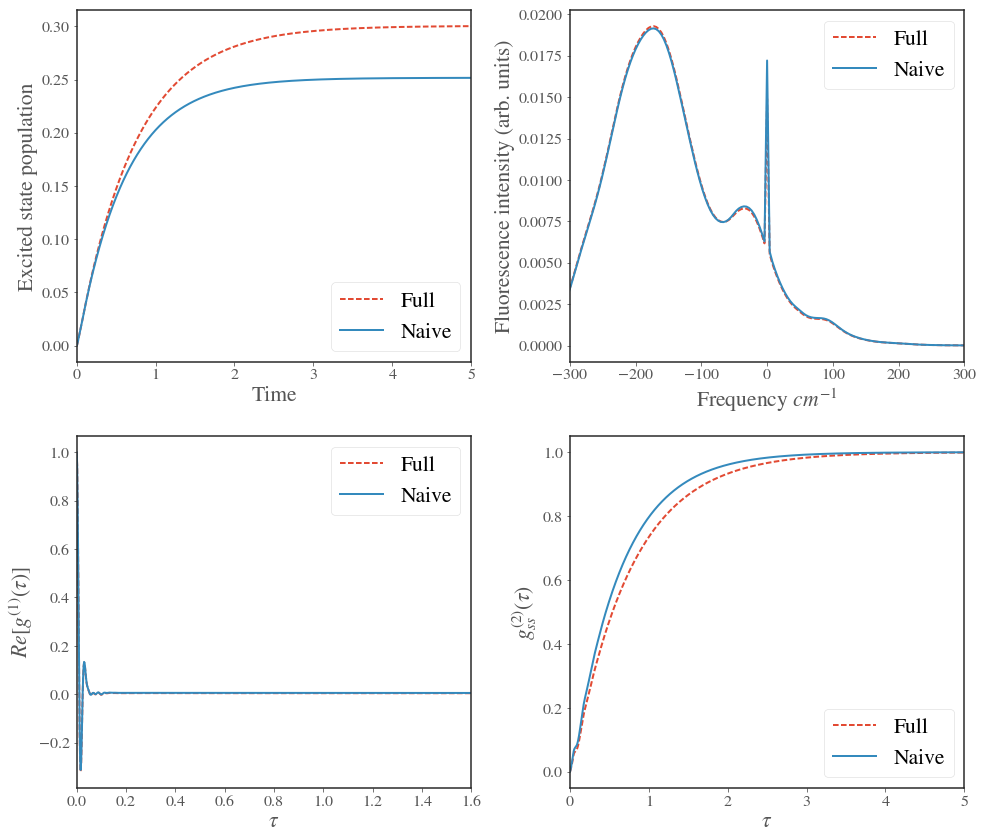

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.357110023499  seconds to build the Non-secular RWA Liouvillian
It took  0.258063077927  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63044496+0.j         -0.02205323+0.03039839j]
 [-0.02205323-0.03039839j  0.36955504+0.j        ]]
Completed initial dynamics calculations for Full in 1.3102889061  seconds.
Completed correlation function calculations for Full in 0.990728139877 seconds.
G2 took 0.507 seconds
Steadystate: 
[[ 0.66506664+0.j         -0.02074700+0.03346534j]
 [-0.02074700-0.03346534j  0.33493336+0.j        ]]
Completed initial dynamics calculations for Naive in 1.4328379631  seconds.
Completed correlation function calculations for Naive in 1.36368703842 seconds.
G2 took 0.634 seconds
All spectra calculated.


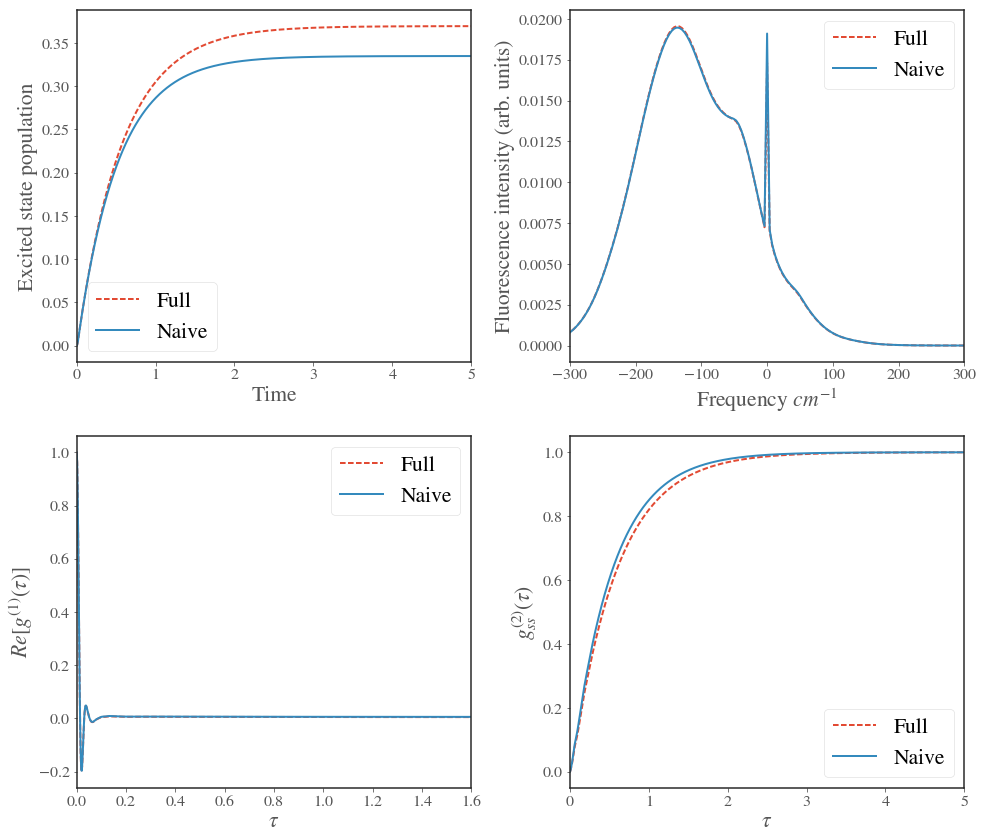

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.511677026749  seconds to build the Non-secular RWA Liouvillian
It took  0.21096777916  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.76103196+0.j         -0.02420863+0.02131021j]
 [-0.02420863-0.02131021j  0.23896804+0.j        ]]
Completed initial dynamics calculations for Full in 1.97814893723  seconds.
Completed correlation function calculations for Full in 1.18476009369 seconds.
G2 took 0.995 seconds
Steadystate: 
[[ 0.77622078+0.j         -0.02362708+0.02234414j]
 [-0.02362708-0.02234414j  0.22377922+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9888920784  seconds.
Completed correlation function calculations for Naive in 1.60914683342 seconds.
G2 took 0.722 seconds
All spectra calculated.


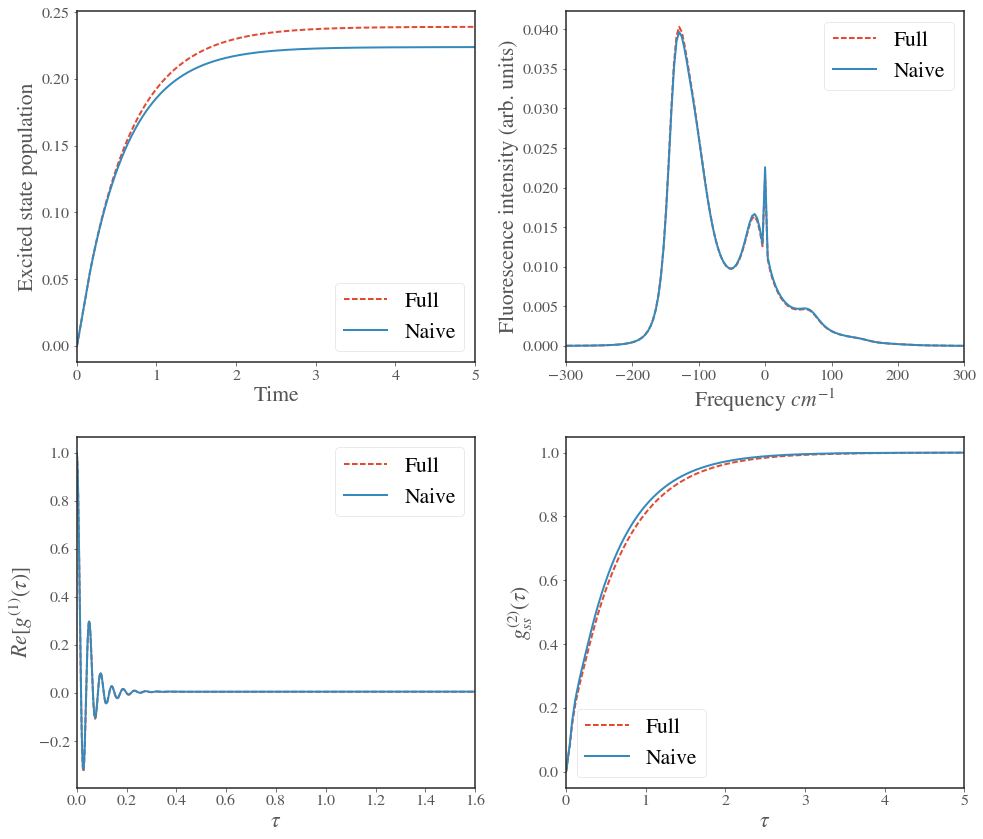

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=44.31 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.386615037918  seconds to build the Non-secular RWA Liouvillian
It took  0.208146095276  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.67149798+0.j        -0.02819039+0.0296174j]
 [-0.02819039-0.0296174j  0.32850202+0.j       ]]
Completed initial dynamics calculations for Full in 1.82608699799  seconds.
Completed correlation function calculations for Full in 1.4369161129 seconds.
G2 took 0.777 seconds
Steadystate: 
[[ 0.68888214+0.j         -0.02760870+0.03107291j]
 [-0.02760870-0.03107291j  0.31111786+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9361550808  seconds.
Completed correlation function calculations for Naive in 1.19508218765 seconds.
G2 took 0.820 seconds
All spectra calculated.


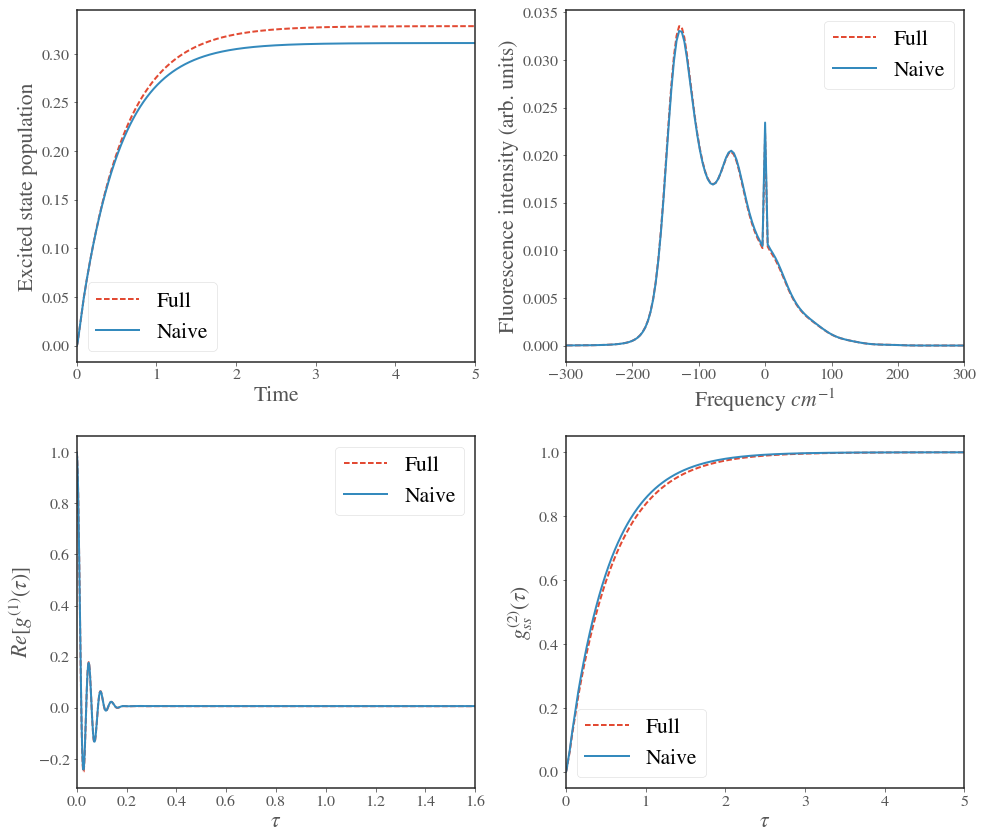

In [29]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.392041921616  seconds to build the Non-secular RWA Liouvillian
It took  0.149307966232  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59528629+0.j          0.01303181+0.03872117j]
 [ 0.01303181-0.03872117j  0.40471371+0.j        ]]
Completed initial dynamics calculations for Full in 1.3572101593  seconds.
Completed correlation function calculations for Full in 0.952977895737 seconds.
G2 took 0.393 seconds
Steadystate: 
[[ 0.60296238+0.j          0.01433440+0.03973069j]
 [ 0.01433440-0.03973069j  0.39703762+0.j        ]]
Completed initial dynamics calculations for Naive in 1.16486597061  seconds.
Completed correlation function calculations for Naive in 0.922996997833 seconds.
G2 took 0.311 seconds
All spectra calculated.


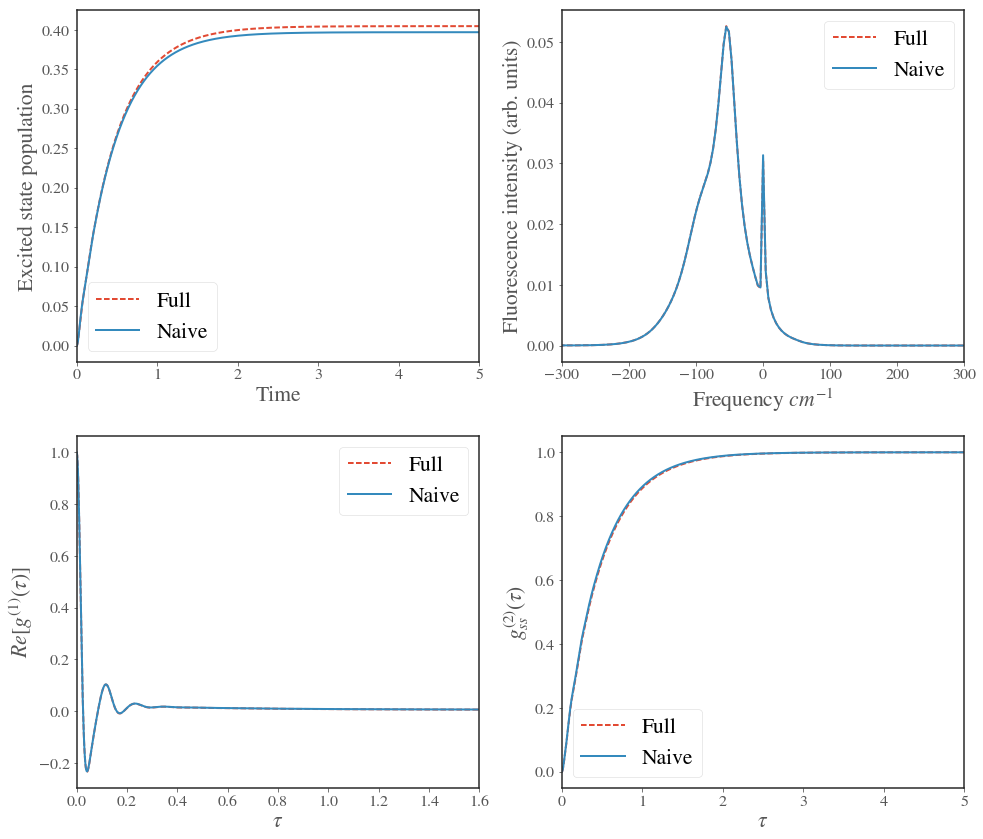

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.355205059052  seconds to build the Non-secular RWA Liouvillian
It took  0.349143981934  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.65930671+0.j          0.03557707+0.03338683j]
 [ 0.03557707-0.03338683j  0.34069329+0.j        ]]
Completed initial dynamics calculations for Full in 1.31622600555  seconds.
Completed correlation function calculations for Full in 1.14694905281 seconds.
G2 took 0.410 seconds
Steadystate: 
[[ 0.66304104+0.j          0.03638318+0.03375614j]
 [ 0.03638318-0.03375614j  0.33695896+0.j        ]]
Completed initial dynamics calculations for Naive in 1.07454609871  seconds.
Completed correlation function calculations for Naive in 0.898280143738 seconds.
G2 took 0.283 seconds
All spectra calculated.


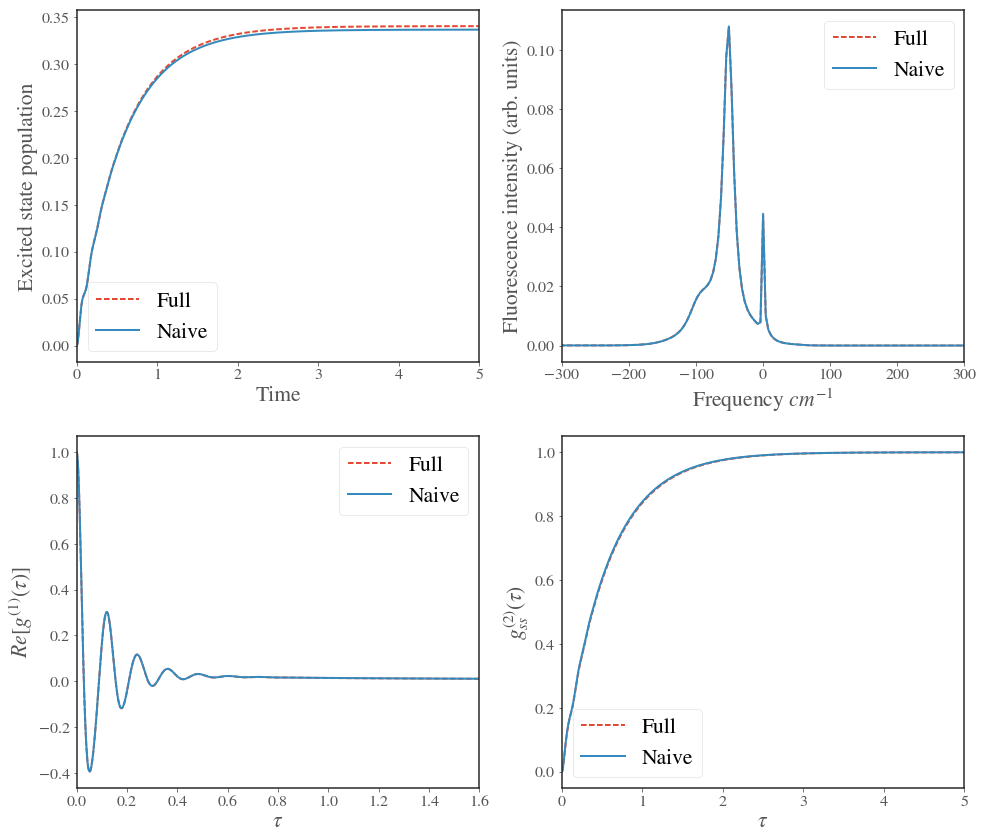

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.338986873627  seconds to build the Non-secular RWA Liouvillian
It took  0.152198076248  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59747071+0.j          0.01525680+0.03932953j]
 [ 0.01525680-0.03932953j  0.40252929+0.j        ]]
Completed initial dynamics calculations for Full in 1.73083615303  seconds.
Completed correlation function calculations for Full in 0.98946595192 seconds.
G2 took 0.951 seconds
Steadystate: 
[[ 0.60250312+0.j          0.01613961+0.03977941j]
 [ 0.01613961-0.03977941j  0.39749688+0.j        ]]
Completed initial dynamics calculations for Naive in 2.04945206642  seconds.
Completed correlation function calculations for Naive in 1.03842902184 seconds.
G2 took 0.819 seconds
All spectra calculated.


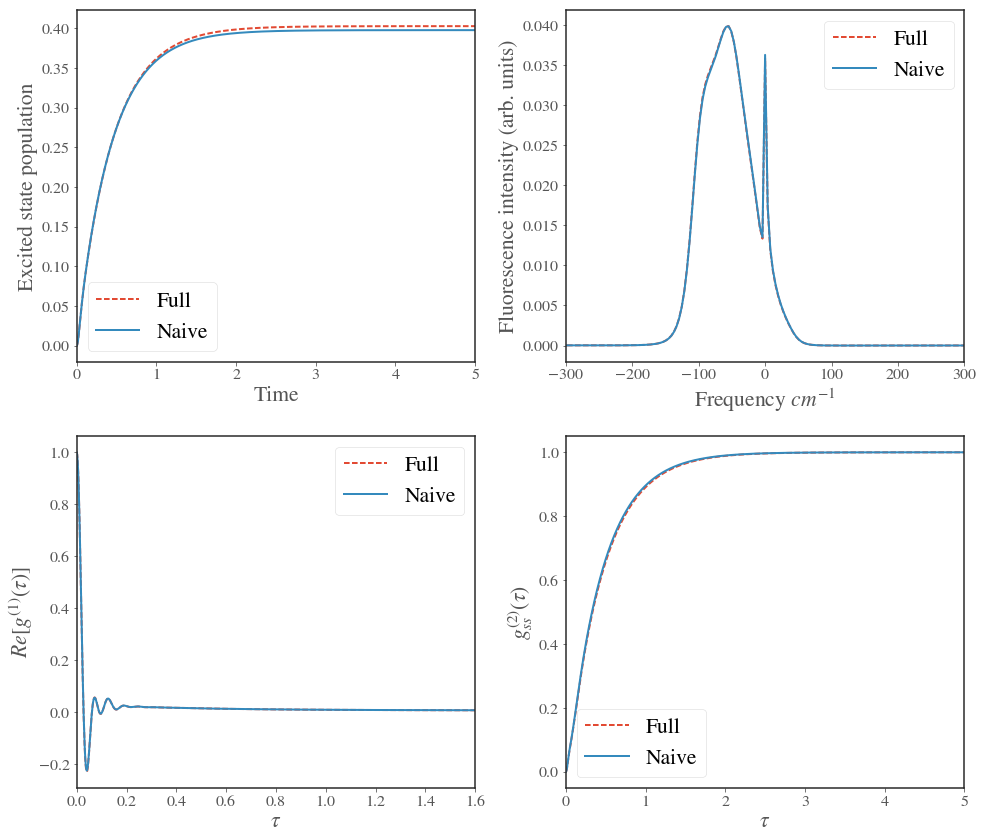

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=14.01 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.341111183167  seconds to build the Non-secular RWA Liouvillian
It took  0.146584033966  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.68116812+0.j          0.05188392+0.03175018j]
 [ 0.05188392-0.03175018j  0.31883188+0.j        ]]
Completed initial dynamics calculations for Full in 1.36547613144  seconds.
Completed correlation function calculations for Full in 0.97603392601 seconds.
G2 took 0.589 seconds
Steadystate: 
[[ 0.68302059+0.j          0.05229715+0.03178252j]
 [ 0.05229715-0.03178252j  0.31697941+0.j        ]]
Completed initial dynamics calculations for Naive in 1.55240893364  seconds.
Completed correlation function calculations for Naive in 1.0134370327 seconds.
G2 took 0.589 seconds
All spectra calculated.


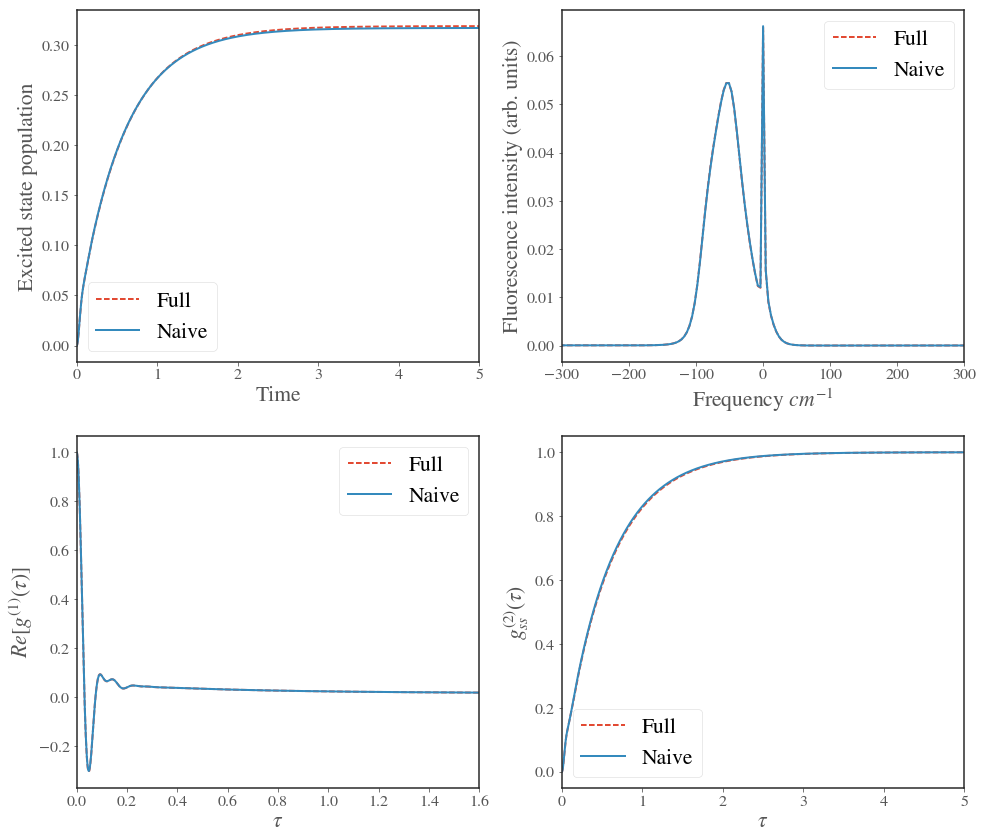

In [30]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)